# 10th Nov 
* only use the already trained models to load and run
* But the current dimensions are not working, so use 10th nov ones where the dimensions have been adjusted
* Changed the dimensions from 3 to 2
* updated graph types and representation


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install h5py

### Libraries

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import initializers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


import tensorflow as tf
# import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import utils
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD # from keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop # instead of from keras.optimizers import RMSprop
# from keras import datasets

# from keras.callbacks import LearningRateScheduler
# from keras.callbacks import History

from tensorflow.keras import losses
from sklearn.utils import shuffle


# for saving model
from tensorflow.keras.models import model_from_json
import h5py
# import keras

# print(keras.__version__)
# print(tf.keras.__version__)

In [ ]:
from platform import python_version

print(python_version())

3.7.12


### taking input

In [ ]:
%%time
# Final plotting
K = 25 # as we have 25 clients

clients = {} # dictionary
clients_cut = {}

## reading the data from each client
for st_code in range(101,126):
    clients[st_code] = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataNew/station_code"+str(st_code)+".csv", index_col = 0)

    clients[st_code]['Measurement date'] = pd.to_datetime(clients[st_code]['Measurement date'])

    clients[st_code]['year'] = clients[st_code]['Measurement date'].dt.year
    clients[st_code]['month'] = clients[st_code]['Measurement date'].dt.month
    clients[st_code]['week'] = clients[st_code]['Measurement date'].dt.week
    clients[st_code]['day'] = clients[st_code]['Measurement date'].dt.day
    clients[st_code]['hour'] = clients[st_code]['Measurement date'].dt.hour
    clients[st_code]['minute'] = clients[st_code]['Measurement date'].dt.minute # minute is not significant; as only 0 values
    clients[st_code]['dayOfWeek'] = clients[st_code]['Measurement date'].dt.dayofweek

    # choosing features
    clients[st_code] = clients[st_code][['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek', 'CO', 	'PM10',	'PM2.5']]

    clients[st_code].drop(clients[st_code][clients[st_code]['CO'] < 0].index, axis=0, inplace=True)
    clients[st_code].drop(clients[st_code][clients[st_code]['PM10'] < 0].index, axis=0, inplace=True)
    clients[st_code].drop(clients[st_code][clients[st_code]['PM2.5'] < 0].index, axis=0, inplace=True)


# complete dataset
frames = list(clients.values())
dataset = pd.concat(frames)
# display(dataset)




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: Fut

CPU times: user 3.08 s, sys: 239 ms, total: 3.32 s
Wall time: 15.3 s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  from ipykernel import kernelapp as app


## 1 hidden layer
* with 4 neurons

### traditional Learning

In [ ]:
def traditional_ML_1L_4_train(loss_p, gas, train_data):
  # initialize w_0
  model = Sequential()

  # model.add(Dense(64, kernel_initializer='zeros', bias_initializer='zeros', activation=tf.nn.relu, input_dim=6)) # first dense/hidden layer
  model.add(Dense(4, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu, input_dim=8))
  model.add(Dropout(0.1))

  model.add(Dense(1, kernel_initializer= 'he_uniform', activation='linear')) # output layer


  # compile the model
  model.compile(loss='mse', 
              optimizer='adam', 
              metrics=['mse'])
  
  x_train, y_train = train_data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  train_data[gas]

 

  B = 1000 #int(len(x_train) * 0.01) # so for each client the batch size would be different depending upon the total sample size
  E = 25 #max(30, B//10) # number of local epochs; it will also depend on sample size (indirectly)


  model.fit(x_train, y_train, 
                  epochs = E, 
                  batch_size=B,
                  verbose=False)
  
  return model
      


In [ ]:
def traditional_ML_1L_4_test(model_name, gas, test_data):

  ## loading the json and creating model
  json_file = open(model_name + ".json", 'r')
  model_json = json_file.read()
  json_file.close()

  model = model_from_json(model_json)
  model.load_weights(model_name + ".h5")

  ## need to compile the model again after loading
  # compile the model
  model.compile(loss='mse', 
              optimizer='adam', 
              metrics=['mse'])
  

  x_test, y_test = test_data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  test_data[gas]

  x_test, y_test = x_test.to_numpy(), y_test.to_numpy()

  # adjusting the dimensions
  x_test = x_test.reshape(x_test.shape[0], x_test.shape[1])
  y_test = y_test.reshape(y_test.shape[0],1)
  
  y_predicted = model.predict(x_test)
  

  from sklearn.metrics import mean_squared_error
  mse = mean_squared_error(y_predicted.ravel(), y_test.ravel())

  NE = np.sum(abs(np.array(y_test) - np.array(y_predicted))) / np.sum(np.array(y_test))
  return (mse, NE)


In [ ]:
# Final plotting
K = 25 # as we have 25 clients
train_data = pd.DataFrame()
test_data = pd.DataFrame()
loss_prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
gases = ['CO', 	'PM10',	'PM2.5']
errors_tl_h1_4 = {'CO':[], 	'PM10':[],	'PM2.5':[]}
models = []
model_name = "TL_model_1L_4_"


# for gas in gases:
#   for loss_p in loss_prob:
#     error = traditional_ML_L3_32(loss_p, gas)
#     errors_tl_h3_32[gas].append(error)

for gas in gases:
  for lp in loss_prob:
      for st_code in range(101,126):
          # splitting into train test split
          X, y = clients[st_code][['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  clients[st_code][gas]
          x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = lp, random_state=1)

          # Normalization using min-max scaler
          # Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set.
          # to avoid data leak
          scaler_cols = x_train.columns
          scaler_idx_train = x_train.index
          scaler_idx_test = x_test.index

          # from sklearn.preprocessing import MinMaxScaler
          scaler = MinMaxScaler()

          # transforming train data
          x_train_encoded_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns = scaler_cols, index=scaler_idx_train)
          # display(x_train_encoded_scaled.head())

          # transforming test data
          x_test_encoded_scaled = pd.DataFrame(scaler.transform(x_test), columns = scaler_cols, index = scaler_idx_test)
          # display(x_test_encoded_scaled.head())

          # training data prep
          if st_code == 101:
            train_data = pd.concat([x_train_encoded_scaled, y_train], axis = 1)
          else:
            xy = pd.concat([x_train_encoded_scaled, y_train], axis=1)
            train_data = pd.concat([train_data, xy], axis=0)
          # clients_cut[st_code] = pd.concat([x_train_encoded_scaled, y_train], axis = 1)
          

          # testing data prep
          # first appending x_test and y_test column wise
          # then appending each clients' dataframe one below other
          if st_code == 101:
            test_data = pd.concat([x_test_encoded_scaled, y_test], axis = 1)
          else:
            xy = pd.concat([x_test_encoded_scaled, y_test], axis=1)
            test_data = pd.concat([test_data, xy], axis=0)
          # x_test, y_test = x_test.to_numpy(), y_test.to_numpy()
      
      # Training the model using traditional learning

      ## Saving model
      ## serializing model to JSON
      model_address = "/content/drive/MyDrive/Colab Notebooks/Models/" + model_name + gas + str(lp) + "_"


      ## Testing model
      error = traditional_ML_1L_4_test(model_address, gas, train_data)
      errors_tl_h1_4[gas].append(error)
      # testing model
      # errors_fl_h3_32[gas].append(error_clients_L3_32(model, gas))


### Federated Learning

In [ ]:
# ClientUpdate(k, w): // Run on client k
def Client_L1_4(client_idx, model, gas):
    # B ← (split P_k into batches of size B) # what is p_K --> each clients' sample size
    B = 1000 #int(len(clients[client_idx]) * 0.01) # so for each client the batch size would be different depending upon the total sample size
    E = 25 #max(30, B//10) # number of local epochs; it will also depend on sample size (indirectly)

    data = clients_cut[client_idx]
    # data = dataset.loc[dataset['Station code'] == client_idx]

    X, y = data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  data[gas]

    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state=1)

    try:
        model.fit(x_train, y_train, 
                    epochs = E, 
                    batch_size=B,
                    validation_data=(x_val, y_val),
                    verbose=False)
    except Exception as e:
        print(e)
        print("error")

    # return w to server
    # in our case no need for any explicit return; as the model is pass by value
    return data.shape[0] # this will return the number of total sample


In [ ]:
# Server executes: 
def Server_L1_4(gas):
    # initialize w_0
    model = Sequential()
    
    # model.add(Dense(64, kernel_initializer='zeros', bias_initializer='zeros', activation=tf.nn.relu, input_dim=6)) # first dense/hidden layer
    model.add(Dense(4, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu, input_dim=8))
    model.add(Dropout(0.1))

    model.add(Dense(1, kernel_initializer= 'he_uniform', activation='linear')) # output layer


    # compile the model
    model.compile(loss='mse', 
                optimizer='adam', 
                metrics=['mse'])
    

# for each round t = 1, 2, . . . do
    for t in range(1, 5):
        C = np.random.random(1)[0] # random number between 0 and 1.

        # m ← max(C  K, 1)
        m = max(int(C*K), 1) # m == random number of client selected
        weight_t_plus_1 = [None] * m # matrix to store the weights of all client in each t-round
        n_k = [None] * m # parameters for weighted sum 


        # S_t ← (random set of m clients)
        # S = {} # dictionary
        S_t = np.random.uniform(low=101, high=126, size=(m)).astype(int)

        # No need for below loop, as server don't need access to client data, server only need clients' number
        # for client in m_clients:
        #   S[client] = clients[client]

        initial_weights = model.get_weights() # setting initial weights; should be same for all clients
        # for t= 1 to T, initial_weights would be t-1th's final weights

        # for each client k ∈ S_t in parallel do
        client_idx = 0
        for client in S_t:
            # w^(k)_(t+1) ← ClientUpdate(k, model)
            n_k[client_idx] = Client_L1_4(client, model, gas) # pass by reference for model
            weight_t_plus_1[client_idx] = model.get_weights()
            client_idx += 1

            # setting weights back to initial weights
            model.set_weights(initial_weights)

        # finding the weighted sum
        final_weights_t = np.array(weight_t_plus_1[0]) * (n_k[0] / sum(n_k))

        for idx in range(1, m):
          # w_(t+1) ← summation(k=1 to K){(n_k/n) * w^(k)_(t+1)} #n_k - no. of training sample in each client K; n - total training samples;
          final_weights_t += np.array(weight_t_plus_1[idx]) * (n_k[idx]/ sum(n_k))

        # setting the aggregated weights
        model.set_weights(final_weights_t)


#         print(model.get_weights())
    # return error_clients(model, loss_p)) # THIS LINE WON'T BE THERE IN REAL SERVER
    return model

In [ ]:
def error_clients_L1_4(model_name, gas, test_data):

    ## loading the json and creating model
    json_file = open(model_name + ".json", 'r')
    model_json = json_file.read()
    json_file.close()

    model = model_from_json(model_json)
    model.load_weights(model_name + ".h5")

    ## need to compile the model again after loading
    # compile the model
    model.compile(loss='mse', 
                optimizer='adam', 
                metrics=['mse'])
  
    
    X, y = test_data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  test_data[gas]
    
    # adjusting the dimensions
    x_test, y_test = X.to_numpy(), y.to_numpy()
    x_test = x_test.reshape(x_test.shape[0],  x_test.shape[1])
    y_test = y_test.reshape(y_test.shape[0],1)

    y_predicted = model.predict(x_test)
    
    from sklearn.metrics import mean_squared_error
    # print("y_predicted", y_predicted)
    # print("y_predicted.ravel()", y_predicted.ravel())
    NE = np.sum(abs(np.array(y_test) - np.array(y_predicted))) / np.sum(np.array(y_test))

    mse = mean_squared_error(y_predicted.ravel(), y_test.ravel())
    
    return (mse,NE)

          

In [ ]:

# create an Empty DataFrame object
train_data = pd.DataFrame()
test_data = pd.DataFrame()
loss_prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
models = []
errors_fl_h1_4 = {'CO':[], 	'PM10':[],	'PM2.5':[]}
gases = ['CO', 	'PM10',	'PM2.5']
model_name = "FL_model_1L_4_"


# reading all the clients and building model
for gas in gases:
  for lp in loss_prob:
      for st_code in range(101,126):
          # splitting into train test split
          X, y = clients[st_code][['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  clients[st_code][gas]
          x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = lp, random_state=1)

          # Normalization using min-max scaler
          # Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set.
          # to avoid data leak
          scaler_cols = x_train.columns
          scaler_idx_train = x_train.index
          scaler_idx_test = x_test.index

          # from sklearn.preprocessing import MinMaxScaler
          scaler = MinMaxScaler()

          # transforming train data
          x_train_encoded_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns = scaler_cols, index=scaler_idx_train)
          # display(x_train_encoded_scaled.head())

          # transforming test data
          x_test_encoded_scaled = pd.DataFrame(scaler.transform(x_test), columns = scaler_cols, index = scaler_idx_test)
          # display(x_test_encoded_scaled.head())

          # training data prep
          clients_cut[st_code] = pd.concat([x_train_encoded_scaled, y_train], axis = 1)

          # testing data prep
          # first appending x_test and y_test column wise
          # then appending each clients' dataframe one below other
          if st_code == 101:
            test_data = pd.concat([x_test_encoded_scaled, y_test], axis = 1)
          else:
            xy = pd.concat([x_test_encoded_scaled, y_test], axis=1)
            test_data = pd.concat([test_data, xy], axis=0)
          # x_test, y_test = x_test.to_numpy(), y_test.to_numpy()


      ## serializing model to JSON
      model_address = "/content/drive/MyDrive/Colab Notebooks/Models/" + model_name + gas + str(lp) + "_"


      ## Testing model
      error = error_clients_L1_4(model_address, gas, test_data)
      errors_fl_h1_4[gas].append(error)


### Plots

#### Original plots

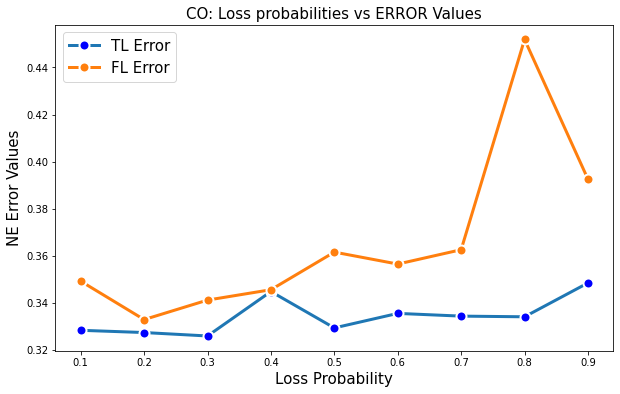

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_4['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error',linewidth=3, mfc='blue', ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_4['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error', linewidth=3, ms='10', mew='2')

# ax.set(ylim=(0.2, 0.5))
# plt.setp(ax.get_legend().get_texts(), fontsize='52') # for legend text
# plt.setp(ax.get_legend().get_title(), fontsize='32') # for legend title

plt.legend(fontsize=15, title_fontsize='80')

# plt.legend()
plt.xlabel("Loss Probability", fontsize=15)
plt.ylabel("NE Error Values", fontsize=15)
# plt.title("With 1 Hidden Layer, layer with 4 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.title("CO: Loss probabilities vs ERROR Values", fontsize=15) 
plt.show(ax)

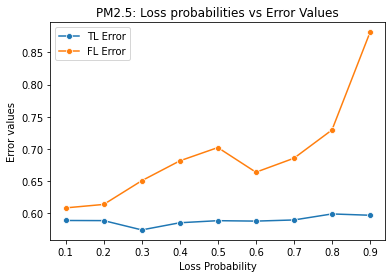

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_4['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_4['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.96, 0.9625))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
# plt.title("With 1 Hidden Layer, layer with 4 neurons\nPM2.5: Loss probabilities vs Error Values") 
plt.title("PM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

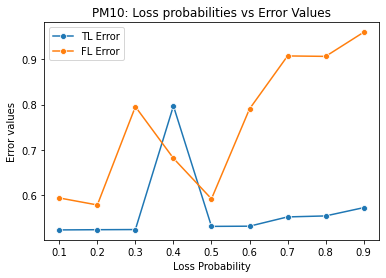

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_4['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_4['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.977, 0.979))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
# plt.title("With 1 Hidden Layer, layer with 4 neurons\nPM10: Loss probabilities vs Error Values") 
plt.title("PM10: Loss probabilities vs Error Values")
plt.show(ax)

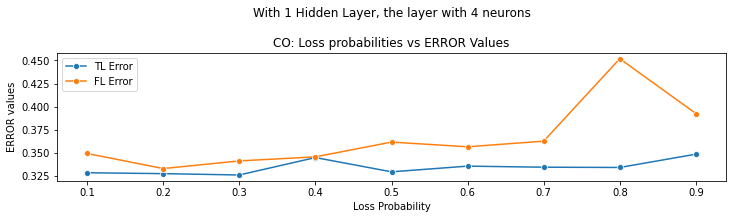

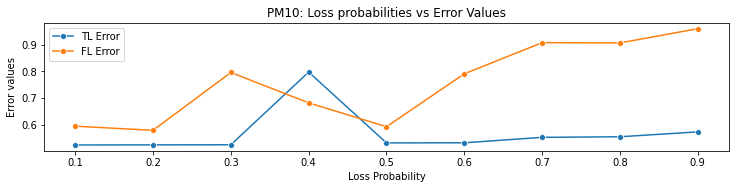

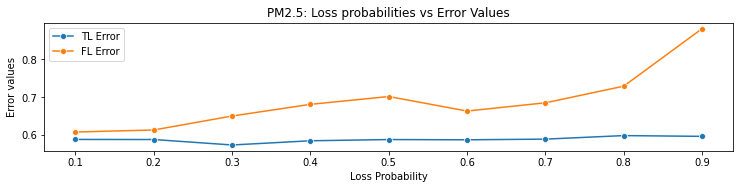

In [ ]:
plt.figure(figsize=(12, 8))
plt.title("With 1 Hidden Layers, each layer with 16 neurons")

plt.subplot(3,1,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_4['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_4['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.2, 0.5))
# ax.set(xlim=(0.1, 0.9))
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 1 Hidden Layer, the layer with 4 neurons\n\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)


plt.figure(figsize=(27, 8))
plt.subplot(3,2,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_4['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_4['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.977, 0.979))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM10: Loss probabilities vs Error Values") 
plt.show(ax)


plt.figure(figsize=(42, 8))
plt.subplot(3,3,1)
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_4['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_4['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.96, 0.9625))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

#### Customized plots: 0.5

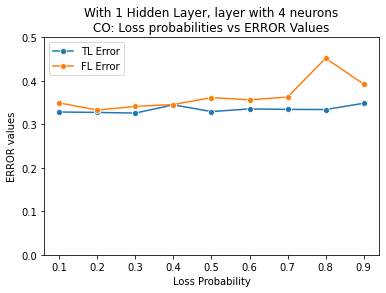

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_4['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_4['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 0.5))

plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 1 Hidden Layer, layer with 4 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)

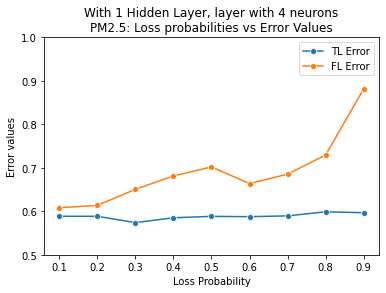

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_4['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_4['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.5, 1.0))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 1 Hidden Layer, layer with 4 neurons\nPM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

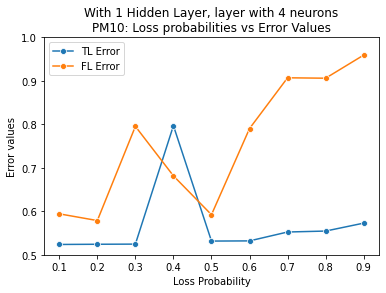

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_4['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_4['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.5, 1.0))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 1 Hidden Layer, layer with 4 neurons\nPM10: Loss probabilities vs Error Values") 
plt.show(ax)

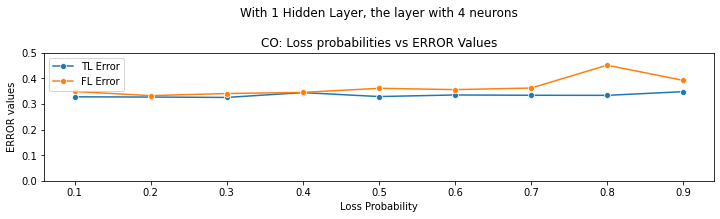

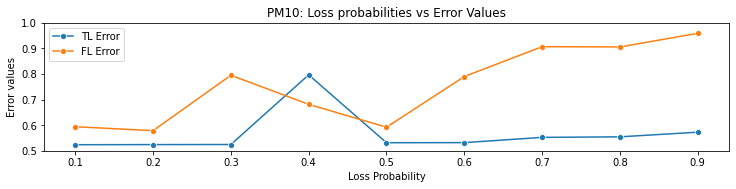

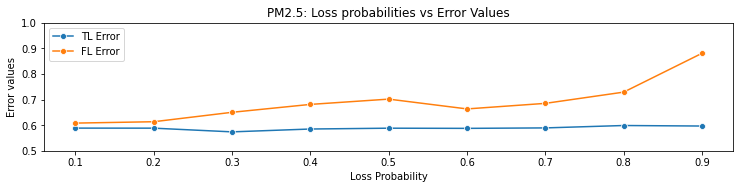

In [ ]:
plt.figure(figsize=(12, 8))
plt.title("With 1 Hidden Layers, each layer with 16 neurons")

plt.subplot(3,1,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_4['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_4['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 0.5))
# ax.set(xlim=(0.1, 0.9))
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 1 Hidden Layer, the layer with 4 neurons\n\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)


plt.figure(figsize=(27, 8))
plt.subplot(3,2,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_4['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_4['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.5, 1.0))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM10: Loss probabilities vs Error Values") 
plt.show(ax)


plt.figure(figsize=(42, 8))
plt.subplot(3,3,1)
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_4['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_4['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.5, 1.0))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

#### Customized plots: 1.0

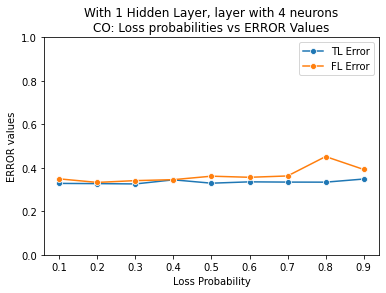

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_4['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_4['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))

plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 1 Hidden Layer, layer with 4 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)

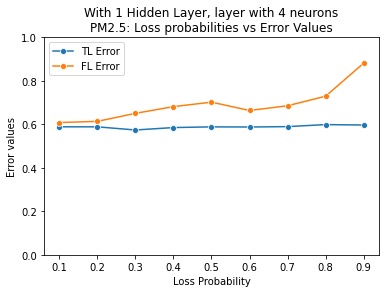

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_4['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_4['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 1 Hidden Layer, layer with 4 neurons\nPM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

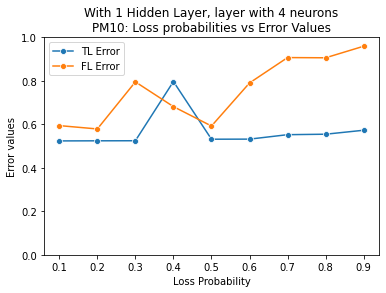

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_4['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_4['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 1 Hidden Layer, layer with 4 neurons\nPM10: Loss probabilities vs Error Values") 
plt.show(ax)

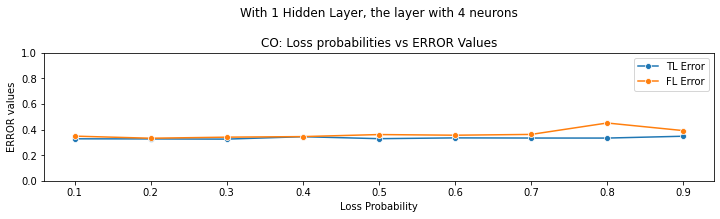

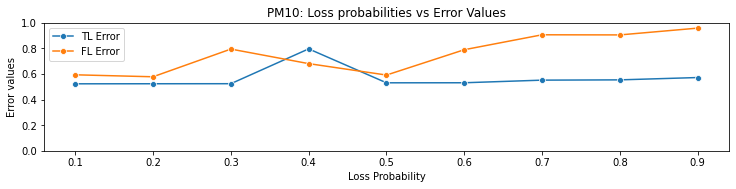

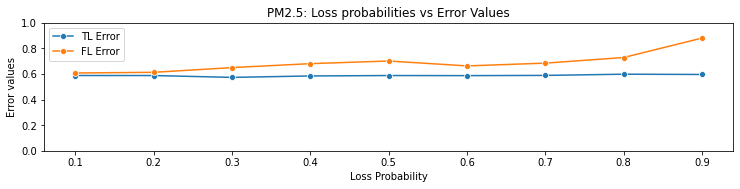

In [ ]:
plt.figure(figsize=(12, 8))
plt.title("With 1 Hidden Layers, each layer with 16 neurons")

plt.subplot(3,1,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_4['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_4['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlim=(0.1, 0.9))
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 1 Hidden Layer, the layer with 4 neurons\n\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)


plt.figure(figsize=(27, 8))
plt.subplot(3,2,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_4['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_4['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM10: Loss probabilities vs Error Values") 
plt.show(ax)


plt.figure(figsize=(42, 8))
plt.subplot(3,3,1)
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_4['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_4['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

## 1 hidden layer
* with 32 neurons

### traditional Learning

In [ ]:
def traditional_ML_1L_32_train(loss_p, gas, train_data):
  # initialize w_0
  model = Sequential()

  # model.add(Dense(64, kernel_initializer='zeros', bias_initializer='zeros', activation=tf.nn.relu, input_dim=6)) # first dense/hidden layer
  model.add(Dense(32, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu, input_dim=8))
  model.add(Dropout(0.1))

  model.add(Dense(1, kernel_initializer= 'he_uniform', activation='linear')) # output layer


  # compile the model
  model.compile(loss='mse', 
              optimizer='adam', 
              metrics=['mse'])
  
  x_train, y_train = train_data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  train_data[gas]

 

  B = 1000 #int(len(x_train) * 0.01) # so for each client the batch size would be different depending upon the total sample size
  E = 25 #max(30, B//10) # number of local epochs; it will also depend on sample size (indirectly)


  model.fit(x_train, y_train, 
                  epochs = E, 
                  batch_size=B,
                  verbose=False)
  
  return model
      


In [ ]:
def traditional_ML_1L_32_test(model_name, gas, test_data):

  ## loading the json and creating model
  json_file = open(model_name + ".json", 'r')
  model_json = json_file.read()
  json_file.close()

  model = model_from_json(model_json)
  model.load_weights(model_name + ".h5")

  ## need to compile the model again after loading
  # compile the model
  model.compile(loss='mse', 
              optimizer='adam', 
              metrics=['mse'])
  

  x_test, y_test = test_data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  test_data[gas]

  x_test, y_test = x_test.to_numpy(), y_test.to_numpy()

  # adjusting the dimensions
  x_test = x_test.reshape(x_test.shape[0], x_test.shape[1])
  y_test = y_test.reshape(y_test.shape[0],1)
  
  y_predicted = model.predict(x_test)
  

  from sklearn.metrics import mean_squared_error
  mse = mean_squared_error(y_predicted.ravel(), y_test.ravel())

  NE = np.sum(abs(np.array(y_test) - np.array(y_predicted))) / np.sum(np.array(y_test))
  return (mse, NE)


In [ ]:
# Final plotting
K = 25 # as we have 25 clients
train_data = pd.DataFrame()
test_data = pd.DataFrame()
loss_prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
gases = ['CO', 	'PM10',	'PM2.5']
errors_tl_h1_32 = {'CO':[], 	'PM10':[],	'PM2.5':[]}
models = []
model_name = "TL_model_1L_32_"


# for gas in gases:
#   for loss_p in loss_prob:
#     error = traditional_ML_L3_32(loss_p, gas)
#     errors_tl_h3_32[gas].append(error)

for gas in gases:
  for lp in loss_prob:
      for st_code in range(101,126):
          # splitting into train test split
          X, y = clients[st_code][['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  clients[st_code][gas]
          x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = lp, random_state=1)

          # Normalization using min-max scaler
          # Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set.
          # to avoid data leak
          scaler_cols = x_train.columns
          scaler_idx_train = x_train.index
          scaler_idx_test = x_test.index

          # from sklearn.preprocessing import MinMaxScaler
          scaler = MinMaxScaler()

          # transforming train data
          x_train_encoded_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns = scaler_cols, index=scaler_idx_train)
          # display(x_train_encoded_scaled.head())

          # transforming test data
          x_test_encoded_scaled = pd.DataFrame(scaler.transform(x_test), columns = scaler_cols, index = scaler_idx_test)
          # display(x_test_encoded_scaled.head())

          # training data prep
          if st_code == 101:
            train_data = pd.concat([x_train_encoded_scaled, y_train], axis = 1)
          else:
            xy = pd.concat([x_train_encoded_scaled, y_train], axis=1)
            train_data = pd.concat([train_data, xy], axis=0)
          # clients_cut[st_code] = pd.concat([x_train_encoded_scaled, y_train], axis = 1)
          

          # testing data prep
          # first appending x_test and y_test column wise
          # then appending each clients' dataframe one below other
          if st_code == 101:
            test_data = pd.concat([x_test_encoded_scaled, y_test], axis = 1)
          else:
            xy = pd.concat([x_test_encoded_scaled, y_test], axis=1)
            test_data = pd.concat([test_data, xy], axis=0)
          # x_test, y_test = x_test.to_numpy(), y_test.to_numpy()
      
      # Training the model using traditional learning
      # model = traditional_ML_1L_32_train(lp, gas, train_data)

      ## Saving model
      ## serializing model to JSON
      model_address = "/content/drive/MyDrive/Colab Notebooks/Models/" + model_name + gas + str(lp) + "_"


      # model_json = model.to_json()
      # with open(model_address + ".json", "w") as json_file:
      #   json_file.write(model_json)

      # # serialize weights to HDF5
      # model.save_weights(model_address + ".h5")


      ## Testing model
      error = traditional_ML_1L_32_test(model_address, gas, train_data)
      errors_tl_h1_32[gas].append(error)
      # testing model
      # errors_fl_h3_32[gas].append(error_clients_L3_32(model, gas))


### Federated Learning

In [ ]:
# ClientUpdate(k, w): // Run on client k
def Client_L1_32(client_idx, model, gas):
    # B ← (split P_k into batches of size B) # what is p_K --> each clients' sample size
    B = 1000 #int(len(clients[client_idx]) * 0.01) # so for each client the batch size would be different depending upon the total sample size
    E = 25 #max(30, B//10) # number of local epochs; it will also depend on sample size (indirectly)

    data = clients_cut[client_idx]
    # data = dataset.loc[dataset['Station code'] == client_idx]

    X, y = data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  data[gas]

    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state=1)

    try:
        model.fit(x_train, y_train, 
                    epochs = E, 
                    batch_size=B,
                    validation_data=(x_val, y_val),
                    verbose=False)
    except Exception as e:
        print(e)
        print("error")

    # return w to server
    # in our case no need for any explicit return; as the model is pass by value
    return data.shape[0] # this will return the number of total sample


In [ ]:
# Server executes: 
def Server_L1_32(gas):
    # initialize w_0
    model = Sequential()
    
    # model.add(Dense(64, kernel_initializer='zeros', bias_initializer='zeros', activation=tf.nn.relu, input_dim=6)) # first dense/hidden layer
    model.add(Dense(32, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu, input_dim=8))
    model.add(Dropout(0.1))

    model.add(Dense(1, kernel_initializer= 'he_uniform', activation='linear')) # output layer


    # compile the model
    model.compile(loss='mse', 
                optimizer='adam', 
                metrics=['mse'])
    

# for each round t = 1, 2, . . . do
    for t in range(1, 5):
        C = np.random.random(1)[0] # random number between 0 and 1.

        # m ← max(C  K, 1)
        m = max(int(C*K), 1) # m == random number of client selected
        weight_t_plus_1 = [None] * m # matrix to store the weights of all client in each t-round
        n_k = [None] * m # parameters for weighted sum 


        # S_t ← (random set of m clients)
        # S = {} # dictionary
        S_t = np.random.uniform(low=101, high=126, size=(m)).astype(int)

        # No need for below loop, as server don't need access to client data, server only need clients' number
        # for client in m_clients:
        #   S[client] = clients[client]

        initial_weights = model.get_weights() # setting initial weights; should be same for all clients
        # for t= 1 to T, initial_weights would be t-1th's final weights

        # for each client k ∈ S_t in parallel do
        client_idx = 0
        for client in S_t:
            # w^(k)_(t+1) ← ClientUpdate(k, model)
            n_k[client_idx] = Client_L1_32(client, model, gas) # pass by reference for model
            weight_t_plus_1[client_idx] = model.get_weights()
            client_idx += 1

            # setting weights back to initial weights
            model.set_weights(initial_weights)

        # finding the weighted sum
        final_weights_t = np.array(weight_t_plus_1[0]) * (n_k[0] / sum(n_k))

        for idx in range(1, m):
          # w_(t+1) ← summation(k=1 to K){(n_k/n) * w^(k)_(t+1)} #n_k - no. of training sample in each client K; n - total training samples;
          final_weights_t += np.array(weight_t_plus_1[idx]) * (n_k[idx]/ sum(n_k))

        # setting the aggregated weights
        model.set_weights(final_weights_t)


#         print(model.get_weights())
    # return error_clients(model, loss_p)) # THIS LINE WON'T BE THERE IN REAL SERVER
    return model

In [ ]:
def error_clients_L1_32(model_name, gas, test_data):

    ## loading the json and creating model
    json_file = open(model_name + ".json", 'r')
    model_json = json_file.read()
    json_file.close()

    model = model_from_json(model_json)
    model.load_weights(model_name + ".h5")

    ## need to compile the model again after loading
    # compile the model
    model.compile(loss='mse', 
                optimizer='adam', 
                metrics=['mse'])
  
    
    X, y = test_data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  test_data[gas]
    
    # adjusting the dimensions
    x_test, y_test = X.to_numpy(), y.to_numpy()
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1])
    y_test = y_test.reshape(y_test.shape[0],1)

    y_predicted = model.predict(x_test)
    
    from sklearn.metrics import mean_squared_error
    # print("y_predicted", y_predicted)
    # print("y_predicted.ravel()", y_predicted.ravel())
    NE = np.sum(abs(np.array(y_test) - np.array(y_predicted))) / np.sum(np.array(y_test))

    mse = mean_squared_error(y_predicted.ravel(), y_test.ravel())
    
    return (mse,NE)

          

In [ ]:

# create an Empty DataFrame object
train_data = pd.DataFrame()
test_data = pd.DataFrame()
loss_prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
models = []
errors_fl_h1_32 = {'CO':[], 	'PM10':[],	'PM2.5':[]}
gases = ['CO', 	'PM10',	'PM2.5']
model_name = "FL_model_1L_32_"


# reading all the clients and building model
for gas in gases:
  for lp in loss_prob:
      for st_code in range(101,126):
          # splitting into train test split
          X, y = clients[st_code][['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  clients[st_code][gas]
          x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = lp, random_state=1)

          # Normalization using min-max scaler
          # Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set.
          # to avoid data leak
          scaler_cols = x_train.columns
          scaler_idx_train = x_train.index
          scaler_idx_test = x_test.index

          # from sklearn.preprocessing import MinMaxScaler
          scaler = MinMaxScaler()

          # transforming train data
          x_train_encoded_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns = scaler_cols, index=scaler_idx_train)
          # display(x_train_encoded_scaled.head())

          # transforming test data
          x_test_encoded_scaled = pd.DataFrame(scaler.transform(x_test), columns = scaler_cols, index = scaler_idx_test)
          # display(x_test_encoded_scaled.head())

          # training data prep
          clients_cut[st_code] = pd.concat([x_train_encoded_scaled, y_train], axis = 1)

          # testing data prep
          # first appending x_test and y_test column wise
          # then appending each clients' dataframe one below other
          if st_code == 101:
            test_data = pd.concat([x_test_encoded_scaled, y_test], axis = 1)
          else:
            xy = pd.concat([x_test_encoded_scaled, y_test], axis=1)
            test_data = pd.concat([test_data, xy], axis=0)
          # x_test, y_test = x_test.to_numpy(), y_test.to_numpy()

      # Training the model using federated learning
      # model = Server_L1_32(gas)

      ## Saving model
      ## serializing model to JSON
      model_address = "/content/drive/MyDrive/Colab Notebooks/Models/" + model_name + gas + str(lp) + "_"


      # model_json = model.to_json()
      # with open(model_address + ".json", "w") as json_file:
      #   json_file.write(model_json)

      # # serialize weights to HDF5
      # model.save_weights(model_address + ".h5")


      ## Testing model
      error = error_clients_L1_32(model_address, gas, test_data)
      errors_fl_h1_32[gas].append(error)


### Plots

#### Original plots

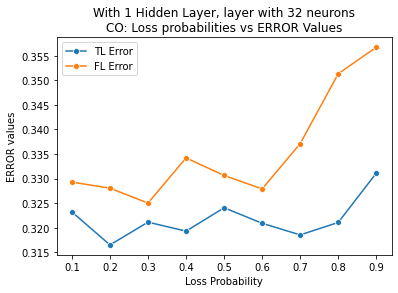

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.2, 0.5))

plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 1 Hidden Layer, layer with 32 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)

In [ ]:
errors_fl_h1_32

{'CO': [(0.1174068104483824, 0.329274006560396),
  (0.12872508589703852, 0.3280419110004532),
  (0.12840561922272758, 0.3250048830523592),
  (0.12888363668303185, 0.33420106167705643),
  (0.12560917146135814, 0.3306265604202242),
  (0.13652565883267584, 0.32789324222942884),
  (0.13472656083642998, 0.3371133652211872),
  (0.15123807415495208, 0.3513307302293734),
  (0.14897217822132466, 0.35672507459616243)],
 'PM10': [(4322.769449431958, 0.54173935071569),
  (5252.509721615433, 0.546509981456708),
  (5328.209853965961, 0.5466273243755179),
  (5327.526356140726, 0.5774530195980055),
  (5233.552149970967, 0.576543911900324),
  (5169.942645316739, 0.5626025915349394),
  (5298.749274107523, 0.5795250835671574),
  (5448.011449990528, 0.5931693301234696),
  (6226.225460200263, 0.7799986509220479)],
 'PM2.5': [(1749.6261638314934, 0.5972503759358719),
  (1816.7684830086903, 0.5729641801800233),
  (1916.1312685357248, 0.6809079531620036),
  (1934.935122943102, 0.6777975661200007),
  (1879.271

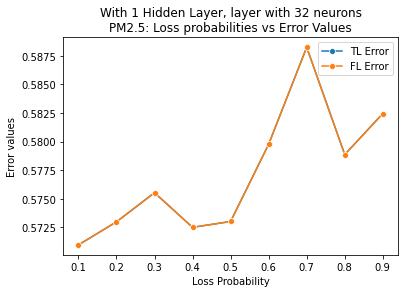

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.96, 0.9625))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 1 Hidden Layer, layer with 32 neurons\nPM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

In [ ]:
# fl_error = pd.DataFrame(columns=['loss_prob', 'PM10'])
# fl_error['loss_prob'] = loss_prob
# fl_error['PM10'] = np.array(errors_fl_h1_32['PM10'])[:,1]
# fl_error['learning'] = 'FL Error'

# tl_error = pd.DataFrame(columns=['loss_prob', 'PM10'])
# tl_error['loss_prob'] = loss_prob
# tl_error['PM10'] = np.array(errors_tl_h1_32['PM10'])[:,1]
# tl_error['learning'] = 'TL Error'

# error_df = pd.concat([fl_error, tl_error], axis=0, ignore_index=True)
# error_df


In [ ]:
errors_tl_h1_32['PM10']

[(5032.464969366498, 0.5063556605191748),
 (4904.911001024232, 0.5084973590991105),
 (4862.404645526567, 0.5152677786052028),
 (4829.448538098522, 0.5115111225263405),
 (4870.249374728376, 0.51501521461146),
 (4985.894884141998, 0.5130527072561452),
 (4821.934187692121, 0.5152233572851759),
 (5089.296635843209, 0.519732793842693),
 (5113.087815345338, 0.5481534696774343)]

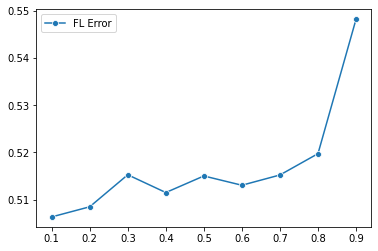

In [ ]:
sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

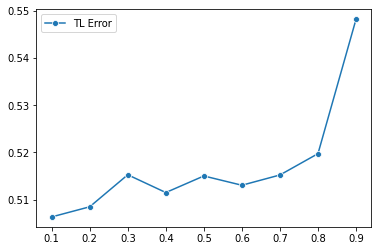

In [ ]:
sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

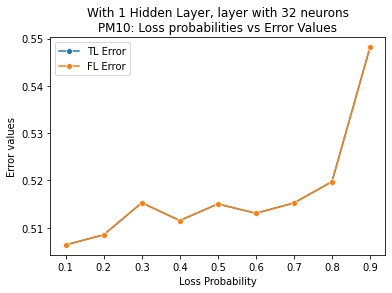

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.977, 0.979))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 1 Hidden Layer, layer with 32 neurons\nPM10: Loss probabilities vs Error Values") 
plt.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/foo.png')
plt.show(ax)


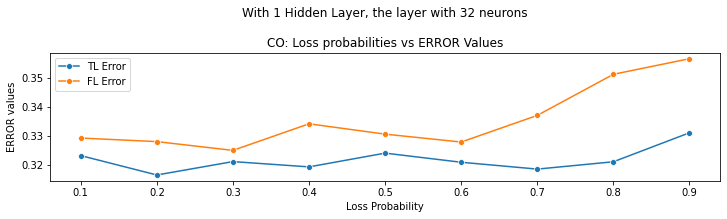

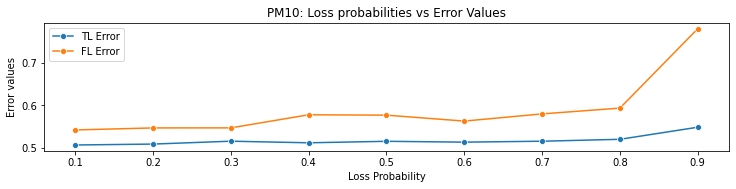

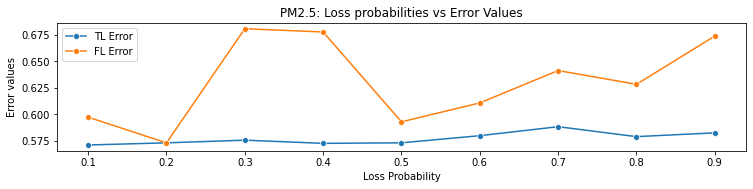

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(3,1,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.2, 0.5))
# ax.set(xlim=(0.1, 0.9))
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)


plt.figure(figsize=(27, 8))
plt.subplot(3,2,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.977, 0.979))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM10: Loss probabilities vs Error Values") 
plt.show(ax)


plt.figure(figsize=(42, 8))
plt.subplot(3,3,1)
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.96, 0.9625))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

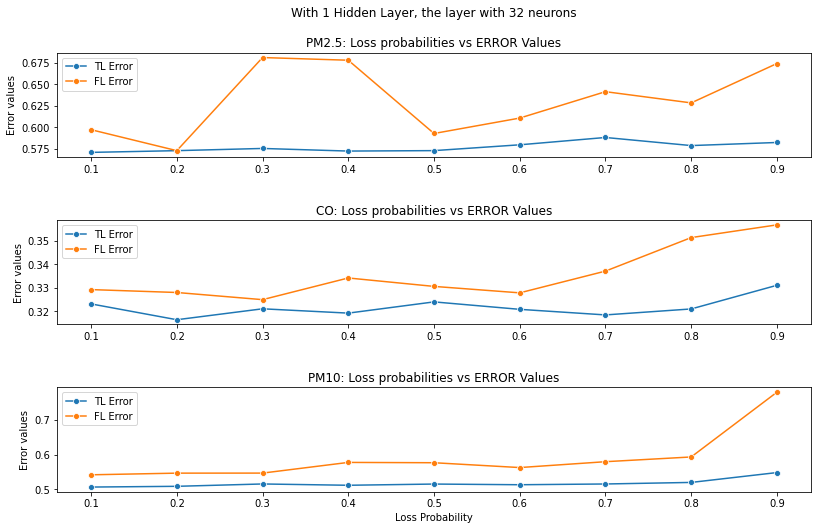

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(12,8))

idx = 0

y_arr = [(np.array(errors_tl_h1_32['PM2.5'])[:,1], np.array(errors_fl_h1_32['PM2.5'])[:,1]), (np.array(errors_tl_h1_32['CO'])[:,1], np.array(errors_fl_h1_32['CO'])[:,1]), 
         (np.array(errors_tl_h1_32['PM10'])[:,1], np.array(errors_fl_h1_32['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("With 1 Hidden Layer, the layer with 32 neurons\n\n{}: Loss probabilities vs ERROR Values".format(gas[row]))
        else:
          axes[row].set_title("{}: Loss probabilities vs ERROR Values".format(gas[row]))

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row])

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error', ax = axes[row])
        
        
        axes[row].set(ylabel='Error values')
        # plt.legend()
        if row == 2:
          axes[row].set(xlabel='Loss Probability', ylabel='Error values')

        
        idx += 1

title = "With 1 Hidden Layer, the layer with 32 neurons"    
fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

#### Customized plots: 0.5

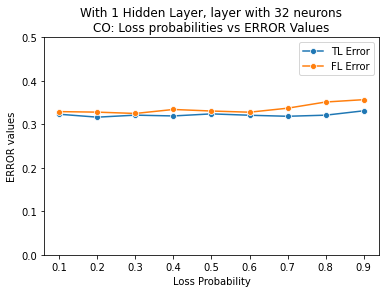

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 0.5))

plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 1 Hidden Layer, layer with 32 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)

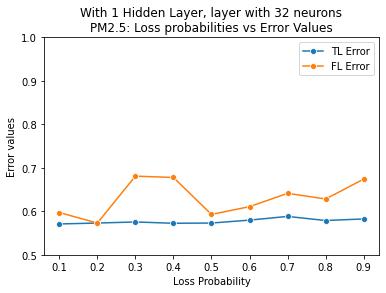

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.5, 1.0))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 1 Hidden Layer, layer with 32 neurons\nPM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

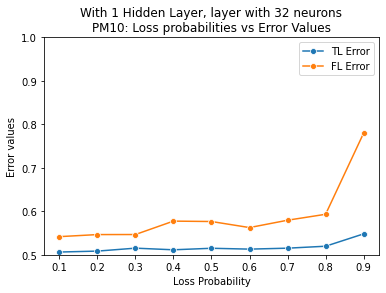

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.5, 1.0))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 1 Hidden Layer, layer with 32 neurons\nPM10: Loss probabilities vs Error Values") 
plt.show(ax)

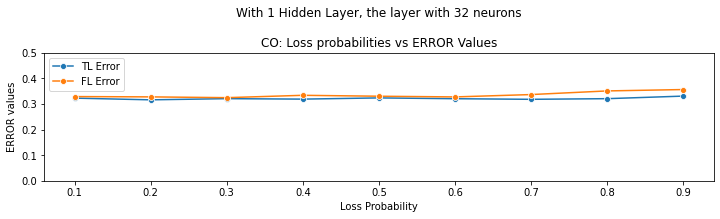

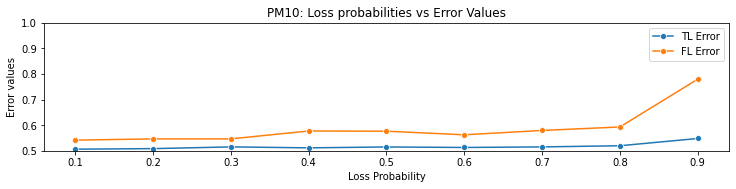

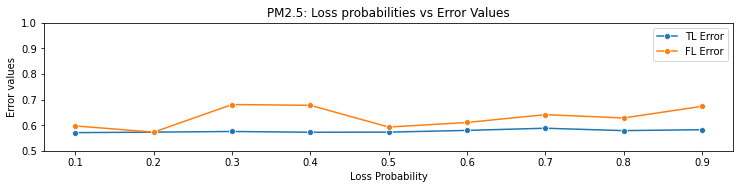

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(3,1,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 0.5))
# ax.set(xlim=(0.1, 0.9))
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)


plt.figure(figsize=(27, 8))
plt.subplot(3,2,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.5, 1.0))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM10: Loss probabilities vs Error Values") 
plt.show(ax)


plt.figure(figsize=(42, 8))
plt.subplot(3,3,1)
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.5, 1.0))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

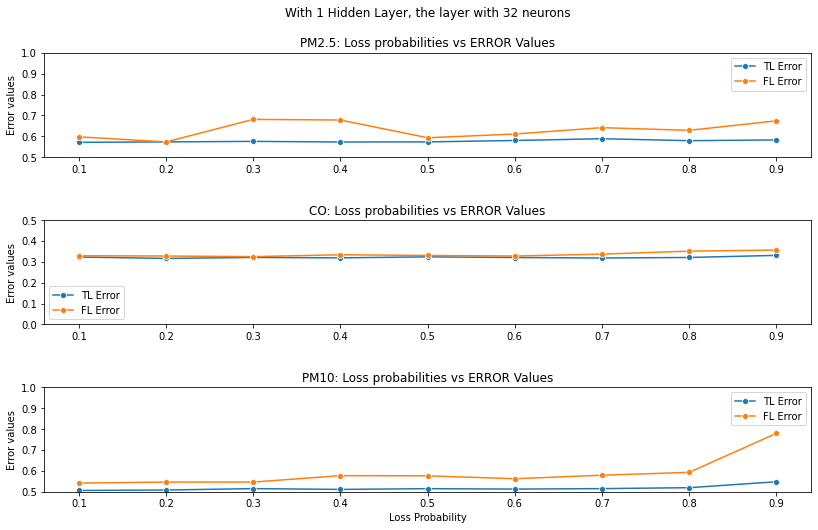

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(12,8))

idx = 0

y_arr = [(np.array(errors_tl_h1_32['PM2.5'])[:,1], np.array(errors_fl_h1_32['PM2.5'])[:,1]), (np.array(errors_tl_h1_32['CO'])[:,1], np.array(errors_fl_h1_32['CO'])[:,1]), 
         (np.array(errors_tl_h1_32['PM10'])[:,1], np.array(errors_fl_h1_32['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("With 1 Hidden Layer, the layer with 32 neurons\n\n{}: Loss probabilities vs ERROR Values".format(gas[row]))
        else:
          axes[row].set_title("{}: Loss probabilities vs ERROR Values".format(gas[row]))

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row])

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error', ax = axes[row])
        
        
        axes[row].set(ylabel='Error values')
        if row == 1:
          axes[row].set(ylim=(0.0, 0.5))
        else:
          axes[row].set(ylim=(0.5, 1.0))
        # plt.legend()
        if row == 2:
          axes[row].set(xlabel='Loss Probability', ylabel='Error values')

        
        idx += 1

title = "With 1 Hidden Layer, the layer with 32 neurons"    
fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

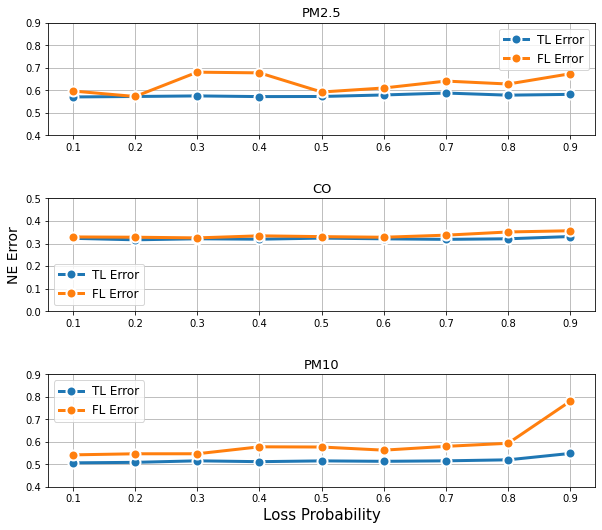

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(9,8))

idx = 0

y_arr = [(np.array(errors_tl_h1_32['PM2.5'])[:,1], np.array(errors_fl_h1_32['PM2.5'])[:,1]), (np.array(errors_tl_h1_32['CO'])[:,1], np.array(errors_fl_h1_32['CO'])[:,1]), 
         (np.array(errors_tl_h1_32['PM10'])[:,1], np.array(errors_fl_h1_32['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("{}".format(gas[row]), fontsize=13)
        else:
          axes[row].set_title("{}".format(gas[row]), fontsize=13)

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row], linewidth=3, ms='10', mew='2')

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error', ax = axes[row], linewidth=3, ms='10', mew='2')
        
        axes[row].legend(fontsize=12)
        axes[row].grid(True)
        
        if row == 1:
          axes[row].set(ylim=(0.0, 0.5))
          axes[row].set_ylabel('NE Error', fontsize=14)
        else:
          axes[row].set(ylim=(0.4, 0.9))

        if row == 2:
          pass
          # axes[row].set(xlabel='Loss Probability', fontsize=14)

        
        idx += 1
plt.xlabel("Loss Probability", fontsize=15)
# plt.ylabel("NE Error Values", loc='center', fontsize=15)
# title = "With 1 Hidden Layer, the layer with 64 neurons"    
# fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

#### Customized plots: 1.0

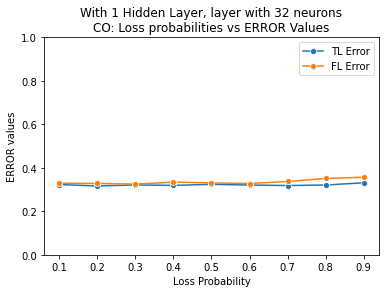

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))

plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 1 Hidden Layer, layer with 32 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)

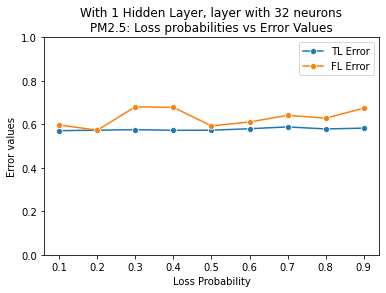

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 1 Hidden Layer, layer with 32 neurons\nPM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

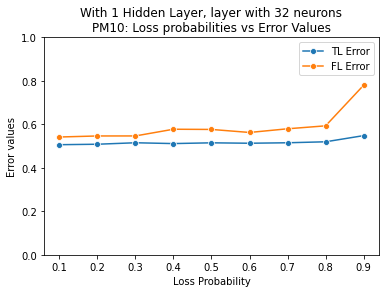

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 1 Hidden Layer, layer with 32 neurons\nPM10: Loss probabilities vs Error Values") 
plt.show(ax)

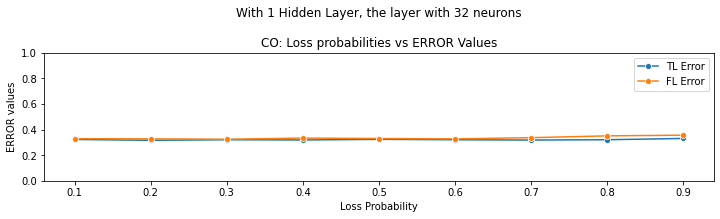

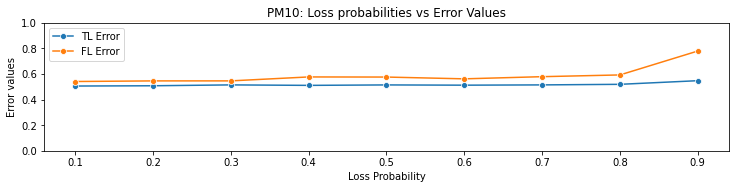

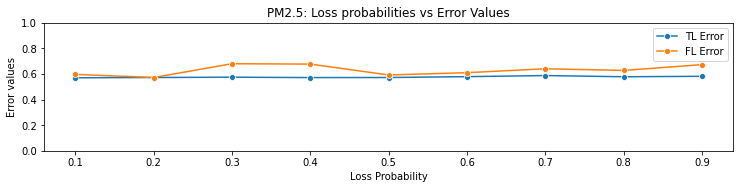

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(3,1,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlim=(0.1, 0.9))
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)


plt.figure(figsize=(27, 8))
plt.subplot(3,2,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM10: Loss probabilities vs Error Values") 
plt.show(ax)


plt.figure(figsize=(42, 8))
plt.subplot(3,3,1)
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

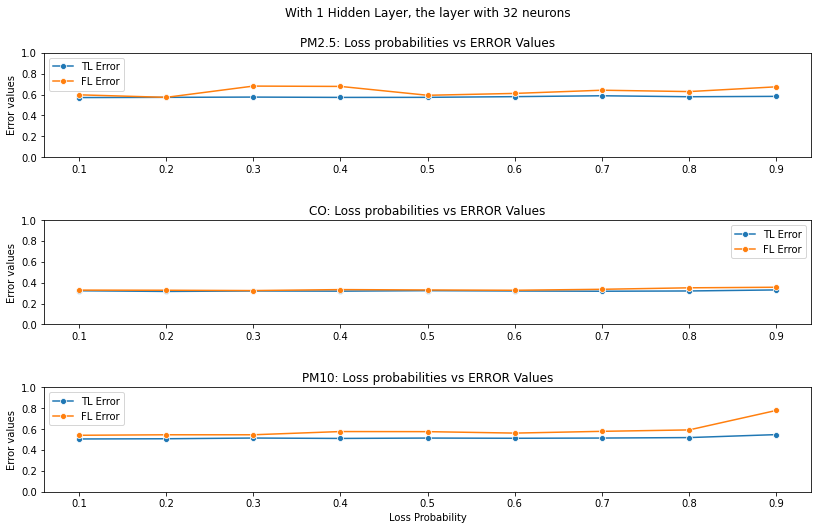

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(12,8))

idx = 0

y_arr = [(np.array(errors_tl_h1_32['PM2.5'])[:,1], np.array(errors_fl_h1_32['PM2.5'])[:,1]), (np.array(errors_tl_h1_32['CO'])[:,1], np.array(errors_fl_h1_32['CO'])[:,1]), 
         (np.array(errors_tl_h1_32['PM10'])[:,1], np.array(errors_fl_h1_32['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("With 1 Hidden Layer, the layer with 32 neurons\n\n{}: Loss probabilities vs ERROR Values".format(gas[row]))
        else:
          axes[row].set_title("{}: Loss probabilities vs ERROR Values".format(gas[row]))

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row])

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error', ax = axes[row])
        
        
        axes[row].set(ylabel='Error values')
        axes[row].set(ylim=(0.0, 1.0))

        # plt.legend()
        if row == 2:
          axes[row].set(xlabel='Loss Probability', ylabel='Error values')
        
        idx += 1

title = "With 1 Hidden Layer, the layer with 32 neurons"    
fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

## 1 hidden layer
* with 64 neurons

### traditional Learning

In [ ]:
def traditional_ML_1L_64_train(loss_p, gas, train_data):
  # initialize w_0
  model = Sequential()

  # model.add(Dense(64, kernel_initializer='zeros', bias_initializer='zeros', activation=tf.nn.relu, input_dim=6)) # first dense/hidden layer
  model.add(Dense(64, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu, input_dim=8))
  model.add(Dropout(0.1))

  model.add(Dense(1, kernel_initializer= 'he_uniform', activation='linear')) # output layer


  # compile the model
  model.compile(loss='mse', 
              optimizer='adam', 
              metrics=['mse'])
  
  x_train, y_train = train_data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  train_data[gas]

 

  B = 1000 #int(len(x_train) * 0.01) # so for each client the batch size would be different depending upon the total sample size
  E = 25 #max(30, B//10) # number of local epochs; it will also depend on sample size (indirectly)


  model.fit(x_train, y_train, 
                  epochs = E, 
                  batch_size=B,
                  verbose=False)
  
  return model
      


In [ ]:
def traditional_ML_1L_64_test(model_name, gas, test_data):

  ## loading the json and creating model
  json_file = open(model_name + ".json", 'r')
  model_json = json_file.read()
  json_file.close()

  model = model_from_json(model_json)
  model.load_weights(model_name + ".h5")

  ## need to compile the model again after loading
  # compile the model
  model.compile(loss='mse', 
              optimizer='adam', 
              metrics=['mse'])
  

  x_test, y_test = test_data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  test_data[gas]

  x_test, y_test = x_test.to_numpy(), y_test.to_numpy()

  # adjusting the dimensions
  x_test = x_test.reshape(x_test.shape[0], x_test.shape[1])
  y_test = y_test.reshape(y_test.shape[0],1)
  
  y_predicted = model.predict(x_test)
  

  from sklearn.metrics import mean_squared_error
  mse = mean_squared_error(y_predicted.ravel(), y_test.ravel())

  NE = np.sum(abs(np.array(y_test) - np.array(y_predicted))) / np.sum(np.array(y_test))
  return (mse, NE)


In [ ]:
# Final plotting
K = 25 # as we have 25 clients
train_data = pd.DataFrame()
test_data = pd.DataFrame()
loss_prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
gases = ['CO', 	'PM10',	'PM2.5']
errors_tl_h1_64 = {'CO':[], 	'PM10':[],	'PM2.5':[]}
models = []
model_name = "TL_model_1L_64_"


# for gas in gases:
#   for loss_p in loss_prob:
#     error = traditional_ML_L3_32(loss_p, gas)
#     errors_tl_h3_32[gas].append(error)

for gas in gases:
  for lp in loss_prob:
      for st_code in range(101,126):
          # splitting into train test split
          X, y = clients[st_code][['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  clients[st_code][gas]
          x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = lp, random_state=1)

          # Normalization using min-max scaler
          # Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set.
          # to avoid data leak
          scaler_cols = x_train.columns
          scaler_idx_train = x_train.index
          scaler_idx_test = x_test.index

          # from sklearn.preprocessing import MinMaxScaler
          scaler = MinMaxScaler()

          # transforming train data
          x_train_encoded_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns = scaler_cols, index=scaler_idx_train)
          # display(x_train_encoded_scaled.head())

          # transforming test data
          x_test_encoded_scaled = pd.DataFrame(scaler.transform(x_test), columns = scaler_cols, index = scaler_idx_test)
          # display(x_test_encoded_scaled.head())

          # training data prep
          if st_code == 101:
            train_data = pd.concat([x_train_encoded_scaled, y_train], axis = 1)
          else:
            xy = pd.concat([x_train_encoded_scaled, y_train], axis=1)
            train_data = pd.concat([train_data, xy], axis=0)
          # clients_cut[st_code] = pd.concat([x_train_encoded_scaled, y_train], axis = 1)
          

          # testing data prep
          # first appending x_test and y_test column wise
          # then appending each clients' dataframe one below other
          if st_code == 101:
            test_data = pd.concat([x_test_encoded_scaled, y_test], axis = 1)
          else:
            xy = pd.concat([x_test_encoded_scaled, y_test], axis=1)
            test_data = pd.concat([test_data, xy], axis=0)
          # x_test, y_test = x_test.to_numpy(), y_test.to_numpy()
      
      # Training the model using traditional learning
      # model = traditional_ML_1L_64_train(lp, gas, train_data)

      ## Saving model
      ## serializing model to JSON
      model_address = "/content/drive/MyDrive/Colab Notebooks/Models/" + model_name + gas + str(lp) + "_"


      # model_json = model.to_json()
      # with open(model_address + ".json", "w") as json_file:
      #   json_file.write(model_json)

      # # serialize weights to HDF5
      # model.save_weights(model_address + ".h5")


      ## Testing model
      error = traditional_ML_1L_64_test(model_address, gas, train_data)
      errors_tl_h1_64[gas].append(error)
      # testing model
      # errors_fl_h3_32[gas].append(error_clients_L3_32(model, gas))


### Federated Learning

In [ ]:
# ClientUpdate(k, w): // Run on client k
def Client_L1_64(client_idx, model, gas):
    # B ← (split P_k into batches of size B) # what is p_K --> each clients' sample size
    B = 1000 #int(len(clients[client_idx]) * 0.01) # so for each client the batch size would be different depending upon the total sample size
    E = 25 #max(30, B//10) # number of local epochs; it will also depend on sample size (indirectly)

    data = clients_cut[client_idx]
    # data = dataset.loc[dataset['Station code'] == client_idx]

    X, y = data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  data[gas]

    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state=1)

    try:
        model.fit(x_train, y_train, 
                    epochs = E, 
                    batch_size=B,
                    validation_data=(x_val, y_val),
                    verbose=False)
    except Exception as e:
        print(e)
        print("error")

    # return w to server
    # in our case no need for any explicit return; as the model is pass by value
    return data.shape[0] # this will return the number of total sample


In [ ]:
# Server executes: 
def Server_L1_64(gas):
    # initialize w_0
    model = Sequential()
    
    # model.add(Dense(64, kernel_initializer='zeros', bias_initializer='zeros', activation=tf.nn.relu, input_dim=6)) # first dense/hidden layer
    model.add(Dense(64, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu, input_dim=8))
    model.add(Dropout(0.1))

    model.add(Dense(1, kernel_initializer= 'he_uniform', activation='linear')) # output layer


    # compile the model
    model.compile(loss='mse', 
                optimizer='adam', 
                metrics=['mse'])
    

# for each round t = 1, 2, . . . do
    for t in range(1, 5):
        C = np.random.random(1)[0] # random number between 0 and 1.

        # m ← max(C  K, 1)
        m = max(int(C*K), 1) # m == random number of client selected
        weight_t_plus_1 = [None] * m # matrix to store the weights of all client in each t-round
        n_k = [None] * m # parameters for weighted sum 


        # S_t ← (random set of m clients)
        # S = {} # dictionary
        S_t = np.random.uniform(low=101, high=126, size=(m)).astype(int)

        # No need for below loop, as server don't need access to client data, server only need clients' number
        # for client in m_clients:
        #   S[client] = clients[client]

        initial_weights = model.get_weights() # setting initial weights; should be same for all clients
        # for t= 1 to T, initial_weights would be t-1th's final weights

        # for each client k ∈ S_t in parallel do
        client_idx = 0
        for client in S_t:
            # w^(k)_(t+1) ← ClientUpdate(k, model)
            n_k[client_idx] = Client_L1_64(client, model, gas) # pass by reference for model
            weight_t_plus_1[client_idx] = model.get_weights()
            client_idx += 1

            # setting weights back to initial weights
            model.set_weights(initial_weights)

        # finding the weighted sum
        final_weights_t = np.array(weight_t_plus_1[0]) * (n_k[0] / sum(n_k))

        for idx in range(1, m):
          # w_(t+1) ← summation(k=1 to K){(n_k/n) * w^(k)_(t+1)} #n_k - no. of training sample in each client K; n - total training samples;
          final_weights_t += np.array(weight_t_plus_1[idx]) * (n_k[idx]/ sum(n_k))

        # setting the aggregated weights
        model.set_weights(final_weights_t)


#         print(model.get_weights())
    # return error_clients(model, loss_p)) # THIS LINE WON'T BE THERE IN REAL SERVER
    return model

In [ ]:
def error_clients_L1_64(model_name, gas, test_data):

    ## loading the json and creating model
    json_file = open(model_name + ".json", 'r')
    model_json = json_file.read()
    json_file.close()

    model = model_from_json(model_json)
    model.load_weights(model_name + ".h5")

    ## need to compile the model again after loading
    # compile the model
    model.compile(loss='mse', 
                optimizer='adam', 
                metrics=['mse'])
  
    
    X, y = test_data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  test_data[gas]
    
    # adjusting the dimensions
    x_test, y_test = X.to_numpy(), y.to_numpy()
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1])
    y_test = y_test.reshape(y_test.shape[0],1)

    y_predicted = model.predict(x_test)
    
    from sklearn.metrics import mean_squared_error
    # print("y_predicted", y_predicted)
    # print("y_predicted.ravel()", y_predicted.ravel())
    NE = np.sum(abs(np.array(y_test) - np.array(y_predicted))) / np.sum(np.array(y_test))

    mse = mean_squared_error(y_predicted.ravel(), y_test.ravel())
    
    return (mse,NE)

          

In [ ]:

# create an Empty DataFrame object
train_data = pd.DataFrame()
test_data = pd.DataFrame()
loss_prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
models = []
errors_fl_h1_64 = {'CO':[], 	'PM10':[],	'PM2.5':[]}
gases = ['CO', 	'PM10',	'PM2.5']
model_name = "FL_model_1L_64_"


# reading all the clients and building model
for gas in gases:
  for lp in loss_prob:
      for st_code in range(101,126):
          # splitting into train test split
          X, y = clients[st_code][['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  clients[st_code][gas]
          x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = lp, random_state=1)

          # Normalization using min-max scaler
          # Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set.
          # to avoid data leak
          scaler_cols = x_train.columns
          scaler_idx_train = x_train.index
          scaler_idx_test = x_test.index

          # from sklearn.preprocessing import MinMaxScaler
          scaler = MinMaxScaler()

          # transforming train data
          x_train_encoded_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns = scaler_cols, index=scaler_idx_train)
          # display(x_train_encoded_scaled.head())

          # transforming test data
          x_test_encoded_scaled = pd.DataFrame(scaler.transform(x_test), columns = scaler_cols, index = scaler_idx_test)
          # display(x_test_encoded_scaled.head())

          # training data prep
          clients_cut[st_code] = pd.concat([x_train_encoded_scaled, y_train], axis = 1)

          # testing data prep
          # first appending x_test and y_test column wise
          # then appending each clients' dataframe one below other
          if st_code == 101:
            test_data = pd.concat([x_test_encoded_scaled, y_test], axis = 1)
          else:
            xy = pd.concat([x_test_encoded_scaled, y_test], axis=1)
            test_data = pd.concat([test_data, xy], axis=0)
          # x_test, y_test = x_test.to_numpy(), y_test.to_numpy()

      # Training the model using federated learning
      # model = Server_L1_64(gas)

      ## Saving model
      ## serializing model to JSON
      model_address = "/content/drive/MyDrive/Colab Notebooks/Models/" + model_name + gas + str(lp) + "_"


      # model_json = model.to_json()
      # with open(model_address + ".json", "w") as json_file:
      #   json_file.write(model_json)

      # # serialize weights to HDF5
      # model.save_weights(model_address + ".h5")


      ## Testing model
      error = error_clients_L1_64(model_address, gas, test_data)
      errors_fl_h1_64[gas].append(error)


### Plots

#### Original plots

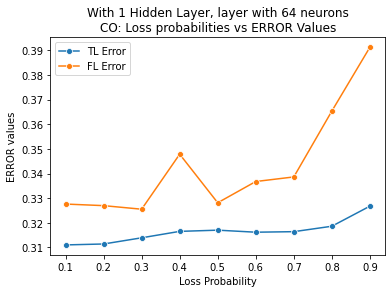

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.2, 0.5))

plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 1 Hidden Layer, layer with 64 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)

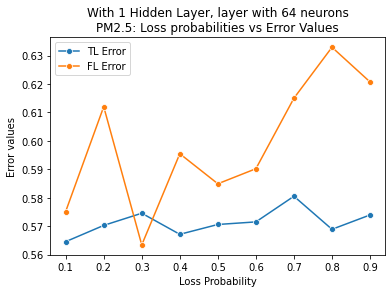

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.96, 0.9625))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 1 Hidden Layer, layer with 64 neurons\nPM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

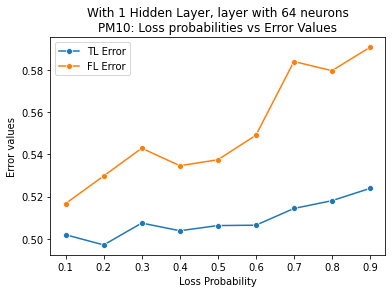

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.977, 0.979))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 1 Hidden Layer, layer with 64 neurons\nPM10: Loss probabilities vs Error Values") 
plt.show(ax)

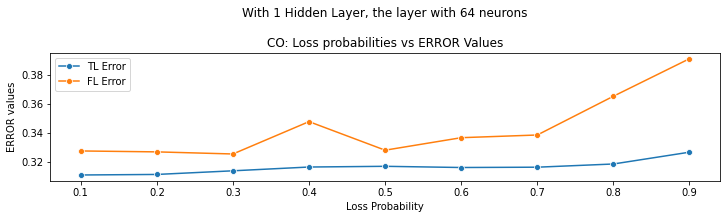

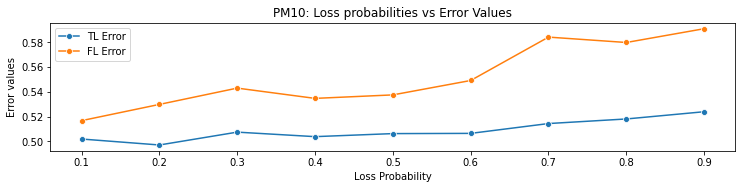

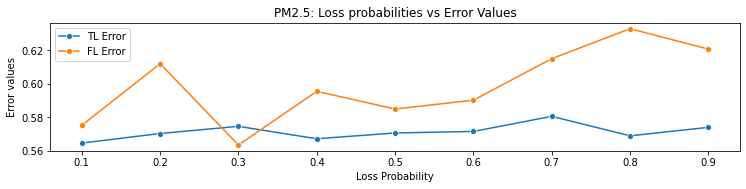

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(3,1,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.2, 0.5))
# ax.set(xlim=(0.1, 0.9))
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 1 Hidden Layer, the layer with 64 neurons\n\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)


plt.figure(figsize=(27, 8))
plt.subplot(3,2,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.977, 0.979))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM10: Loss probabilities vs Error Values") 
plt.show(ax)


plt.figure(figsize=(42, 8))
plt.subplot(3,3,1)
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.96, 0.9625))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

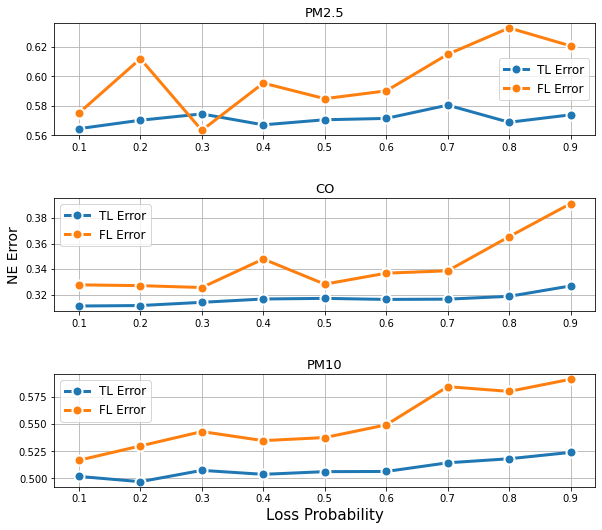

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(9,8))

idx = 0

y_arr = [(np.array(errors_tl_h1_64['PM2.5'])[:,1], np.array(errors_fl_h1_64['PM2.5'])[:,1]), (np.array(errors_tl_h1_64['CO'])[:,1], np.array(errors_fl_h1_64['CO'])[:,1]), 
         (np.array(errors_tl_h1_64['PM10'])[:,1], np.array(errors_fl_h1_64['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("{}".format(gas[row]), fontsize=13)
        else:
          axes[row].set_title("{}".format(gas[row]), fontsize=13)

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row], linewidth=3, ms='10', mew='2')

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error', ax = axes[row], linewidth=3, ms='10', mew='2')
        
        axes[row].legend(fontsize=12)
        axes[row].grid(True)
        
        if row == 1:
          axes[row].set_ylabel('NE Error', fontsize=14)

        if row == 2:
          pass
          # axes[row].set(xlabel='Loss Probability', fontsize=14)

        
        idx += 1
plt.xlabel("Loss Probability", fontsize=15)
# plt.ylabel("NE Error Values", loc='center', fontsize=15)
title = "With 1 Hidden Layer, the layer with 64 neurons"    
fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

#### Customized plots: 0.5

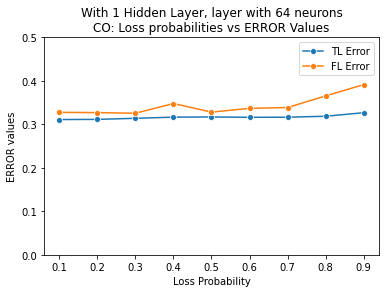

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 0.5))

plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 1 Hidden Layer, layer with 64 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)

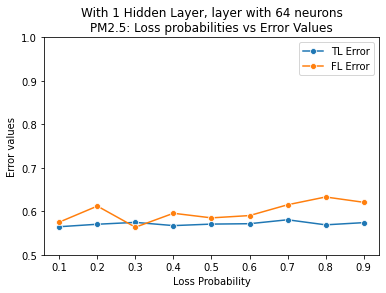

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.5, 1.0))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 1 Hidden Layer, layer with 64 neurons\nPM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

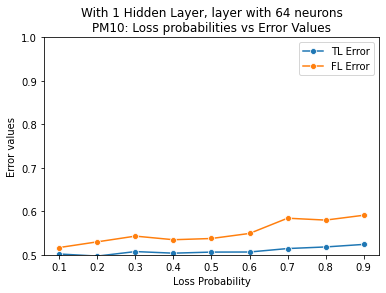

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.5, 1.0))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 1 Hidden Layer, layer with 64 neurons\nPM10: Loss probabilities vs Error Values") 
plt.show(ax)

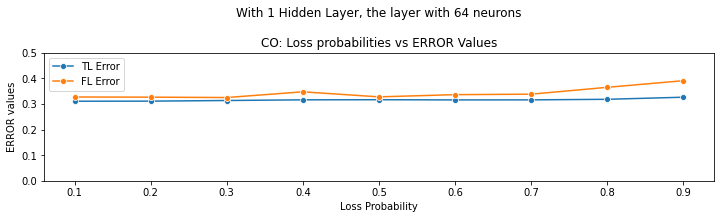

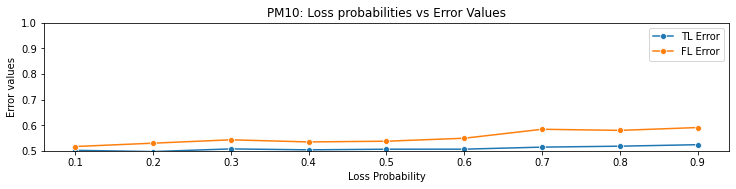

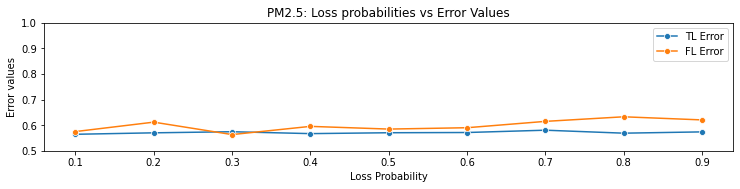

In [ ]:
plt.figure(figsize=(12, 8))
plt.title("With 1 Hidden Layers, each layer with 16 neurons")

plt.subplot(3,1,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 0.5))
# ax.set(xlim=(0.1, 0.9))
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 1 Hidden Layer, the layer with 64 neurons\n\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)


plt.figure(figsize=(27, 8))
plt.subplot(3,2,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.5, 1.0))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM10: Loss probabilities vs Error Values") 
plt.show(ax)


plt.figure(figsize=(42, 8))
plt.subplot(3,3,1)
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.5, 1.0))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

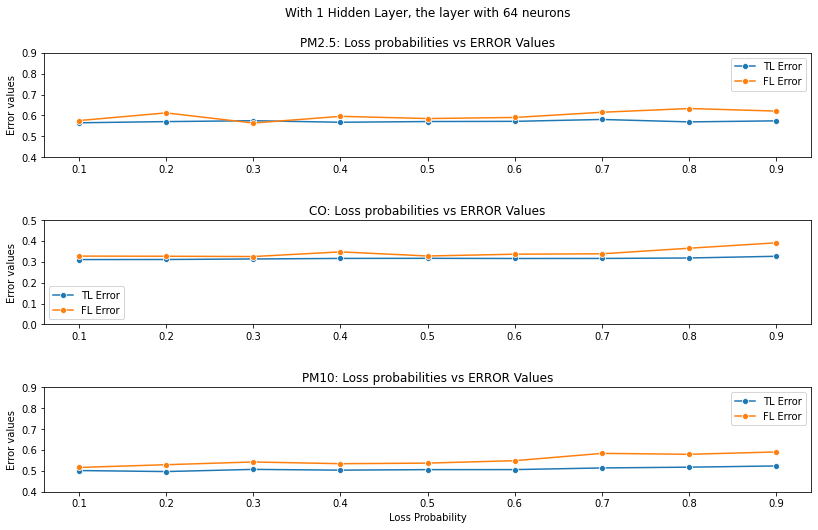

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(12,8))

idx = 0

y_arr = [(np.array(errors_tl_h1_64['PM2.5'])[:,1], np.array(errors_fl_h1_64['PM2.5'])[:,1]), (np.array(errors_tl_h1_64['CO'])[:,1], np.array(errors_fl_h1_64['CO'])[:,1]), 
         (np.array(errors_tl_h1_64['PM10'])[:,1], np.array(errors_fl_h1_64['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("With 1 Hidden Layer, the layer with 64 neurons\n\n{}: Loss probabilities vs ERROR Values".format(gas[row]))
        else:
          axes[row].set_title("{}: Loss probabilities vs ERROR Values".format(gas[row]))

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row])

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error', ax = axes[row])
        
        
        axes[row].set(ylabel='Error values')
        if row == 1:
          axes[row].set(ylim=(0.0, 0.5))
        else:
          axes[row].set(ylim=(0.4, 0.9))
        # plt.legend()
        if row == 2:
          axes[row].set(xlabel='Loss Probability', ylabel='Error values')

        
        idx += 1

title = "With 1 Hidden Layer, the layer with 64 neurons"    
fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

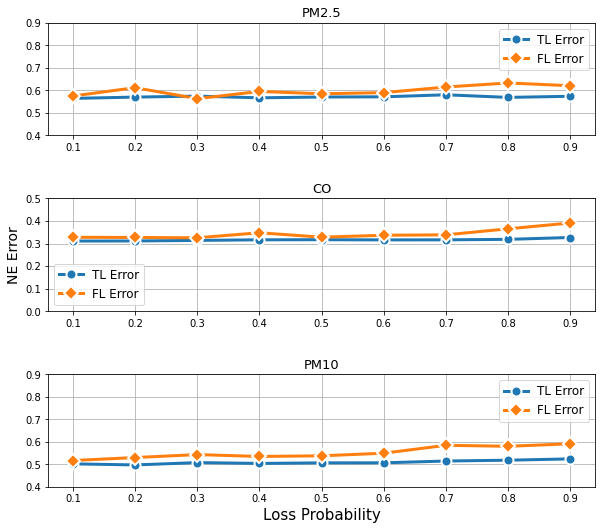

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(9,8))

idx = 0

y_arr = [(np.array(errors_tl_h1_64['PM2.5'])[:,1], np.array(errors_fl_h1_64['PM2.5'])[:,1]), (np.array(errors_tl_h1_64['CO'])[:,1], np.array(errors_fl_h1_64['CO'])[:,1]), 
         (np.array(errors_tl_h1_64['PM10'])[:,1], np.array(errors_fl_h1_64['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("{}".format(gas[row]), fontsize=13)
        else:
          axes[row].set_title("{}".format(gas[row]), fontsize=13)

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row], linewidth=3, ms='10', mew='2')

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="D", dashes=False, label = 'FL Error', ax = axes[row], linewidth=3, ms='10', mew='2')
        
        axes[row].legend(fontsize=12)
        axes[row].grid(True)
        
        if row == 1:
          axes[row].set(ylim=(0.0, 0.5))
          axes[row].set_ylabel('NE Error', fontsize=14)
        else:
          axes[row].set(ylim=(0.4, 0.9))

        if row == 2:
          pass
          # axes[row].set(xlabel='Loss Probability', fontsize=14)

        
        idx += 1
plt.xlabel("Loss Probability", fontsize=15)
# plt.ylabel("NE Error Values", loc='center', fontsize=15)
title = "With 1 Hidden Layer, the layer with 64 neurons"    
fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

#### Customized plots: 1.0

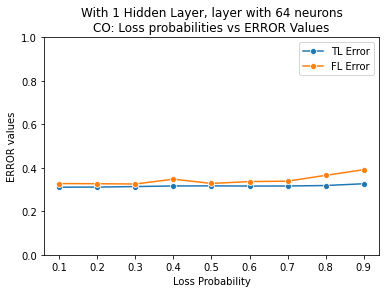

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))

plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 1 Hidden Layer, layer with 64 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)

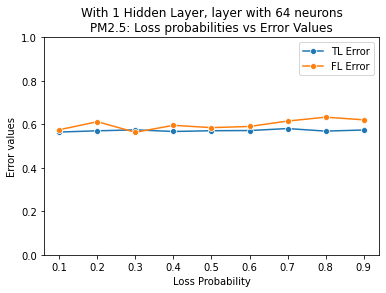

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 1 Hidden Layer, layer with 64 neurons\nPM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

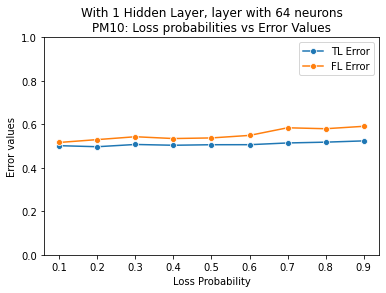

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 1 Hidden Layer, layer with 64 neurons\nPM10: Loss probabilities vs Error Values") 
plt.show(ax)

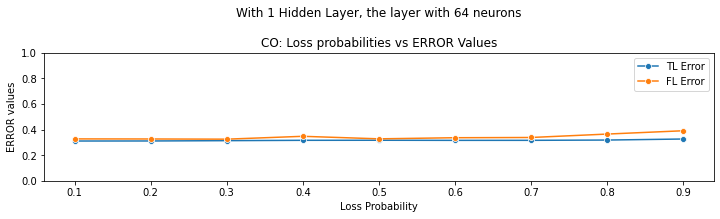

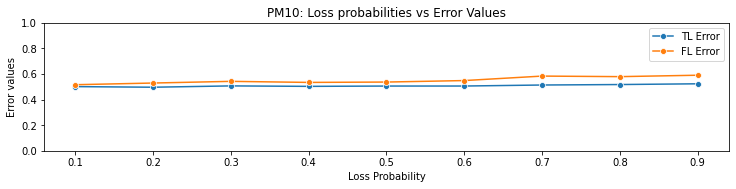

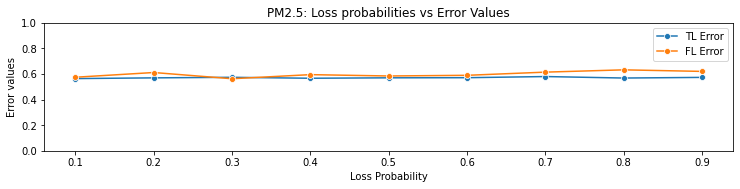

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(3,1,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlim=(0.1, 0.9))
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 1 Hidden Layer, the layer with 64 neurons\n\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)


plt.figure(figsize=(27, 8))
plt.subplot(3,2,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM10: Loss probabilities vs Error Values") 
plt.show(ax)


plt.figure(figsize=(42, 8))
plt.subplot(3,3,1)
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

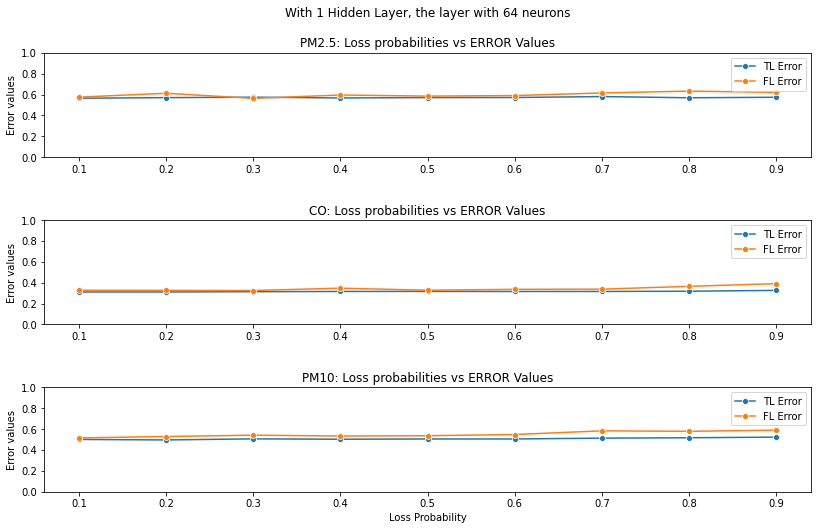

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(12,8))

idx = 0

y_arr = [(np.array(errors_tl_h1_64['PM2.5'])[:,1], np.array(errors_fl_h1_64['PM2.5'])[:,1]), (np.array(errors_tl_h1_64['CO'])[:,1], np.array(errors_fl_h1_64['CO'])[:,1]), 
         (np.array(errors_tl_h1_64['PM10'])[:,1], np.array(errors_fl_h1_64['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("With 1 Hidden Layer, the layer with 64 neurons\n\n{}: Loss probabilities vs ERROR Values".format(gas[row]))
        else:
          axes[row].set_title("{}: Loss probabilities vs ERROR Values".format(gas[row]))

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row])

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error', ax = axes[row])
        
        
        axes[row].set(ylabel='Error values')
        axes[row].set(ylim=(0.0, 1.0))
        # plt.legend()
        if row == 2:
          axes[row].set(xlabel='Loss Probability', ylabel='Error values')

        
        idx += 1

title = "With 1 Hidden Layer, the layer with 64 neurons"    
fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

## 2 hidden layer
* with 32 neurons

### traditional Learning

In [ ]:
def traditional_ML_2L_32_train(loss_p, gas, train_data):
  # initialize w_0
  model = Sequential()

  model.add(Dense(32, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu, input_dim=8))
  model.add(Dropout(0.1))

  model.add(Dense(32, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu))
  model.add(Dropout(0.1))

  model.add(Dense(1, kernel_initializer= 'he_uniform', activation='linear')) # output layer


  # compile the model
  model.compile(loss='mse', 
              optimizer='adam', 
              metrics=['mse'])
  
  x_train, y_train = train_data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  train_data[gas]

 

  B = 1000 #int(len(x_train) * 0.01) # so for each client the batch size would be different depending upon the total sample size
  E = 25 #max(30, B//10) # number of local epochs; it will also depend on sample size (indirectly)


  model.fit(x_train, y_train, 
                  epochs = E, 
                  batch_size=B,
                  verbose=False)
  
  return model
      


In [ ]:
def traditional_ML_2L_32_test(model_name, gas, test_data):

  ## loading the json and creating model
  json_file = open(model_name + ".json", 'r')
  model_json = json_file.read()
  json_file.close()

  model = model_from_json(model_json)
  model.load_weights(model_name + ".h5")

  ## need to compile the model again after loading
  # compile the model
  model.compile(loss='mse', 
              optimizer='adam', 
              metrics=['mse'])
  

  x_test, y_test = test_data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  test_data[gas]

  x_test, y_test = x_test.to_numpy(), y_test.to_numpy()

  # adjusting the dimensions
  x_test = x_test.reshape(x_test.shape[0], x_test.shape[1])
  y_test = y_test.reshape(y_test.shape[0],1)
  
  y_predicted = model.predict(x_test)
  

  from sklearn.metrics import mean_squared_error
  mse = mean_squared_error(y_predicted.ravel(), y_test.ravel())

  NE = np.sum(abs(np.array(y_test) - np.array(y_predicted))) / np.sum(np.array(y_test))
  return (mse, NE)


In [ ]:
# Final plotting
K = 25 # as we have 25 clients
train_data = pd.DataFrame()
test_data = pd.DataFrame()
loss_prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
gases = ['CO', 	'PM10',	'PM2.5']
errors_tl_h2_32 = {'CO':[], 	'PM10':[],	'PM2.5':[]}
models = []
model_name = "TL_model_2L_32_"


# for gas in gases:
#   for loss_p in loss_prob:
#     error = traditional_ML_L3_32(loss_p, gas)
#     errors_tl_h3_32[gas].append(error)

for gas in gases:
  for lp in loss_prob:
      for st_code in range(101,126):
          # splitting into train test split
          X, y = clients[st_code][['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  clients[st_code][gas]
          x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = lp, random_state=1)

          # Normalization using min-max scaler
          # Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set.
          # to avoid data leak
          scaler_cols = x_train.columns
          scaler_idx_train = x_train.index
          scaler_idx_test = x_test.index

          # from sklearn.preprocessing import MinMaxScaler
          scaler = MinMaxScaler()

          # transforming train data
          x_train_encoded_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns = scaler_cols, index=scaler_idx_train)
          # display(x_train_encoded_scaled.head())

          # transforming test data
          x_test_encoded_scaled = pd.DataFrame(scaler.transform(x_test), columns = scaler_cols, index = scaler_idx_test)
          # display(x_test_encoded_scaled.head())

          # training data prep
          if st_code == 101:
            train_data = pd.concat([x_train_encoded_scaled, y_train], axis = 1)
          else:
            xy = pd.concat([x_train_encoded_scaled, y_train], axis=1)
            train_data = pd.concat([train_data, xy], axis=0)
          # clients_cut[st_code] = pd.concat([x_train_encoded_scaled, y_train], axis = 1)
          

          # testing data prep
          # first appending x_test and y_test column wise
          # then appending each clients' dataframe one below other
          if st_code == 101:
            test_data = pd.concat([x_test_encoded_scaled, y_test], axis = 1)
          else:
            xy = pd.concat([x_test_encoded_scaled, y_test], axis=1)
            test_data = pd.concat([test_data, xy], axis=0)
          # x_test, y_test = x_test.to_numpy(), y_test.to_numpy()
      
      # Training the model using traditional learning
      # model = traditional_ML_2L_32_train(lp, gas, train_data)

      ## Saving model
      ## serializing model to JSON
      model_address = "/content/drive/MyDrive/Colab Notebooks/Models/" + model_name + gas + str(lp) + "_"


      # model_json = model.to_json()
      # with open(model_address + ".json", "w") as json_file:
      #   json_file.write(model_json)

      # # serialize weights to HDF5
      # model.save_weights(model_address + ".h5")


      ## Testing model
      error = traditional_ML_2L_32_test(model_address, gas, train_data)
      errors_tl_h2_32[gas].append(error)
      # testing model
      # errors_fl_h3_32[gas].append(error_clients_L3_32(model, gas))


### Federated Learning

In [ ]:
# ClientUpdate(k, w): // Run on client k
def Client_L2_32(client_idx, model, gas):
    # B ← (split P_k into batches of size B) # what is p_K --> each clients' sample size
    B = 1000 #int(len(clients[client_idx]) * 0.01) # so for each client the batch size would be different depending upon the total sample size
    E = 25 #max(30, B//10) # number of local epochs; it will also depend on sample size (indirectly)

    data = clients_cut[client_idx]
    # data = dataset.loc[dataset['Station code'] == client_idx]

    X, y = data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  data[gas]

    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state=1)

    try:
        model.fit(x_train, y_train, 
                    epochs = E, 
                    batch_size=B,
                    validation_data=(x_val, y_val),
                    verbose=False)
    except Exception as e:
        print(e)
        print("error")

    # return w to server
    # in our case no need for any explicit return; as the model is pass by value
    return data.shape[0] # this will return the number of total sample


In [ ]:
# Server executes: 
def Server_L2_32(gas):
    # initialize w_0
    model = Sequential()

    model.add(Dense(32, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu, input_dim=8))
    model.add(Dropout(0.1))

    model.add(Dense(32, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu))
    model.add(Dropout(0.1))

    model.add(Dense(1, kernel_initializer= 'he_uniform', activation='linear')) # output layer


    # compile the model
    model.compile(loss='mse', 
                optimizer='adam', 
                metrics=['mse'])
    

# for each round t = 1, 2, . . . do
    for t in range(1, 5):
        C = np.random.random(1)[0] # random number between 0 and 1.

        # m ← max(C  K, 1)
        m = max(int(C*K), 1) # m == random number of client selected
        weight_t_plus_1 = [None] * m # matrix to store the weights of all client in each t-round
        n_k = [None] * m # parameters for weighted sum 


        # S_t ← (random set of m clients)
        # S = {} # dictionary
        S_t = np.random.uniform(low=101, high=126, size=(m)).astype(int)

        # No need for below loop, as server don't need access to client data, server only need clients' number
        # for client in m_clients:
        #   S[client] = clients[client]

        initial_weights = model.get_weights() # setting initial weights; should be same for all clients
        # for t= 1 to T, initial_weights would be t-1th's final weights

        # for each client k ∈ S_t in parallel do
        client_idx = 0
        for client in S_t:
            # w^(k)_(t+1) ← ClientUpdate(k, model)
            n_k[client_idx] = Client_L2_32(client, model, gas) # pass by reference for model
            weight_t_plus_1[client_idx] = model.get_weights()
            client_idx += 1

            # setting weights back to initial weights
            model.set_weights(initial_weights)

        # finding the weighted sum
        final_weights_t = np.array(weight_t_plus_1[0]) * (n_k[0] / sum(n_k))

        for idx in range(1, m):
          # w_(t+1) ← summation(k=1 to K){(n_k/n) * w^(k)_(t+1)} #n_k - no. of training sample in each client K; n - total training samples;
          final_weights_t += np.array(weight_t_plus_1[idx]) * (n_k[idx]/ sum(n_k))

        # setting the aggregated weights
        model.set_weights(final_weights_t)


#         print(model.get_weights())
    # return error_clients(model, loss_p)) # THIS LINE WON'T BE THERE IN REAL SERVER
    return model

In [ ]:
def error_clients_L2_32(model_name, gas, test_data):

    ## loading the json and creating model
    json_file = open(model_name + ".json", 'r')
    model_json = json_file.read()
    json_file.close()

    model = model_from_json(model_json)
    model.load_weights(model_name + ".h5")

    ## need to compile the model again after loading
    # compile the model
    model.compile(loss='mse', 
                optimizer='adam', 
                metrics=['mse'])
  
    
    X, y = test_data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  test_data[gas]
    
    # adjusting the dimensions
    x_test, y_test = X.to_numpy(), y.to_numpy()
    x_test = x_test.reshape(x_test.shape[0],  x_test.shape[1])
    y_test = y_test.reshape(y_test.shape[0],1)

    y_predicted = model.predict(x_test)
    
    from sklearn.metrics import mean_squared_error
    # print("y_predicted", y_predicted)
    # print("y_predicted.ravel()", y_predicted.ravel())
    NE = np.sum(abs(np.array(y_test) - np.array(y_predicted))) / np.sum(np.array(y_test))

    mse = mean_squared_error(y_predicted.ravel(), y_test.ravel())
    
    return (mse,NE)

          

In [ ]:

# create an Empty DataFrame object
train_data = pd.DataFrame()
test_data = pd.DataFrame()
loss_prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
models = []
errors_fl_h2_32 = {'CO':[], 	'PM10':[],	'PM2.5':[]}
gases = ['CO', 	'PM10',	'PM2.5']
model_name = "FL_model_2L_32_"


# reading all the clients and building model
for gas in gases:
  for lp in loss_prob:
      for st_code in range(101,126):
          # splitting into train test split
          X, y = clients[st_code][['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  clients[st_code][gas]
          x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = lp, random_state=1)

          # Normalization using min-max scaler
          # Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set.
          # to avoid data leak
          scaler_cols = x_train.columns
          scaler_idx_train = x_train.index
          scaler_idx_test = x_test.index

          # from sklearn.preprocessing import MinMaxScaler
          scaler = MinMaxScaler()

          # transforming train data
          x_train_encoded_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns = scaler_cols, index=scaler_idx_train)
          # display(x_train_encoded_scaled.head())

          # transforming test data
          x_test_encoded_scaled = pd.DataFrame(scaler.transform(x_test), columns = scaler_cols, index = scaler_idx_test)
          # display(x_test_encoded_scaled.head())

          # training data prep
          clients_cut[st_code] = pd.concat([x_train_encoded_scaled, y_train], axis = 1)

          # testing data prep
          # first appending x_test and y_test column wise
          # then appending each clients' dataframe one below other
          if st_code == 101:
            test_data = pd.concat([x_test_encoded_scaled, y_test], axis = 1)
          else:
            xy = pd.concat([x_test_encoded_scaled, y_test], axis=1)
            test_data = pd.concat([test_data, xy], axis=0)
          # x_test, y_test = x_test.to_numpy(), y_test.to_numpy()

      # Training the model using federated learning
      # model = Server_L2_32(gas)

      ## Saving model
      ## serializing model to JSON
      model_address = "/content/drive/MyDrive/Colab Notebooks/Models/" + model_name + gas + str(lp) + "_"


      # model_json = model.to_json()
      # with open(model_address + ".json", "w") as json_file:
      #   json_file.write(model_json)

      # # serialize weights to HDF5
      # model.save_weights(model_address + ".h5")


      ## Testing model
      error = error_clients_L2_32(model_address, gas, test_data)
      errors_fl_h2_32[gas].append(error)


### Plots

#### Original plots

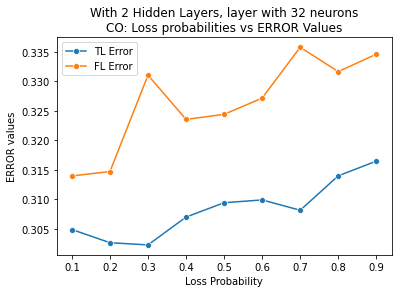

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.2, 0.5))

plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 2 Hidden Layers, layer with 32 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)

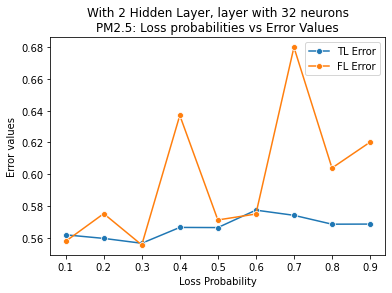

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.96, 0.9625))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 2 Hidden Layer, layer with 32 neurons\nPM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

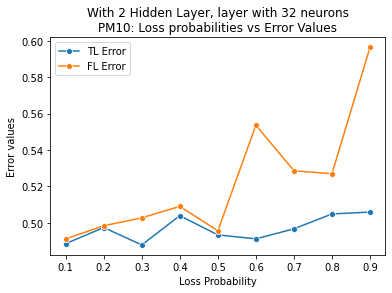

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.977, 0.979))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 2 Hidden Layer, layer with 32 neurons\nPM10: Loss probabilities vs Error Values") 
plt.show(ax)

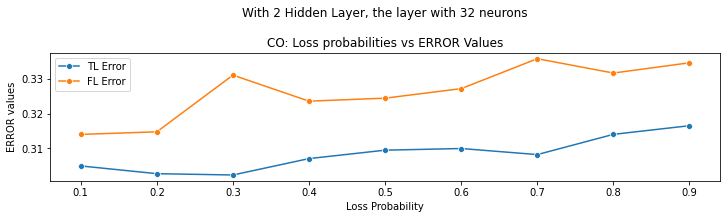

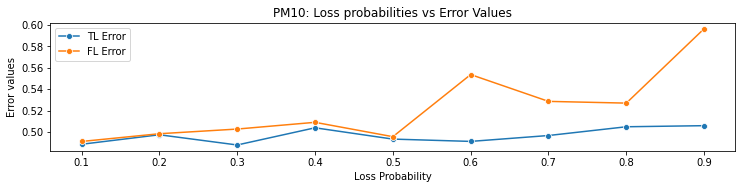

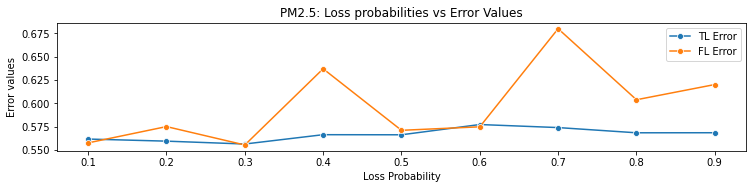

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(3,1,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.2, 0.5))
# ax.set(xlim=(0.1, 0.9))
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 2 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)


plt.figure(figsize=(27, 8))
plt.subplot(3,2,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.977, 0.979))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM10: Loss probabilities vs Error Values") 
plt.show(ax)


plt.figure(figsize=(42, 8))
plt.subplot(3,3,1)
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.96, 0.9625))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

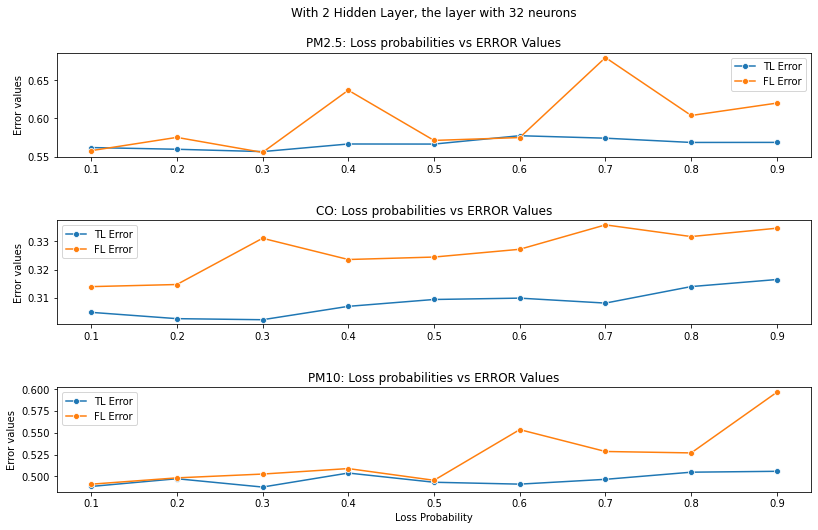

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(12,8))

idx = 0

y_arr = [(np.array(errors_tl_h2_32['PM2.5'])[:,1], np.array(errors_fl_h2_32['PM2.5'])[:,1]), (np.array(errors_tl_h2_32['CO'])[:,1], np.array(errors_fl_h2_32['CO'])[:,1]), 
         (np.array(errors_tl_h2_32['PM10'])[:,1], np.array(errors_fl_h2_32['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("With 2 Hidden Layer, the layer with 32 neurons\n\n{}: Loss probabilities vs ERROR Values".format(gas[row]))
        else:
          axes[row].set_title("{}: Loss probabilities vs ERROR Values".format(gas[row]))

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row])

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error', ax = axes[row])
        
        
        axes[row].set(ylabel='Error values')
        # if row == 1:
        #   axes[row].set(ylim=(0.0, 0.5))
        # else:
        #   axes[row].set(ylim=(0.4, 0.9))
        # # plt.legend()
        if row == 2:
          axes[row].set(xlabel='Loss Probability', ylabel='Error values')

        
        idx += 1

title = "With 2 Hidden Layer, the layer with 32 neurons"    
fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

#### Customized plots: 0.5

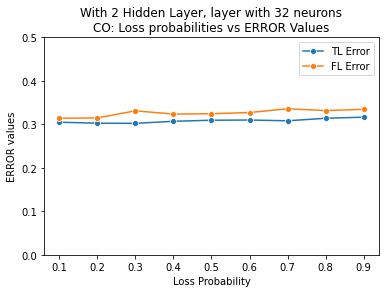

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 0.5))

plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 2 Hidden Layer, layer with 32 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)

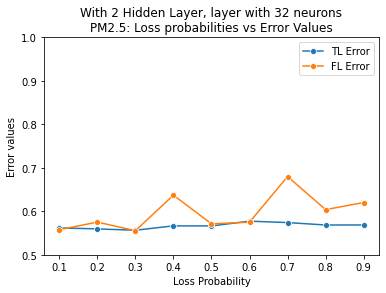

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.5, 1.0))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 2 Hidden Layer, layer with 32 neurons\nPM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

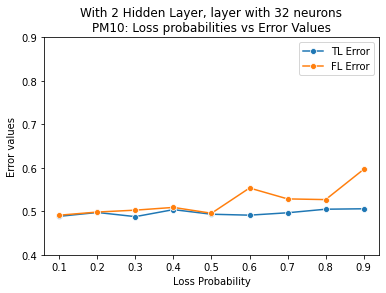

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.4, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 2 Hidden Layer, layer with 32 neurons\nPM10: Loss probabilities vs Error Values") 
plt.show(ax)

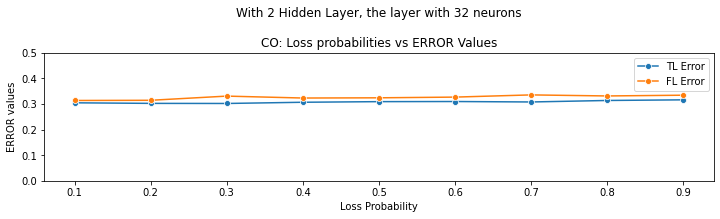

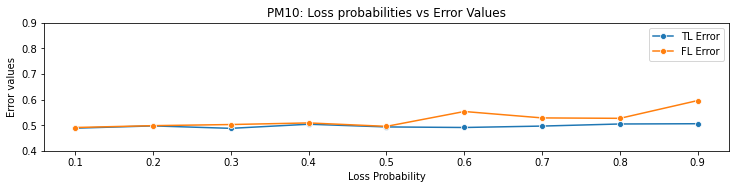

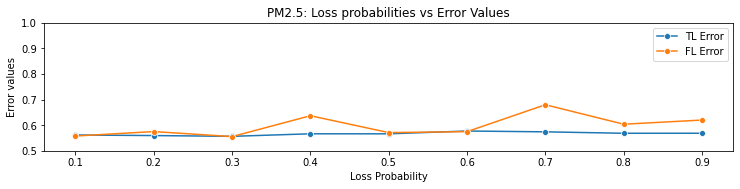

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(3,1,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 0.5))
# ax.set(xlim=(0.1, 0.9))
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 2 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)


plt.figure(figsize=(27, 8))
plt.subplot(3,2,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.4, 0.9))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM10: Loss probabilities vs Error Values") 
plt.show(ax)


plt.figure(figsize=(42, 8))
plt.subplot(3,3,1)
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.5, 1.0))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

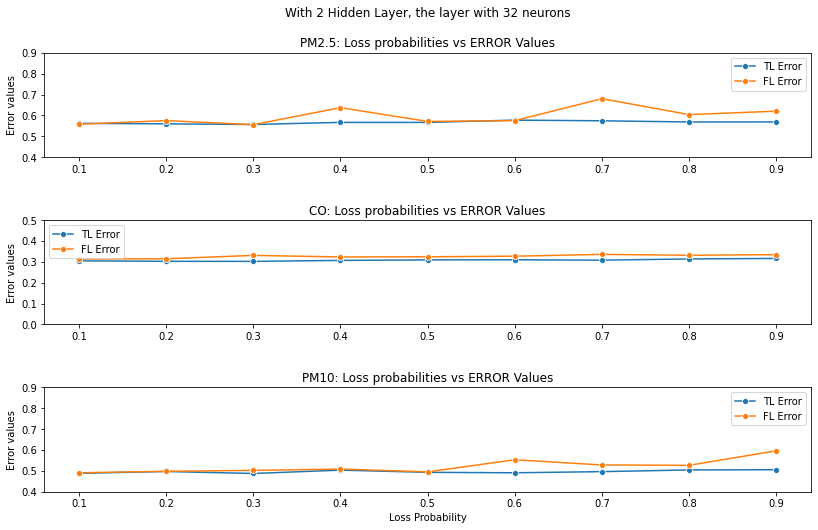

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(12,8))

idx = 0

y_arr = [(np.array(errors_tl_h2_32['PM2.5'])[:,1], np.array(errors_fl_h2_32['PM2.5'])[:,1]), (np.array(errors_tl_h2_32['CO'])[:,1], np.array(errors_fl_h2_32['CO'])[:,1]), 
         (np.array(errors_tl_h2_32['PM10'])[:,1], np.array(errors_fl_h2_32['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("With 2 Hidden Layer, the layer with 32 neurons\n\n{}: Loss probabilities vs ERROR Values".format(gas[row]))
        else:
          axes[row].set_title("{}: Loss probabilities vs ERROR Values".format(gas[row]))

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row])

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error', ax = axes[row])
        
        
        axes[row].set(ylabel='Error values')
        if row == 1:
          axes[row].set(ylim=(0.0, 0.5))
        else:
          axes[row].set(ylim=(0.4, 0.9))
        # plt.legend()
        if row == 2:
          axes[row].set(xlabel='Loss Probability', ylabel='Error values')

        
        idx += 1

title = "With 2 Hidden Layer, the layer with 32 neurons"    
fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

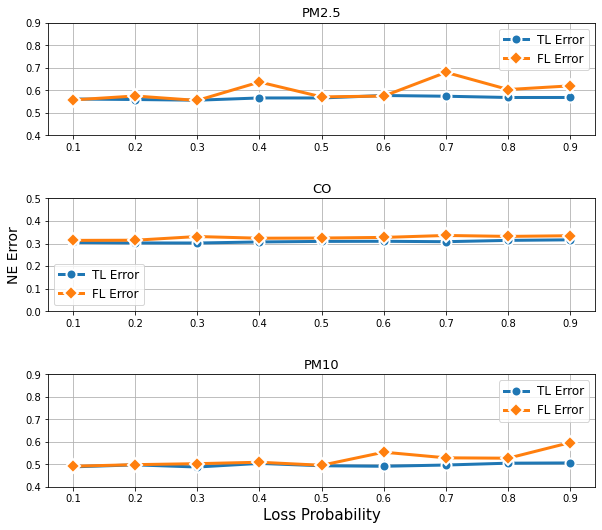

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(9,8))

idx = 0

y_arr = [(np.array(errors_tl_h2_32['PM2.5'])[:,1], np.array(errors_fl_h2_32['PM2.5'])[:,1]), (np.array(errors_tl_h2_32['CO'])[:,1], np.array(errors_fl_h2_32['CO'])[:,1]), 
         (np.array(errors_tl_h2_32['PM10'])[:,1], np.array(errors_fl_h2_32['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("{}".format(gas[row]), fontsize=13)
        else:
          axes[row].set_title("{}".format(gas[row]), fontsize=13)

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row], linewidth=3, ms='10', mew='2')

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="D", dashes=False, label = 'FL Error', ax = axes[row], linewidth=3, ms='10', mew='2')
        
        axes[row].legend(fontsize=12)
        axes[row].grid(True)
        
        if row == 1:
          axes[row].set(ylim=(0.0, 0.5))
          axes[row].set_ylabel('NE Error', fontsize=14)
        else:
          axes[row].set(ylim=(0.4, 0.9))

        if row == 2:
          pass
          # axes[row].set(xlabel='Loss Probability', fontsize=14)

        
        idx += 1
plt.xlabel("Loss Probability", fontsize=15)
# plt.ylabel("NE Error Values", loc='center', fontsize=15)
# title = "With 1 Hidden Layer, the layer with 64 neurons"    
# fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

#### Customized plots: 1.0

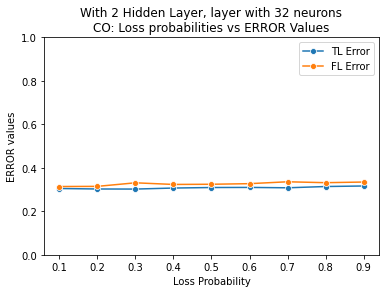

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))

plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 2 Hidden Layer, layer with 32 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)

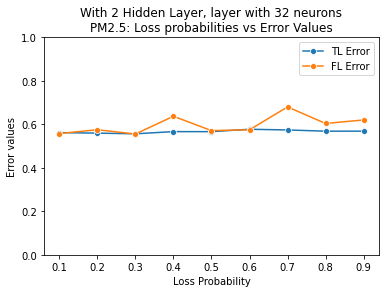

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 2 Hidden Layer, layer with 32 neurons\nPM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

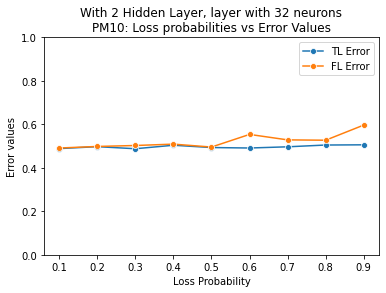

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 2 Hidden Layer, layer with 32 neurons\nPM10: Loss probabilities vs Error Values") 
plt.show(ax)

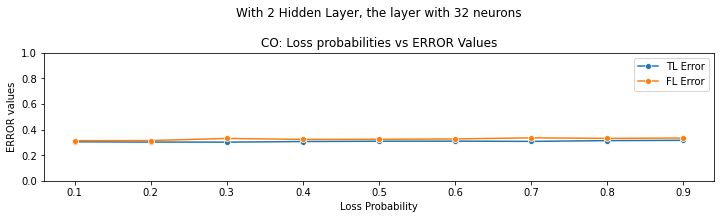

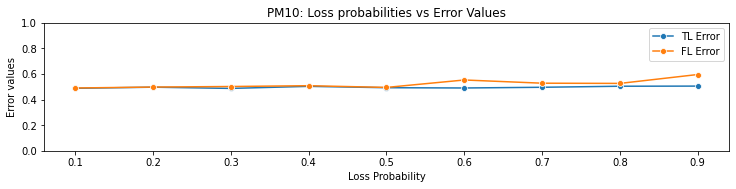

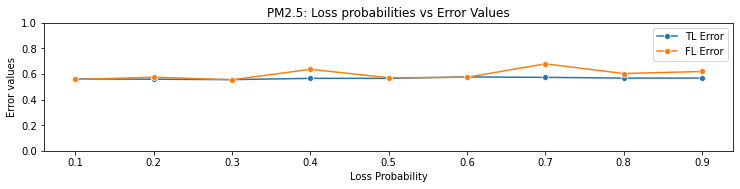

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(3,1,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlim=(0.1, 0.9))
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 2 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)


plt.figure(figsize=(27, 8))
plt.subplot(3,2,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM10: Loss probabilities vs Error Values") 
plt.show(ax)


plt.figure(figsize=(42, 8))
plt.subplot(3,3,1)
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

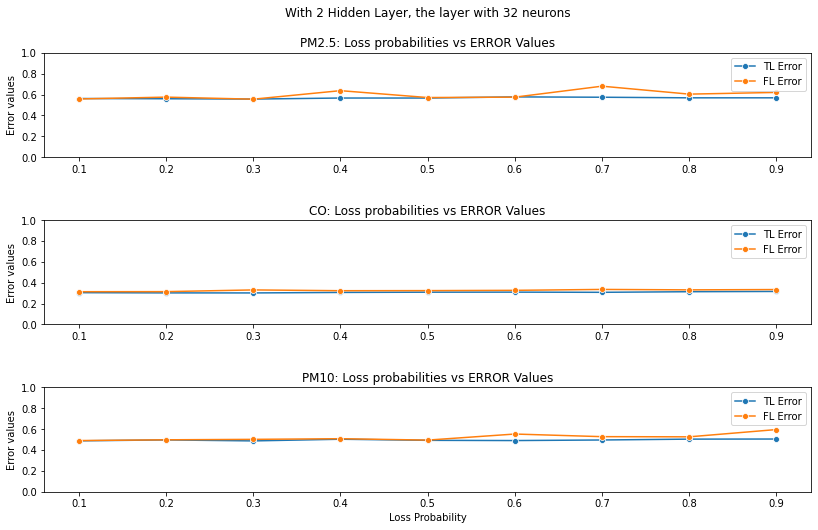

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(12,8))

idx = 0

y_arr = [(np.array(errors_tl_h2_32['PM2.5'])[:,1], np.array(errors_fl_h2_32['PM2.5'])[:,1]), (np.array(errors_tl_h2_32['CO'])[:,1], np.array(errors_fl_h2_32['CO'])[:,1]), 
         (np.array(errors_tl_h2_32['PM10'])[:,1], np.array(errors_fl_h2_32['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("With 2 Hidden Layer, the layer with 32 neurons\n\n{}: Loss probabilities vs ERROR Values".format(gas[row]))
        else:
          axes[row].set_title("{}: Loss probabilities vs ERROR Values".format(gas[row]))

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row])

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error', ax = axes[row])
        
        
        axes[row].set(ylabel='Error values')

        axes[row].set(ylim=(0.0, 1.0))
        # plt.legend()
        if row == 2:
          axes[row].set(xlabel='Loss Probability', ylabel='Error values')

        
        idx += 1

title = "With 2 Hidden Layer, the layer with 32 neurons"    
fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

## 2 hidden layers
* with 64 neurons

### traditional Learning

In [ ]:
def traditional_ML_2L_64_train(loss_p, gas, train_data):
  # initialize w_0
  # initialize w_0
  model = Sequential()

  # model.add(Dense(64, kernel_initializer='zeros', bias_initializer='zeros', activation=tf.nn.relu, input_dim=6)) # first dense/hidden layer
  model.add(Dense(64, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu, input_dim=8))
  model.add(Dropout(0.1))

  model.add(Dense(64, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu))
  model.add(Dropout(0.1))

  model.add(Dense(1, kernel_initializer= 'he_uniform', activation='linear')) # output layer


  # compile the model
  model.compile(loss='mse', 
              optimizer='adam', 
              metrics=['mse'])
  
  x_train, y_train = train_data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  train_data[gas]

 

  B = 1000 #int(len(x_train) * 0.01) # so for each client the batch size would be different depending upon the total sample size
  E = 25 #max(30, B//10) # number of local epochs; it will also depend on sample size (indirectly)


  model.fit(x_train, y_train, 
                  epochs = E, 
                  batch_size=B,
                  verbose=False)
  
  return model
      


In [ ]:
def traditional_ML_2L_64_test(model_name, gas, test_data):

  ## loading the json and creating model
  json_file = open(model_name + ".json", 'r')
  model_json = json_file.read()
  json_file.close()

  model = model_from_json(model_json)
  model.load_weights(model_name + ".h5")

  ## need to compile the model again after loading
  # compile the model
  model.compile(loss='mse', 
              optimizer='adam', 
              metrics=['mse'])
  

  x_test, y_test = test_data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  test_data[gas]

  x_test, y_test = x_test.to_numpy(), y_test.to_numpy()

  # adjusting the dimensions
  x_test = x_test.reshape(x_test.shape[0], x_test.shape[1])
  y_test = y_test.reshape(y_test.shape[0], 1)
  
  y_predicted = model.predict(x_test)
  

  from sklearn.metrics import mean_squared_error
  mse = mean_squared_error(y_predicted.ravel(), y_test.ravel())

  NE = np.sum(abs(np.array(y_test) - np.array(y_predicted))) / np.sum(np.array(y_test))
  return (mse, NE)


In [ ]:
# Final plotting
K = 25 # as we have 25 clients
train_data = pd.DataFrame()
test_data = pd.DataFrame()
loss_prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
gases = ['CO', 	'PM10',	'PM2.5']
errors_tl_h2_64 = {'CO':[], 	'PM10':[],	'PM2.5':[]}
models = []
model_name = "TL_model_2L_64_"


# for gas in gases:
#   for loss_p in loss_prob:
#     error = traditional_ML_L3_32(loss_p, gas)
#     errors_tl_h3_32[gas].append(error)

for gas in gases:
  for lp in loss_prob:
      for st_code in range(101,126):
          # splitting into train test split
          X, y = clients[st_code][['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  clients[st_code][gas]
          x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = lp, random_state=1)

          # Normalization using min-max scaler
          # Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set.
          # to avoid data leak
          scaler_cols = x_train.columns
          scaler_idx_train = x_train.index
          scaler_idx_test = x_test.index

          # from sklearn.preprocessing import MinMaxScaler
          scaler = MinMaxScaler()

          # transforming train data
          x_train_encoded_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns = scaler_cols, index=scaler_idx_train)
          # display(x_train_encoded_scaled.head())

          # transforming test data
          x_test_encoded_scaled = pd.DataFrame(scaler.transform(x_test), columns = scaler_cols, index = scaler_idx_test)
          # display(x_test_encoded_scaled.head())

          # training data prep
          if st_code == 101:
            train_data = pd.concat([x_train_encoded_scaled, y_train], axis = 1)
          else:
            xy = pd.concat([x_train_encoded_scaled, y_train], axis=1)
            train_data = pd.concat([train_data, xy], axis=0)
          # clients_cut[st_code] = pd.concat([x_train_encoded_scaled, y_train], axis = 1)
          

          # testing data prep
          # first appending x_test and y_test column wise
          # then appending each clients' dataframe one below other
          if st_code == 101:
            test_data = pd.concat([x_test_encoded_scaled, y_test], axis = 1)
          else:
            xy = pd.concat([x_test_encoded_scaled, y_test], axis=1)
            test_data = pd.concat([test_data, xy], axis=0)
          # x_test, y_test = x_test.to_numpy(), y_test.to_numpy()
      
      # Training the model using traditional learning
      # model = traditional_ML_2L_64_train(lp, gas, train_data)

      ## Saving model
      ## serializing model to JSON
      model_address = "/content/drive/MyDrive/Colab Notebooks/Models/" + model_name + gas + str(lp) + "_"


      # model_json = model.to_json()
      # with open(model_address + ".json", "w") as json_file:
      #   json_file.write(model_json)

      # # serialize weights to HDF5
      # model.save_weights(model_address + ".h5")


      ## Testing model
      error = traditional_ML_2L_64_test(model_address, gas, train_data)
      errors_tl_h2_64[gas].append(error)
      # testing model
      # errors_fl_h3_32[gas].append(error_clients_L3_32(model, gas))


### Federated Learning

In [ ]:
# ClientUpdate(k, w): // Run on client k
def Client_L2_64(client_idx, model, gas):
    # B ← (split P_k into batches of size B) # what is p_K --> each clients' sample size
    B = 1000 #int(len(clients[client_idx]) * 0.01) # so for each client the batch size would be different depending upon the total sample size
    E = 25 #max(30, B//10) # number of local epochs; it will also depend on sample size (indirectly)

    data = clients_cut[client_idx]
    # data = dataset.loc[dataset['Station code'] == client_idx]

    X, y = data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  data[gas]

    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state=1)

    try:
        model.fit(x_train, y_train, 
                    epochs = E, 
                    batch_size=B,
                    validation_data=(x_val, y_val),
                    verbose=False)
    except Exception as e:
        print(e)
        print("error")

    # return w to server
    # in our case no need for any explicit return; as the model is pass by value
    return data.shape[0] # this will return the number of total sample


In [ ]:
# Server executes: 
def Server_L2_64(gas):
    # initialize w_0
    # initialize w_0
    model = Sequential()

    # model.add(Dense(64, kernel_initializer='zeros', bias_initializer='zeros', activation=tf.nn.relu, input_dim=6)) # first dense/hidden layer
    model.add(Dense(64, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu, input_dim=8))
    model.add(Dropout(0.1))

    model.add(Dense(64, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu))
    model.add(Dropout(0.1))

    model.add(Dense(1, kernel_initializer= 'he_uniform', activation='linear')) # output layer


    # compile the model
    model.compile(loss='mse', 
                optimizer='adam', 
                metrics=['mse'])
    

# for each round t = 1, 2, . . . do
    for t in range(1, 5):
        C = np.random.random(1)[0] # random number between 0 and 1.

        # m ← max(C  K, 1)
        m = max(int(C*K), 1) # m == random number of client selected
        weight_t_plus_1 = [None] * m # matrix to store the weights of all client in each t-round
        n_k = [None] * m # parameters for weighted sum 


        # S_t ← (random set of m clients)
        # S = {} # dictionary
        S_t = np.random.uniform(low=101, high=126, size=(m)).astype(int)

        # No need for below loop, as server don't need access to client data, server only need clients' number
        # for client in m_clients:
        #   S[client] = clients[client]

        initial_weights = model.get_weights() # setting initial weights; should be same for all clients
        # for t= 1 to T, initial_weights would be t-1th's final weights

        # for each client k ∈ S_t in parallel do
        client_idx = 0
        for client in S_t:
            # w^(k)_(t+1) ← ClientUpdate(k, model)
            n_k[client_idx] = Client_L2_64(client, model, gas) # pass by reference for model
            weight_t_plus_1[client_idx] = model.get_weights()
            client_idx += 1

            # setting weights back to initial weights
            model.set_weights(initial_weights)

        # finding the weighted sum
        final_weights_t = np.array(weight_t_plus_1[0]) * (n_k[0] / sum(n_k))

        for idx in range(1, m):
          # w_(t+1) ← summation(k=1 to K){(n_k/n) * w^(k)_(t+1)} #n_k - no. of training sample in each client K; n - total training samples;
          final_weights_t += np.array(weight_t_plus_1[idx]) * (n_k[idx]/ sum(n_k))

        # setting the aggregated weights
        model.set_weights(final_weights_t)


#         print(model.get_weights())
    # return error_clients(model, loss_p)) # THIS LINE WON'T BE THERE IN REAL SERVER
    return model

In [ ]:
def error_clients_L2_64(model_name, gas, test_data):

    ## loading the json and creating model
    json_file = open(model_name + ".json", 'r')
    model_json = json_file.read()
    json_file.close()

    model = model_from_json(model_json)
    model.load_weights(model_name + ".h5")

    ## need to compile the model again after loading
    # compile the model
    model.compile(loss='mse', 
                optimizer='adam', 
                metrics=['mse'])
  
    
    X, y = test_data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  test_data[gas]
    
    # adjusting the dimensions
    x_test, y_test = X.to_numpy(), y.to_numpy()
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1])
    y_test = y_test.reshape(y_test.shape[0],1)

    y_predicted = model.predict(x_test)
    
    from sklearn.metrics import mean_squared_error
    # print("y_predicted", y_predicted)
    # print("y_predicted.ravel()", y_predicted.ravel())
    NE = np.sum(abs(np.array(y_test) - np.array(y_predicted))) / np.sum(np.array(y_test))

    mse = mean_squared_error(y_predicted.ravel(), y_test.ravel())
    
    return (mse,NE)

          

In [ ]:

# create an Empty DataFrame object
train_data = pd.DataFrame()
test_data = pd.DataFrame()
loss_prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
models = []
errors_fl_h2_64 = {'CO':[], 	'PM10':[],	'PM2.5':[]}
gases = ['CO', 	'PM10',	'PM2.5']
model_name = "FL_model_2L_64_"


# reading all the clients and building model
for gas in gases:
  for lp in loss_prob:
      for st_code in range(101,126):
          # splitting into train test split
          X, y = clients[st_code][['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  clients[st_code][gas]
          x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = lp, random_state=1)

          # Normalization using min-max scaler
          # Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set.
          # to avoid data leak
          scaler_cols = x_train.columns
          scaler_idx_train = x_train.index
          scaler_idx_test = x_test.index

          # from sklearn.preprocessing import MinMaxScaler
          scaler = MinMaxScaler()

          # transforming train data
          x_train_encoded_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns = scaler_cols, index=scaler_idx_train)
          # display(x_train_encoded_scaled.head())

          # transforming test data
          x_test_encoded_scaled = pd.DataFrame(scaler.transform(x_test), columns = scaler_cols, index = scaler_idx_test)
          # display(x_test_encoded_scaled.head())

          # training data prep
          clients_cut[st_code] = pd.concat([x_train_encoded_scaled, y_train], axis = 1)

          # testing data prep
          # first appending x_test and y_test column wise
          # then appending each clients' dataframe one below other
          if st_code == 101:
            test_data = pd.concat([x_test_encoded_scaled, y_test], axis = 1)
          else:
            xy = pd.concat([x_test_encoded_scaled, y_test], axis=1)
            test_data = pd.concat([test_data, xy], axis=0)
          # x_test, y_test = x_test.to_numpy(), y_test.to_numpy()

      # Training the model using federated learning
      # model = Server_L2_64(gas)

      ## Saving model
      ## serializing model to JSON
      model_address = "/content/drive/MyDrive/Colab Notebooks/Models/" + model_name + gas + str(lp) + "_"


      # model_json = model.to_json()
      # with open(model_address + ".json", "w") as json_file:
      #   json_file.write(model_json)

      # # serialize weights to HDF5
      # model.save_weights(model_address + ".h5")


      ## Testing model
      error = error_clients_L2_64(model_address, gas, test_data)
      errors_fl_h2_64[gas].append(error)


### Plots

#### Original plots

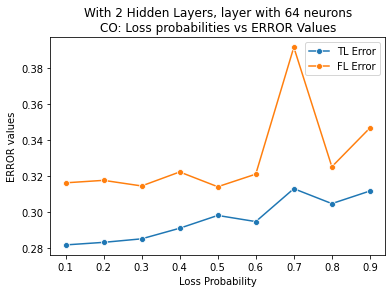

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.2, 0.5))

plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 2 Hidden Layers, layer with 64 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)

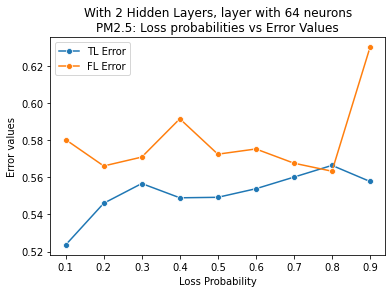

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.96, 0.9625))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 2 Hidden Layers, layer with 64 neurons\nPM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

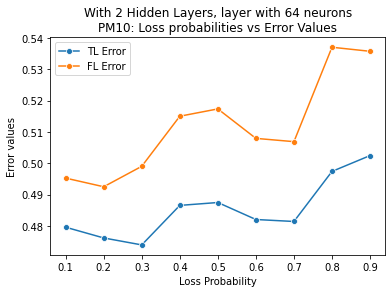

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.977, 0.979))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 2 Hidden Layers, layer with 64 neurons\nPM10: Loss probabilities vs Error Values") 
plt.show(ax)

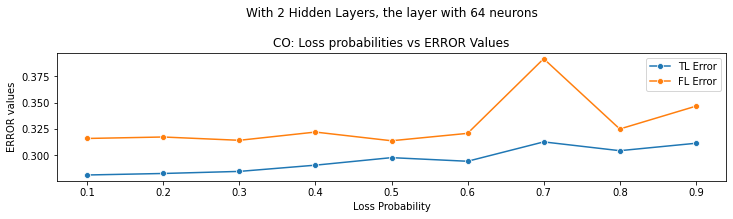

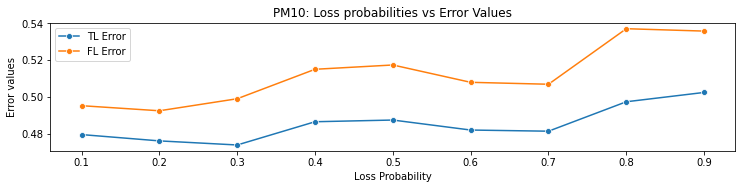

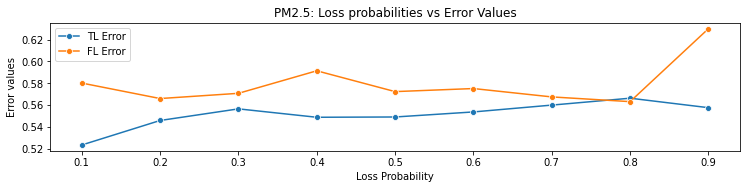

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(3,1,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.2, 0.5))
# ax.set(xlim=(0.1, 0.9))
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 2 Hidden Layers, the layer with 64 neurons\n\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)


plt.figure(figsize=(27, 8))
plt.subplot(3,2,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.977, 0.979))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM10: Loss probabilities vs Error Values") 
plt.show(ax)


plt.figure(figsize=(42, 8))
plt.subplot(3,3,1)
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.96, 0.9625))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

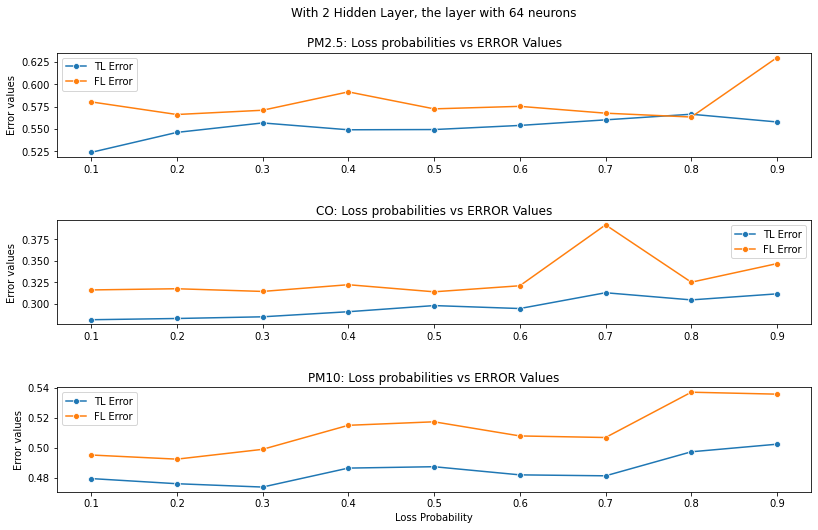

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(12,8))

idx = 0

y_arr = [(np.array(errors_tl_h2_64['PM2.5'])[:,1], np.array(errors_fl_h2_64['PM2.5'])[:,1]), (np.array(errors_tl_h2_64['CO'])[:,1], np.array(errors_fl_h2_64['CO'])[:,1]), 
         (np.array(errors_tl_h2_64['PM10'])[:,1], np.array(errors_fl_h2_64['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("With 2 Hidden Layer, the layer with 64 neurons\n\n{}: Loss probabilities vs ERROR Values".format(gas[row]))
        else:
          axes[row].set_title("{}: Loss probabilities vs ERROR Values".format(gas[row]))

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row])

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error', ax = axes[row])
        
        
        axes[row].set(ylabel='Error values')
        # if row == 1:
        #   axes[row].set(ylim=(0.0, 0.5))
        # else:
        #   axes[row].set(ylim=(0.4, 0.9))
        # plt.legend()
        if row == 2:
          axes[row].set(xlabel='Loss Probability', ylabel='Error values')

        
        idx += 1

title = "With 2 Hidden Layer, the layer with 64 neurons"    
fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

#### Customized plots: 0.5

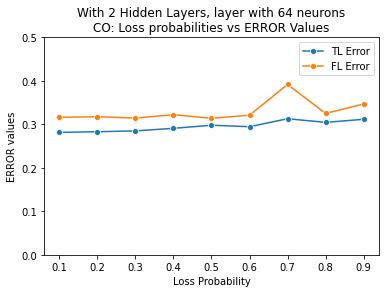

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 0.5))

plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 2 Hidden Layers, layer with 64 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)

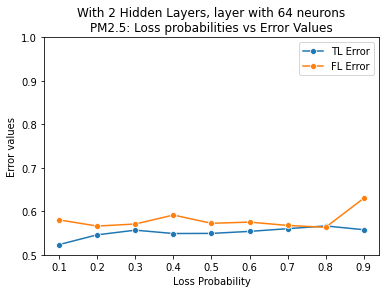

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.5, 1.0))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 2 Hidden Layers, layer with 64 neurons\nPM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

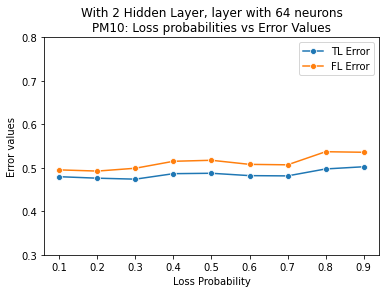

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.3, 0.8))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 2 Hidden Layer, layer with 64 neurons\nPM10: Loss probabilities vs Error Values") 
plt.show(ax)

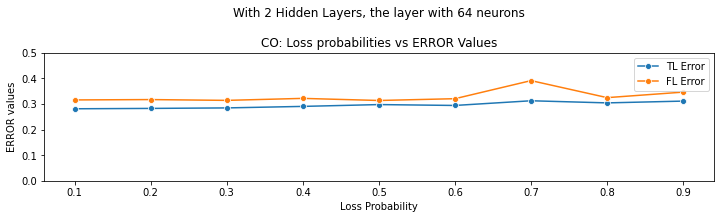

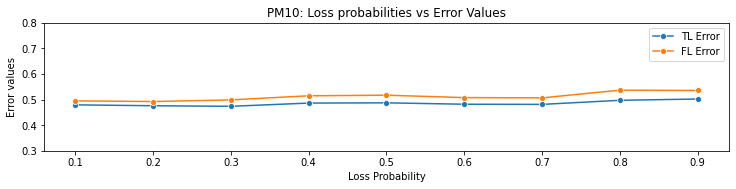

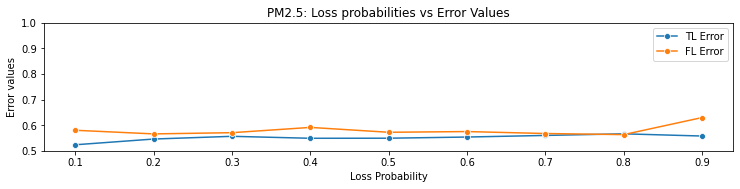

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(3,1,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 0.5))
# ax.set(xlim=(0.1, 0.9))
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 2 Hidden Layers, the layer with 64 neurons\n\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)


plt.figure(figsize=(27, 8))
plt.subplot(3,2,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.3, 0.8))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM10: Loss probabilities vs Error Values") 
plt.show(ax)


plt.figure(figsize=(42, 8))
plt.subplot(3,3,1)
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.5, 1.0))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

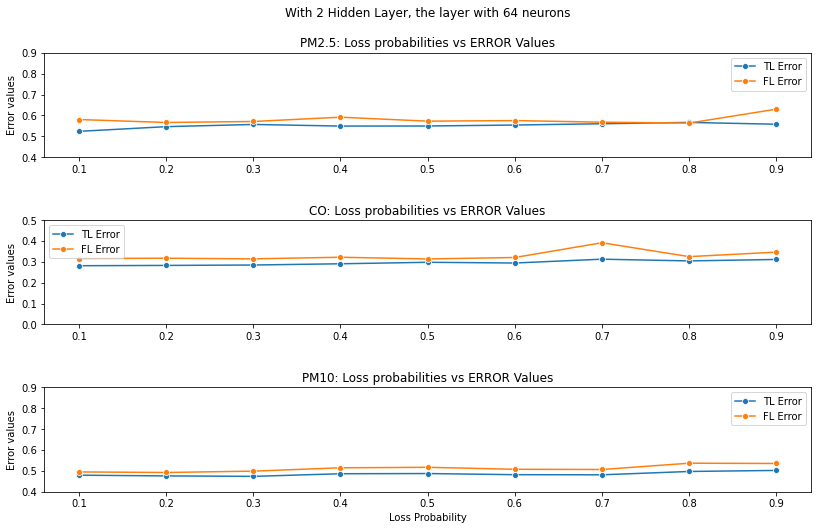

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(12,8))

idx = 0

y_arr = [(np.array(errors_tl_h2_64['PM2.5'])[:,1], np.array(errors_fl_h2_64['PM2.5'])[:,1]), (np.array(errors_tl_h2_64['CO'])[:,1], np.array(errors_fl_h2_64['CO'])[:,1]), 
         (np.array(errors_tl_h2_64['PM10'])[:,1], np.array(errors_fl_h2_64['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("With 2 Hidden Layer, the layer with 64 neurons\n\n{}: Loss probabilities vs ERROR Values".format(gas[row]))
        else:
          axes[row].set_title("{}: Loss probabilities vs ERROR Values".format(gas[row]))

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row])

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error', ax = axes[row])
        
        
        axes[row].set(ylabel='Error values')
        if row == 1:
          axes[row].set(ylim=(0.0, 0.5))
        else:
          axes[row].set(ylim=(0.4, 0.9))
        # plt.legend()
        if row == 2:
          axes[row].set(xlabel='Loss Probability', ylabel='Error values')

        
        idx += 1

title = "With 2 Hidden Layer, the layer with 64 neurons"    
fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

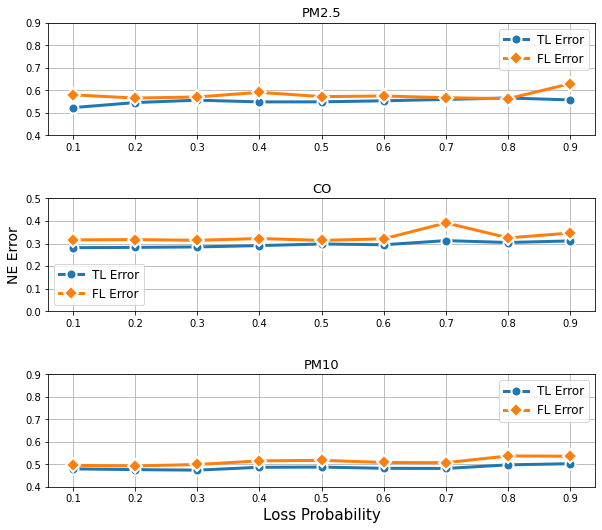

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(9,8))

idx = 0

y_arr = [(np.array(errors_tl_h2_64['PM2.5'])[:,1], np.array(errors_fl_h2_64['PM2.5'])[:,1]), (np.array(errors_tl_h2_64['CO'])[:,1], np.array(errors_fl_h2_64['CO'])[:,1]), 
         (np.array(errors_tl_h2_64['PM10'])[:,1], np.array(errors_fl_h2_64['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("{}".format(gas[row]), fontsize=13)
        else:
          axes[row].set_title("{}".format(gas[row]), fontsize=13)

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row], linewidth=3, ms='10', mew='2')

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="D", dashes=False, label = 'FL Error', ax = axes[row], linewidth=3, ms='10', mew='2')
        
        axes[row].legend(fontsize=12)
        axes[row].grid(True)
        
        if row == 1:
          axes[row].set(ylim=(0.0, 0.5))
          axes[row].set_ylabel('NE Error', fontsize=14)
        else:
          axes[row].set(ylim=(0.4, 0.9))

        if row == 2:
          pass
          # axes[row].set(xlabel='Loss Probability', fontsize=14)

        
        idx += 1
plt.xlabel("Loss Probability", fontsize=15)
# plt.ylabel("NE Error Values", loc='center', fontsize=15)
# title = "With 1 Hidden Layer, the layer with 64 neurons"    
# fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

#### Customized plots: 1.0

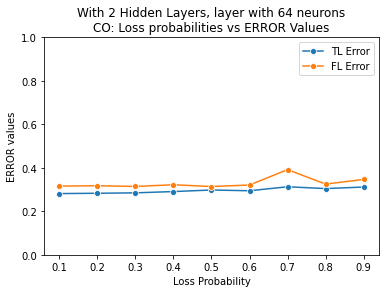

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))

plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 2 Hidden Layers, layer with 64 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)

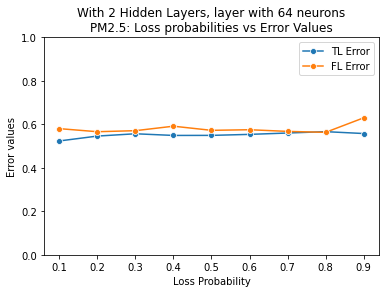

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 2 Hidden Layers, layer with 64 neurons\nPM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

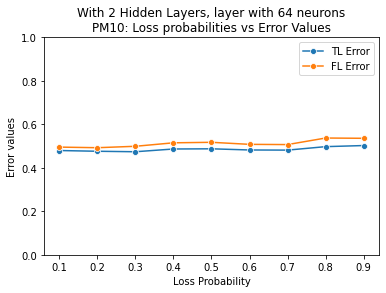

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 2 Hidden Layers, layer with 64 neurons\nPM10: Loss probabilities vs Error Values") 
plt.show(ax)

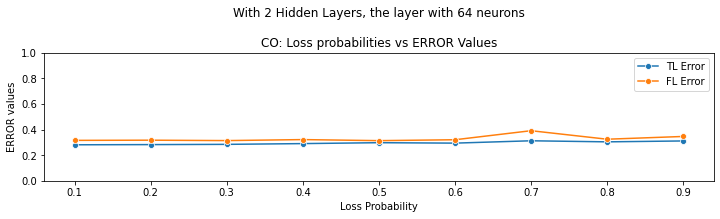

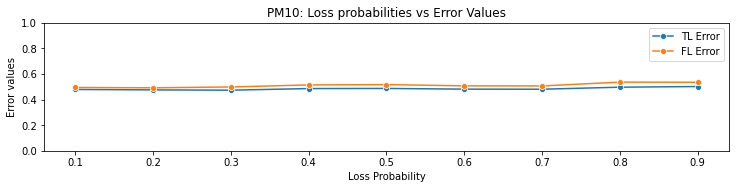

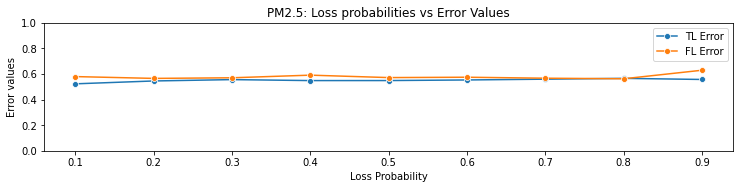

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(3,1,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlim=(0.1, 0.9))
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 2 Hidden Layers, the layer with 64 neurons\n\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)


plt.figure(figsize=(27, 8))
plt.subplot(3,2,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM10: Loss probabilities vs Error Values") 
plt.show(ax)


plt.figure(figsize=(42, 8))
plt.subplot(3,3,1)
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

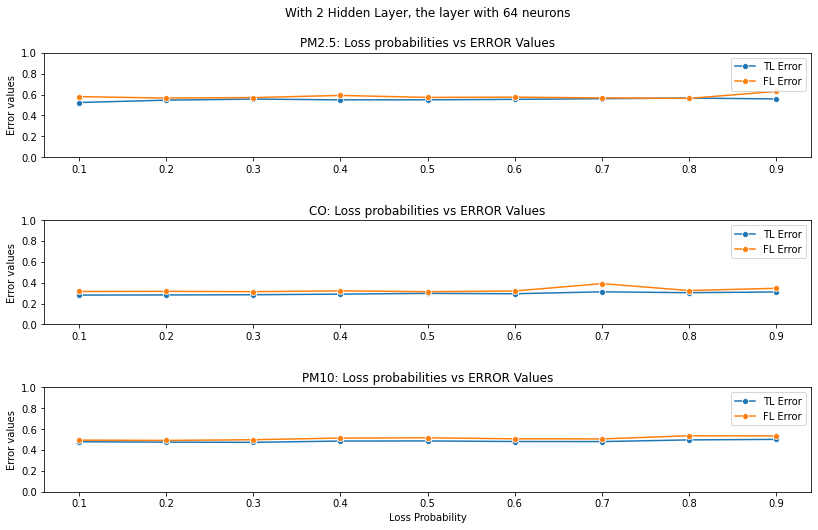

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(12,8))

idx = 0

y_arr = [(np.array(errors_tl_h2_64['PM2.5'])[:,1], np.array(errors_fl_h2_64['PM2.5'])[:,1]), (np.array(errors_tl_h2_64['CO'])[:,1], np.array(errors_fl_h2_64['CO'])[:,1]), 
         (np.array(errors_tl_h2_64['PM10'])[:,1], np.array(errors_fl_h2_64['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("With 2 Hidden Layer, the layer with 64 neurons\n\n{}: Loss probabilities vs ERROR Values".format(gas[row]))
        else:
          axes[row].set_title("{}: Loss probabilities vs ERROR Values".format(gas[row]))

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row])

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error', ax = axes[row])
        
        
        axes[row].set(ylabel='Error values')
        axes[row].set(ylim=(0.0, 1.0))
        # plt.legend()
        if row == 2:
          axes[row].set(xlabel='Loss Probability', ylabel='Error values')

        
        idx += 1

title = "With 2 Hidden Layer, the layer with 64 neurons"    
fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

## 3 hidden layer
* with 32 neurons

### traditional Learning

In [ ]:
def traditional_ML_3L_32_train(loss_p, gas, train_data):
  # initialize w_0
  model = Sequential()

  # model.add(Dense(64, kernel_initializer='zeros', bias_initializer='zeros', activation=tf.nn.relu, input_dim=6)) # first dense/hidden layer
  model.add(Dense(32, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu, input_dim=8))
  model.add(Dropout(0.1))

  model.add(Dense(32, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu))
  model.add(Dropout(0.1))

  model.add(Dense(32, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu))
  model.add(Dropout(0.1))
  
  model.add(Dense(1, kernel_initializer= 'he_uniform', activation='linear')) # output layer


  # compile the model
  model.compile(loss='mse', 
              optimizer='adam', 
              metrics=['mse'])
  
  x_train, y_train = train_data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  train_data[gas]

 

  B = 1000 #int(len(x_train) * 0.01) # so for each client the batch size would be different depending upon the total sample size
  E = 25 #max(30, B//10) # number of local epochs; it will also depend on sample size (indirectly)


  model.fit(x_train, y_train, 
                  epochs = E, 
                  batch_size=B,
                  verbose=False)
  
  return model
      


In [ ]:
def traditional_ML_3L_32_test(model_name, gas, test_data):

  ## loading the json and creating model
  json_file = open(model_name + ".json", 'r')
  model_json = json_file.read()
  json_file.close()

  model = model_from_json(model_json)
  model.load_weights(model_name + ".h5")

  ## need to compile the model again after loading
  # compile the model
  model.compile(loss='mse', 
              optimizer='adam', 
              metrics=['mse'])
  

  x_test, y_test = test_data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  test_data[gas]

  x_test, y_test = x_test.to_numpy(), y_test.to_numpy()

  # adjusting the dimensions
  x_test = x_test.reshape(x_test.shape[0], x_test.shape[1])
  y_test = y_test.reshape(y_test.shape[0],1)
  
  y_predicted = model.predict(x_test)
  

  from sklearn.metrics import mean_squared_error
  mse = mean_squared_error(y_predicted.ravel(), y_test.ravel())

  NE = np.sum(abs(np.array(y_test) - np.array(y_predicted))) / np.sum(np.array(y_test))
  return (mse, NE)


In [ ]:
# Final plotting
K = 25 # as we have 25 clients
train_data = pd.DataFrame()
test_data = pd.DataFrame()
loss_prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
gases = ['CO', 	'PM10',	'PM2.5']
errors_tl_h3_32 = {'CO':[], 	'PM10':[],	'PM2.5':[]}
models = []
model_name = "TL_model_3L_32_"


# for gas in gases:
#   for loss_p in loss_prob:
#     error = traditional_ML_L3_32(loss_p, gas)
#     errors_tl_h3_32[gas].append(error)

for gas in gases:
  for lp in loss_prob:
      for st_code in range(101,126):
          # splitting into train test split
          X, y = clients[st_code][['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  clients[st_code][gas]
          x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = lp, random_state=1)

          # Normalization using min-max scaler
          # Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set.
          # to avoid data leak
          scaler_cols = x_train.columns
          scaler_idx_train = x_train.index
          scaler_idx_test = x_test.index

          # from sklearn.preprocessing import MinMaxScaler
          scaler = MinMaxScaler()

          # transforming train data
          x_train_encoded_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns = scaler_cols, index=scaler_idx_train)
          # display(x_train_encoded_scaled.head())

          # transforming test data
          x_test_encoded_scaled = pd.DataFrame(scaler.transform(x_test), columns = scaler_cols, index = scaler_idx_test)
          # display(x_test_encoded_scaled.head())

          # training data prep
          if st_code == 101:
            train_data = pd.concat([x_train_encoded_scaled, y_train], axis = 1)
          else:
            xy = pd.concat([x_train_encoded_scaled, y_train], axis=1)
            train_data = pd.concat([train_data, xy], axis=0)
          # clients_cut[st_code] = pd.concat([x_train_encoded_scaled, y_train], axis = 1)
          

          # testing data prep
          # first appending x_test and y_test column wise
          # then appending each clients' dataframe one below other
          if st_code == 101:
            test_data = pd.concat([x_test_encoded_scaled, y_test], axis = 1)
          else:
            xy = pd.concat([x_test_encoded_scaled, y_test], axis=1)
            test_data = pd.concat([test_data, xy], axis=0)
          # x_test, y_test = x_test.to_numpy(), y_test.to_numpy()
      
      # Training the model using traditional learning
      # model = traditional_ML_3L_32_train(lp, gas, train_data)

      ## Saving model
      ## serializing model to JSON
      model_address = "/content/drive/MyDrive/Colab Notebooks/Models/" + model_name + gas + str(lp) + "_"


      # model_json = model.to_json()
      # with open(model_address + ".json", "w") as json_file:
      #   json_file.write(model_json)

      # # serialize weights to HDF5
      # model.save_weights(model_address + ".h5")


      ## Testing model
      error = traditional_ML_3L_32_test(model_address, gas, train_data)
      errors_tl_h3_32[gas].append(error)
      # testing model
      # errors_fl_h3_32[gas].append(error_clients_L3_32(model, gas))


### Federated Learning

In [ ]:
# ClientUpdate(k, w): // Run on client k
def Client_L3_32(client_idx, model, gas):
    # B ← (split P_k into batches of size B) # what is p_K --> each clients' sample size
    B = 1000 #int(len(clients[client_idx]) * 0.01) # so for each client the batch size would be different depending upon the total sample size
    E = 25 #max(30, B//10) # number of local epochs; it will also depend on sample size (indirectly)

    data = clients_cut[client_idx]
    # data = dataset.loc[dataset['Station code'] == client_idx]

    X, y = data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  data[gas]

    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state=1)

    try:
        model.fit(x_train, y_train, 
                    epochs = E, 
                    batch_size=B,
                    validation_data=(x_val, y_val),
                    verbose=False)
    except Exception as e:
        print(e)
        print("error")

    # return w to server
    # in our case no need for any explicit return; as the model is pass by value
    return data.shape[0] # this will return the number of total sample


In [ ]:
# Server executes: 
def Server_L3_32(gas):
    # initialize w_0
    model = Sequential()

    # model.add(Dense(64, kernel_initializer='zeros', bias_initializer='zeros', activation=tf.nn.relu, input_dim=6)) # first dense/hidden layer
    model.add(Dense(32, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu, input_dim=8))
    model.add(Dropout(0.1))

    model.add(Dense(32, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu))
    model.add(Dropout(0.1))

    model.add(Dense(32, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu))
    model.add(Dropout(0.1))
    
    model.add(Dense(1, kernel_initializer= 'he_uniform', activation='linear')) # output layer


    # compile the model
    model.compile(loss='mse', 
                optimizer='adam', 
                metrics=['mse'])
    

# for each round t = 1, 2, . . . do
    for t in range(1, 5):
        C = np.random.random(1)[0] # random number between 0 and 1.

        # m ← max(C  K, 1)
        m = max(int(C*K), 1) # m == random number of client selected
        weight_t_plus_1 = [None] * m # matrix to store the weights of all client in each t-round
        n_k = [None] * m # parameters for weighted sum 


        # S_t ← (random set of m clients)
        # S = {} # dictionary
        S_t = np.random.uniform(low=101, high=126, size=(m)).astype(int)

        # No need for below loop, as server don't need access to client data, server only need clients' number
        # for client in m_clients:
        #   S[client] = clients[client]

        initial_weights = model.get_weights() # setting initial weights; should be same for all clients
        # for t= 1 to T, initial_weights would be t-1th's final weights

        # for each client k ∈ S_t in parallel do
        client_idx = 0
        for client in S_t:
            # w^(k)_(t+1) ← ClientUpdate(k, model)
            n_k[client_idx] = Client_L3_32(client, model, gas) # pass by reference for model
            weight_t_plus_1[client_idx] = model.get_weights()
            client_idx += 1

            # setting weights back to initial weights
            model.set_weights(initial_weights)

        # finding the weighted sum
        final_weights_t = np.array(weight_t_plus_1[0]) * (n_k[0] / sum(n_k))

        for idx in range(1, m):
          # w_(t+1) ← summation(k=1 to K){(n_k/n) * w^(k)_(t+1)} #n_k - no. of training sample in each client K; n - total training samples;
          final_weights_t += np.array(weight_t_plus_1[idx]) * (n_k[idx]/ sum(n_k))

        # setting the aggregated weights
        model.set_weights(final_weights_t)


#         print(model.get_weights())
    # return error_clients(model, loss_p)) # THIS LINE WON'T BE THERE IN REAL SERVER
    return model

In [ ]:
def error_clients_L3_32(model_name, gas, test_data):

    ## loading the json and creating model
    json_file = open(model_name + ".json", 'r')
    model_json = json_file.read()
    json_file.close()

    model = model_from_json(model_json)
    model.load_weights(model_name + ".h5")

    ## need to compile the model again after loading
    # compile the model
    model.compile(loss='mse', 
                optimizer='adam', 
                metrics=['mse'])
  
    
    X, y = test_data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  test_data[gas]
    
    # adjusting the dimensions
    x_test, y_test = X.to_numpy(), y.to_numpy()
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1])
    y_test = y_test.reshape(y_test.shape[0],1)

    y_predicted = model.predict(x_test)
    
    from sklearn.metrics import mean_squared_error
    # print("y_predicted", y_predicted)
    # print("y_predicted.ravel()", y_predicted.ravel())
    NE = np.sum(abs(np.array(y_test) - np.array(y_predicted))) / np.sum(np.array(y_test))

    mse = mean_squared_error(y_predicted.ravel(), y_test.ravel())
    
    return (mse,NE)

          

In [ ]:

# create an Empty DataFrame object
train_data = pd.DataFrame()
test_data = pd.DataFrame()
loss_prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
models = []
errors_fl_h3_32 = {'CO':[], 	'PM10':[],	'PM2.5':[]}
gases = ['CO', 	'PM10',	'PM2.5']
model_name = "FL_model_3L_32_"


# reading all the clients and building model
for gas in gases:
  for lp in loss_prob:
      for st_code in range(101,126):
          # splitting into train test split
          X, y = clients[st_code][['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  clients[st_code][gas]
          x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = lp, random_state=1)

          # Normalization using min-max scaler
          # Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set.
          # to avoid data leak
          scaler_cols = x_train.columns
          scaler_idx_train = x_train.index
          scaler_idx_test = x_test.index

          # from sklearn.preprocessing import MinMaxScaler
          scaler = MinMaxScaler()

          # transforming train data
          x_train_encoded_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns = scaler_cols, index=scaler_idx_train)
          # display(x_train_encoded_scaled.head())

          # transforming test data
          x_test_encoded_scaled = pd.DataFrame(scaler.transform(x_test), columns = scaler_cols, index = scaler_idx_test)
          # display(x_test_encoded_scaled.head())

          # training data prep
          clients_cut[st_code] = pd.concat([x_train_encoded_scaled, y_train], axis = 1)

          # testing data prep
          # first appending x_test and y_test column wise
          # then appending each clients' dataframe one below other
          if st_code == 101:
            test_data = pd.concat([x_test_encoded_scaled, y_test], axis = 1)
          else:
            xy = pd.concat([x_test_encoded_scaled, y_test], axis=1)
            test_data = pd.concat([test_data, xy], axis=0)
          # x_test, y_test = x_test.to_numpy(), y_test.to_numpy()

      # # Training the model using federated learning
      # model = Server_L3_32(gas)

      ## Saving model
      ## serializing model to JSON
      model_address = "/content/drive/MyDrive/Colab Notebooks/Models/" + model_name + gas + str(lp) + "_"


      # model_json = model.to_json()
      # with open(model_address + ".json", "w") as json_file:
      #   json_file.write(model_json)

      # # serialize weights to HDF5
      # model.save_weights(model_address + ".h5")


      ## Testing model
      error = error_clients_L3_32(model_address, gas, test_data)
      errors_fl_h3_32[gas].append(error)


### Plots

#### Original plots

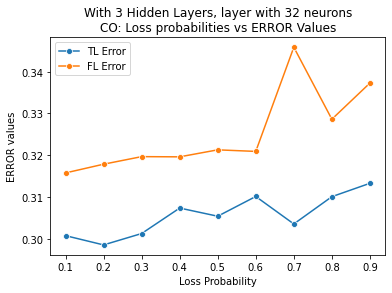

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.2, 0.5))

plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 3 Hidden Layers, layer with 32 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)

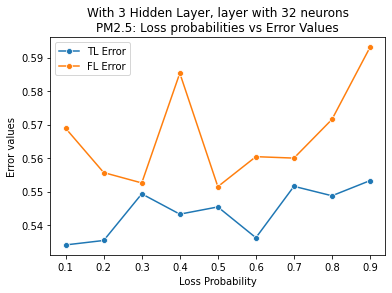

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.96, 0.9625))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 3 Hidden Layer, layer with 32 neurons\nPM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

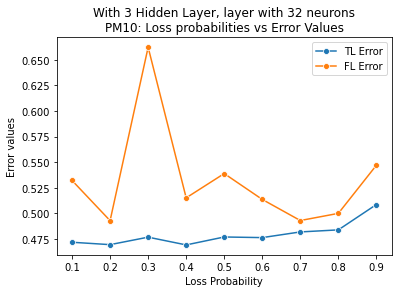

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.977, 0.979))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 3 Hidden Layer, layer with 32 neurons\nPM10: Loss probabilities vs Error Values") 
plt.show(ax)

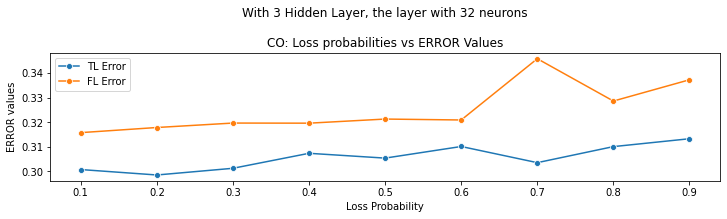

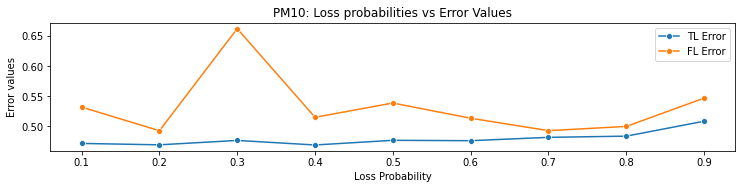

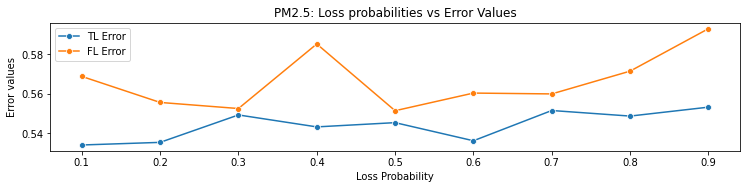

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(3,1,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.2, 0.5))
# ax.set(xlim=(0.1, 0.9))
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 3 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)


plt.figure(figsize=(27, 8))
plt.subplot(3,2,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.977, 0.979))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM10: Loss probabilities vs Error Values") 
plt.show(ax)


plt.figure(figsize=(42, 8))
plt.subplot(3,3,1)
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.96, 0.9625))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

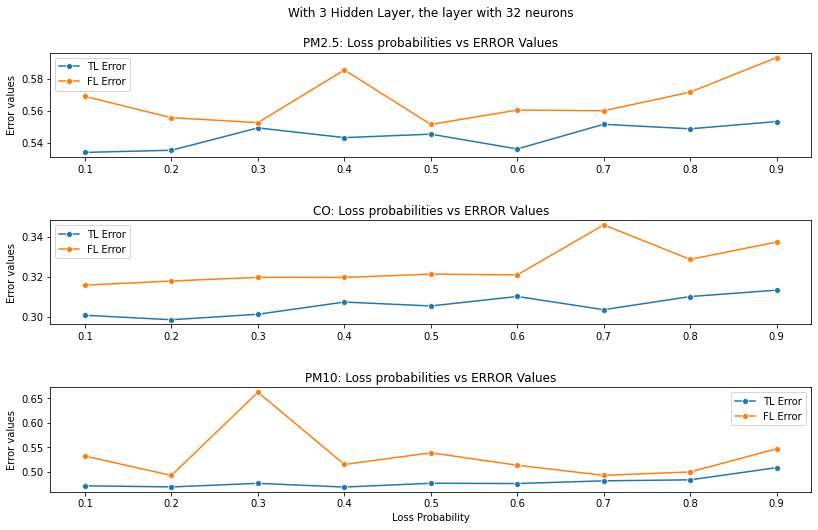

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(12,8))

idx = 0

y_arr = [(np.array(errors_tl_h3_32['PM2.5'])[:,1], np.array(errors_fl_h3_32['PM2.5'])[:,1]), (np.array(errors_tl_h3_32['CO'])[:,1], np.array(errors_fl_h3_32['CO'])[:,1]), 
         (np.array(errors_tl_h3_32['PM10'])[:,1], np.array(errors_fl_h3_32['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("With 3 Hidden Layer, the layer with 32 neurons\n\n{}: Loss probabilities vs ERROR Values".format(gas[row]))
        else:
          axes[row].set_title("{}: Loss probabilities vs ERROR Values".format(gas[row]))

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row])

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error', ax = axes[row])
        
        
        axes[row].set(ylabel='Error values')
        # if row == 1:
        #   axes[row].set(ylim=(0.0, 0.5))
        # else:
        #   axes[row].set(ylim=(0.4, 0.9))
        # plt.legend()
        if row == 2:
          axes[row].set(xlabel='Loss Probability', ylabel='Error values')

        
        idx += 1

title = "With 3 Hidden Layer, the layer with 32 neurons"    
fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

#### Customized plots: 0.5

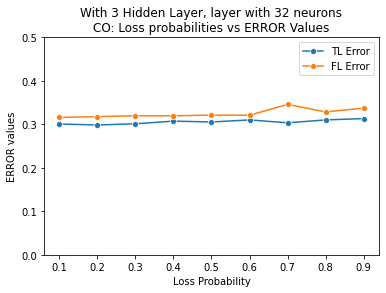

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 0.5))

plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 3 Hidden Layer, layer with 32 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)

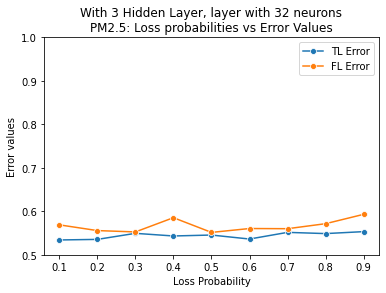

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.5, 1.0))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 3 Hidden Layer, layer with 32 neurons\nPM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

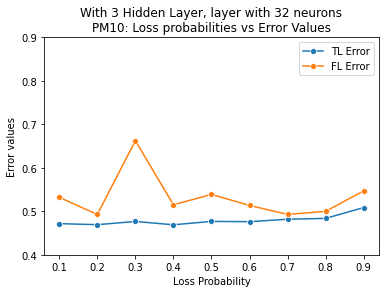

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.4, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 3 Hidden Layer, layer with 32 neurons\nPM10: Loss probabilities vs Error Values") 
plt.show(ax)

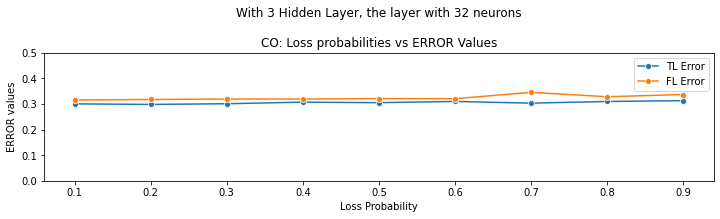

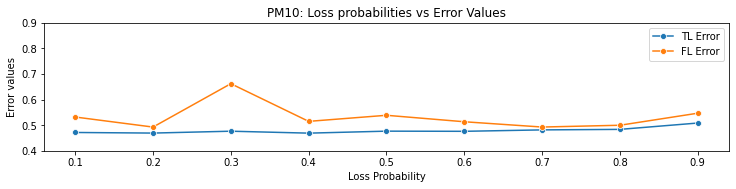

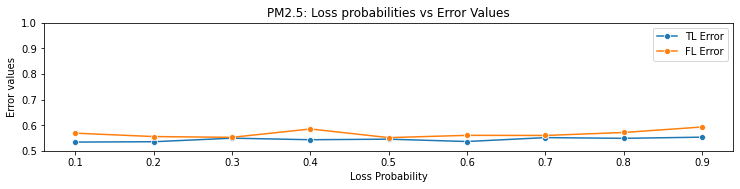

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(3,1,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 0.5))
# ax.set(xlim=(0.1, 0.9))
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 3 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)


plt.figure(figsize=(27, 8))
plt.subplot(3,2,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.4, 0.9))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM10: Loss probabilities vs Error Values") 
plt.show(ax)


plt.figure(figsize=(42, 8))
plt.subplot(3,3,1)
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.5, 1.0))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


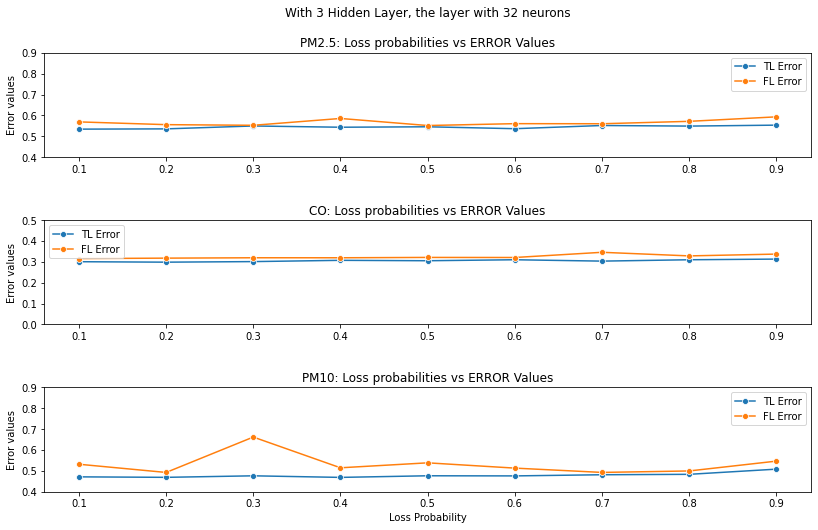

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(12,8))

idx = 0

y_arr = [(np.array(errors_tl_h3_32['PM2.5'])[:,1], np.array(errors_fl_h3_32['PM2.5'])[:,1]), (np.array(errors_tl_h3_32['CO'])[:,1], np.array(errors_fl_h3_32['CO'])[:,1]), 
         (np.array(errors_tl_h3_32['PM10'])[:,1], np.array(errors_fl_h3_32['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("With 3 Hidden Layer, the layer with 32 neurons\n\n{}: Loss probabilities vs ERROR Values".format(gas[row]))
        else:
          axes[row].set_title("{}: Loss probabilities vs ERROR Values".format(gas[row]))

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row])

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error', ax = axes[row])
        
        
        axes[row].set(ylabel='Error values')
        if row == 1:
          axes[row].set(ylim=(0.0, 0.5))
        else:
          axes[row].set(ylim=(0.4, 0.9))
        plt.legend()
        if row == 2:
          axes[row].set(xlabel='Loss Probability', ylabel='Error values')

        
        idx += 1

title = "With 3 Hidden Layer, the layer with 32 neurons"    
fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

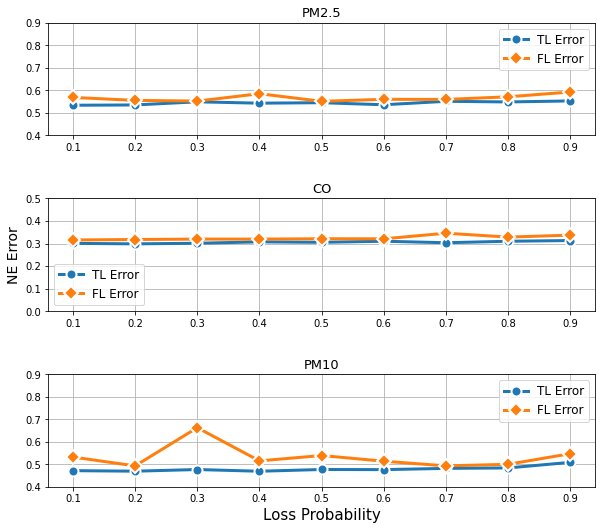

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(9,8))

idx = 0

y_arr = [(np.array(errors_tl_h3_32['PM2.5'])[:,1], np.array(errors_fl_h3_32['PM2.5'])[:,1]), (np.array(errors_tl_h3_32['CO'])[:,1], np.array(errors_fl_h3_32['CO'])[:,1]), 
         (np.array(errors_tl_h3_32['PM10'])[:,1], np.array(errors_fl_h3_32['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("{}".format(gas[row]), fontsize=13)
        else:
          axes[row].set_title("{}".format(gas[row]), fontsize=13)

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row], linewidth=3, ms='10', mew='2')

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="D", dashes=False, label = 'FL Error', ax = axes[row], linewidth=3, ms='10', mew='2')
        
        axes[row].legend(fontsize=12)
        axes[row].grid(True)
        
        if row == 1:
          axes[row].set(ylim=(0.0, 0.5))
          axes[row].set_ylabel('NE Error', fontsize=14)
        else:
          axes[row].set(ylim=(0.4, 0.9))

        if row == 2:
          pass
          # axes[row].set(xlabel='Loss Probability', fontsize=14)

        
        idx += 1
plt.xlabel("Loss Probability", fontsize=15)
# plt.ylabel("NE Error Values", loc='center', fontsize=15)
# title = "With 1 Hidden Layer, the layer with 64 neurons"    
# fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

#### Customized plots: 1.0

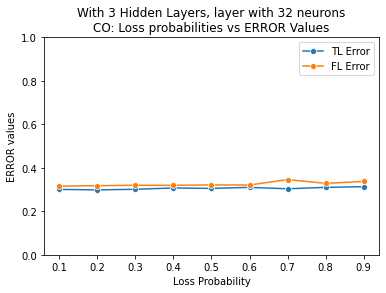

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))

plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 3 Hidden Layers, layer with 32 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)

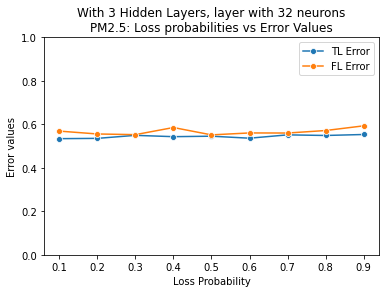

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 3 Hidden Layers, layer with 32 neurons\nPM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

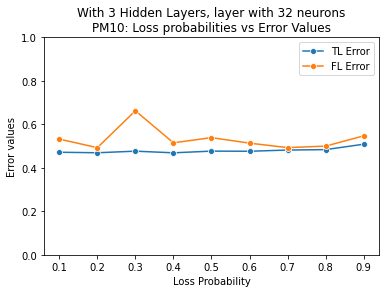

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 3 Hidden Layers, layer with 32 neurons\nPM10: Loss probabilities vs Error Values") 
plt.show(ax)

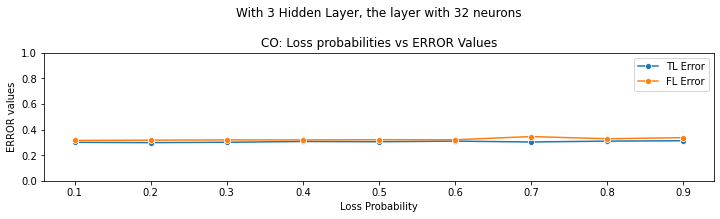

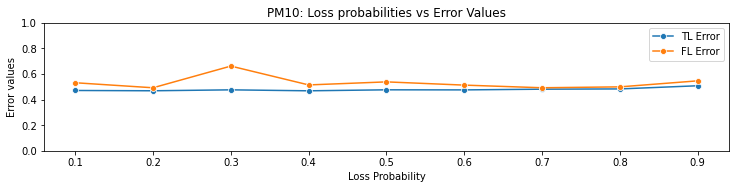

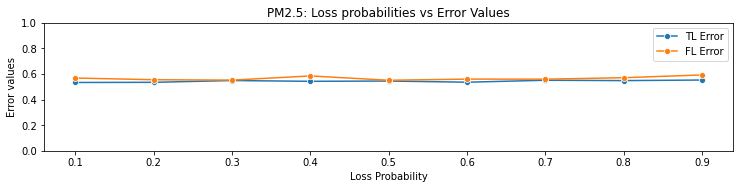

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(3,1,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlim=(0.1, 0.9))
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 3 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)


plt.figure(figsize=(27, 8))
plt.subplot(3,2,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM10: Loss probabilities vs Error Values") 
plt.show(ax)


plt.figure(figsize=(42, 8))
plt.subplot(3,3,1)
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


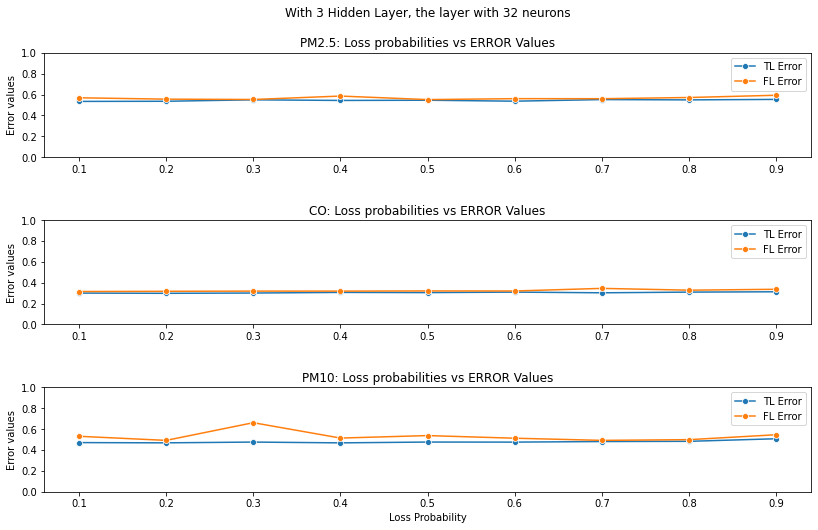

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(12,8))

idx = 0

y_arr = [(np.array(errors_tl_h3_32['PM2.5'])[:,1], np.array(errors_fl_h3_32['PM2.5'])[:,1]), (np.array(errors_tl_h3_32['CO'])[:,1], np.array(errors_fl_h3_32['CO'])[:,1]), 
         (np.array(errors_tl_h3_32['PM10'])[:,1], np.array(errors_fl_h3_32['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("With 3 Hidden Layer, the layer with 32 neurons\n\n{}: Loss probabilities vs ERROR Values".format(gas[row]))
        else:
          axes[row].set_title("{}: Loss probabilities vs ERROR Values".format(gas[row]))

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row])

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error', ax = axes[row])
        
        
        axes[row].set(ylabel='Error values')
        axes[row].set(ylim=(0.0, 1.0))
        plt.legend()
        if row == 2:
          axes[row].set(xlabel='Loss Probability', ylabel='Error values')

        
        idx += 1

title = "With 3 Hidden Layer, the layer with 32 neurons"    
fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

## 3 hidden layers
* with 64 neurons

### traditional Learning

In [ ]:
def traditional_ML_3L_64_train(loss_p, gas, train_data):
  # initialize w_0
  # initialize w_0
  model = Sequential()

  # model.add(Dense(64, kernel_initializer='zeros', bias_initializer='zeros', activation=tf.nn.relu, input_dim=6)) # first dense/hidden layer
  model.add(Dense(64, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu, input_dim=8))
  model.add(Dropout(0.1))

  model.add(Dense(64, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu))
  model.add(Dropout(0.1))

  model.add(Dense(64, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu))
  model.add(Dropout(0.1))
  
  model.add(Dense(1, kernel_initializer= 'he_uniform', activation='linear')) # output layer


  # compile the model
  model.compile(loss='mse', 
              optimizer='adam', 
              metrics=['mse'])
  
  x_train, y_train = train_data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  train_data[gas]

 

  B = 1000 #int(len(x_train) * 0.01) # so for each client the batch size would be different depending upon the total sample size
  E = 25 #max(30, B//10) # number of local epochs; it will also depend on sample size (indirectly)


  model.fit(x_train, y_train, 
                  epochs = E, 
                  batch_size=B,
                  verbose=False)
  
  return model
      


In [ ]:
def traditional_ML_3L_64_test(model_name, gas, test_data):

  ## loading the json and creating model
  json_file = open(model_name + ".json", 'r')
  model_json = json_file.read()
  json_file.close()

  model = model_from_json(model_json)
  model.load_weights(model_name + ".h5")

  ## need to compile the model again after loading
  # compile the model
  model.compile(loss='mse', 
              optimizer='adam', 
              metrics=['mse'])
  

  x_test, y_test = test_data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  test_data[gas]

  x_test, y_test = x_test.to_numpy(), y_test.to_numpy()

  # adjusting the dimensions
  x_test = x_test.reshape(x_test.shape[0],  x_test.shape[1])
  y_test = y_test.reshape(y_test.shape[0],1)
  
  y_predicted = model.predict(x_test)
  

  from sklearn.metrics import mean_squared_error
  mse = mean_squared_error(y_predicted.ravel(), y_test.ravel())

  NE = np.sum(abs(np.array(y_test) - np.array(y_predicted))) / np.sum(np.array(y_test))
  return (mse, NE)


In [ ]:
# Final plotting
K = 25 # as we have 25 clients
train_data = pd.DataFrame()
test_data = pd.DataFrame()
loss_prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
gases = ['CO', 	'PM10',	'PM2.5']
errors_tl_h3_64 = {'CO':[], 	'PM10':[],	'PM2.5':[]}
models = []
model_name = "TL_model_3L_64_"


# for gas in gases:
#   for loss_p in loss_prob:
#     error = traditional_ML_L3_32(loss_p, gas)
#     errors_tl_h3_32[gas].append(error)

for gas in gases:
  for lp in loss_prob:
      for st_code in range(101,126):
          # splitting into train test split
          X, y = clients[st_code][['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  clients[st_code][gas]
          x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = lp, random_state=1)

          # Normalization using min-max scaler
          # Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set.
          # to avoid data leak
          scaler_cols = x_train.columns
          scaler_idx_train = x_train.index
          scaler_idx_test = x_test.index

          # from sklearn.preprocessing import MinMaxScaler
          scaler = MinMaxScaler()

          # transforming train data
          x_train_encoded_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns = scaler_cols, index=scaler_idx_train)
          # display(x_train_encoded_scaled.head())

          # transforming test data
          x_test_encoded_scaled = pd.DataFrame(scaler.transform(x_test), columns = scaler_cols, index = scaler_idx_test)
          # display(x_test_encoded_scaled.head())

          # training data prep
          if st_code == 101:
            train_data = pd.concat([x_train_encoded_scaled, y_train], axis = 1)
          else:
            xy = pd.concat([x_train_encoded_scaled, y_train], axis=1)
            train_data = pd.concat([train_data, xy], axis=0)
          # clients_cut[st_code] = pd.concat([x_train_encoded_scaled, y_train], axis = 1)
          

          # testing data prep
          # first appending x_test and y_test column wise
          # then appending each clients' dataframe one below other
          if st_code == 101:
            test_data = pd.concat([x_test_encoded_scaled, y_test], axis = 1)
          else:
            xy = pd.concat([x_test_encoded_scaled, y_test], axis=1)
            test_data = pd.concat([test_data, xy], axis=0)
          # x_test, y_test = x_test.to_numpy(), y_test.to_numpy()
      
      # Training the model using traditional learning
      # model = traditional_ML_3L_64_train(lp, gas, train_data)

      ## Saving model
      ## serializing model to JSON
      model_address = "/content/drive/MyDrive/Colab Notebooks/Models/" + model_name + gas + str(lp) + "_"


      # model_json = model.to_json()
      # with open(model_address + ".json", "w") as json_file:
      #   json_file.write(model_json)

      # # serialize weights to HDF5
      # model.save_weights(model_address + ".h5")


      ## Testing model
      error = traditional_ML_3L_64_test(model_address, gas, train_data)
      errors_tl_h3_64[gas].append(error)
      # testing model
      # errors_fl_h3_32[gas].append(error_clients_L3_32(model, gas))


### Federated Learning

In [ ]:
# ClientUpdate(k, w): // Run on client k
def Client_L3_64(client_idx, model, gas):
    # B ← (split P_k into batches of size B) # what is p_K --> each clients' sample size
    B = 1000 #int(len(clients[client_idx]) * 0.01) # so for each client the batch size would be different depending upon the total sample size
    E = 25 #max(30, B//10) # number of local epochs; it will also depend on sample size (indirectly)

    data = clients_cut[client_idx]
    # data = dataset.loc[dataset['Station code'] == client_idx]

    X, y = data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  data[gas]

    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state=1)

    try:
        model.fit(x_train, y_train, 
                    epochs = E, 
                    batch_size=B,
                    validation_data=(x_val, y_val),
                    verbose=False)
    except Exception as e:
        print(e)
        print("error")

    # return w to server
    # in our case no need for any explicit return; as the model is pass by value
    return data.shape[0] # this will return the number of total sample


In [ ]:
# Server executes: 
def Server_L3_64(gas):
    # initialize w_0
    # initialize w_0
    model = Sequential()


    # model.add(Dense(64, kernel_initializer='zeros', bias_initializer='zeros', activation=tf.nn.relu, input_dim=6)) # first dense/hidden layer
    model.add(Dense(64, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu, input_dim=8))
    model.add(Dropout(0.1))

    model.add(Dense(64, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu))
    model.add(Dropout(0.1))

    model.add(Dense(64, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu))
    model.add(Dropout(0.1))
    
    model.add(Dense(1, kernel_initializer= 'he_uniform', activation='linear')) # output layer


    # compile the model
    model.compile(loss='mse', 
                optimizer='adam', 
                metrics=['mse'])
    

# for each round t = 1, 2, . . . do
    for t in range(1, 5):
        C = np.random.random(1)[0] # random number between 0 and 1.

        # m ← max(C  K, 1)
        m = max(int(C*K), 1) # m == random number of client selected
        weight_t_plus_1 = [None] * m # matrix to store the weights of all client in each t-round
        n_k = [None] * m # parameters for weighted sum 


        # S_t ← (random set of m clients)
        # S = {} # dictionary
        S_t = np.random.uniform(low=101, high=126, size=(m)).astype(int)

        # No need for below loop, as server don't need access to client data, server only need clients' number
        # for client in m_clients:
        #   S[client] = clients[client]

        initial_weights = model.get_weights() # setting initial weights; should be same for all clients
        # for t= 1 to T, initial_weights would be t-1th's final weights

        # for each client k ∈ S_t in parallel do
        client_idx = 0
        for client in S_t:
            # w^(k)_(t+1) ← ClientUpdate(k, model)
            n_k[client_idx] = Client_L3_64(client, model, gas) # pass by reference for model
            weight_t_plus_1[client_idx] = model.get_weights()
            client_idx += 1

            # setting weights back to initial weights
            model.set_weights(initial_weights)

        # finding the weighted sum
        final_weights_t = np.array(weight_t_plus_1[0]) * (n_k[0] / sum(n_k))

        for idx in range(1, m):
          # w_(t+1) ← summation(k=1 to K){(n_k/n) * w^(k)_(t+1)} #n_k - no. of training sample in each client K; n - total training samples;
          final_weights_t += np.array(weight_t_plus_1[idx]) * (n_k[idx]/ sum(n_k))

        # setting the aggregated weights
        model.set_weights(final_weights_t)


#         print(model.get_weights())
    # return error_clients(model, loss_p)) # THIS LINE WON'T BE THERE IN REAL SERVER
    return model

In [ ]:
def error_clients_L3_64(model_name, gas, test_data):

    ## loading the json and creating model
    json_file = open(model_name + ".json", 'r')
    model_json = json_file.read()
    json_file.close()

    model = model_from_json(model_json)
    model.load_weights(model_name + ".h5")

    ## need to compile the model again after loading
    # compile the model
    model.compile(loss='mse', 
                optimizer='adam', 
                metrics=['mse'])
  
    
    X, y = test_data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  test_data[gas]
    
    # adjusting the dimensions
    x_test, y_test = X.to_numpy(), y.to_numpy()
    x_test = x_test.reshape(x_test.shape[0],  x_test.shape[1])
    y_test = y_test.reshape(y_test.shape[0],1)

    y_predicted = model.predict(x_test)
    
    from sklearn.metrics import mean_squared_error
    # print("y_predicted", y_predicted)
    # print("y_predicted.ravel()", y_predicted.ravel())
    NE = np.sum(abs(np.array(y_test) - np.array(y_predicted))) / np.sum(np.array(y_test))

    mse = mean_squared_error(y_predicted.ravel(), y_test.ravel())
    
    return (mse,NE)

          

In [ ]:

# create an Empty DataFrame object
train_data = pd.DataFrame()
test_data = pd.DataFrame()
loss_prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
models = []
errors_fl_h3_64 = {'CO':[], 	'PM10':[],	'PM2.5':[]}
gases = ['CO', 	'PM10',	'PM2.5']
model_name = "FL_model_3L_64_"


# reading all the clients and building model
for gas in gases:
  for lp in loss_prob:
      for st_code in range(101,126):
          # splitting into train test split
          X, y = clients[st_code][['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  clients[st_code][gas]
          x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = lp, random_state=1)

          # Normalization using min-max scaler
          # Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set.
          # to avoid data leak
          scaler_cols = x_train.columns
          scaler_idx_train = x_train.index
          scaler_idx_test = x_test.index

          # from sklearn.preprocessing import MinMaxScaler
          scaler = MinMaxScaler()

          # transforming train data
          x_train_encoded_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns = scaler_cols, index=scaler_idx_train)
          # display(x_train_encoded_scaled.head())

          # transforming test data
          x_test_encoded_scaled = pd.DataFrame(scaler.transform(x_test), columns = scaler_cols, index = scaler_idx_test)
          # display(x_test_encoded_scaled.head())

          # training data prep
          clients_cut[st_code] = pd.concat([x_train_encoded_scaled, y_train], axis = 1)

          # testing data prep
          # first appending x_test and y_test column wise
          # then appending each clients' dataframe one below other
          if st_code == 101:
            test_data = pd.concat([x_test_encoded_scaled, y_test], axis = 1)
          else:
            xy = pd.concat([x_test_encoded_scaled, y_test], axis=1)
            test_data = pd.concat([test_data, xy], axis=0)
          # x_test, y_test = x_test.to_numpy(), y_test.to_numpy()

      # Training the model using federated learning
      # model = Server_L3_64(gas)

      ## Saving model
      ## serializing model to JSON
      model_address = "/content/drive/MyDrive/Colab Notebooks/Models/" + model_name + gas + str(lp) + "_"


      # model_json = model.to_json()
      # with open(model_address + ".json", "w") as json_file:
      #   json_file.write(model_json)

      # # serialize weights to HDF5
      # model.save_weights(model_address + ".h5")


      ## Testing model
      error = error_clients_L3_64(model_address, gas, test_data)
      errors_fl_h3_64[gas].append(error)


### Plots

#### Original plots

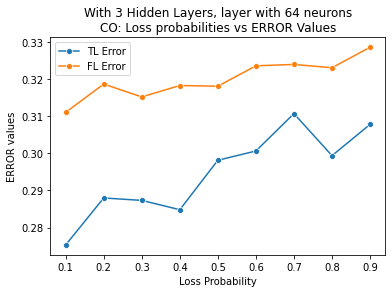

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.2, 0.5))

plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 3 Hidden Layers, layer with 64 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)

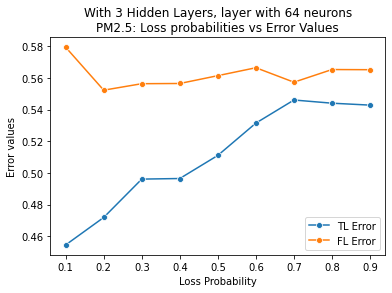

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.96, 0.9625))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 3 Hidden Layers, layer with 64 neurons\nPM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

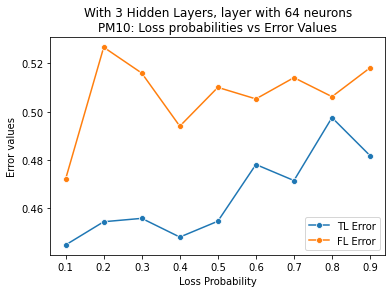

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.977, 0.979))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 3 Hidden Layers, layer with 64 neurons\nPM10: Loss probabilities vs Error Values") 
plt.show(ax)

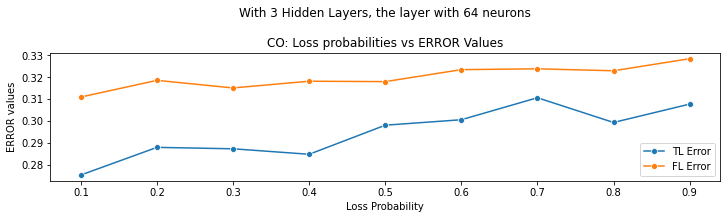

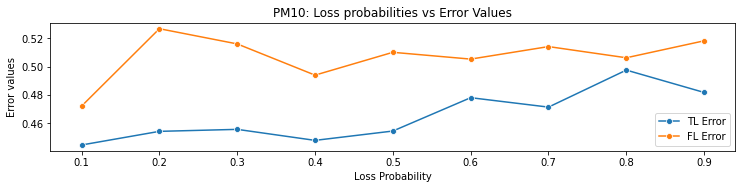

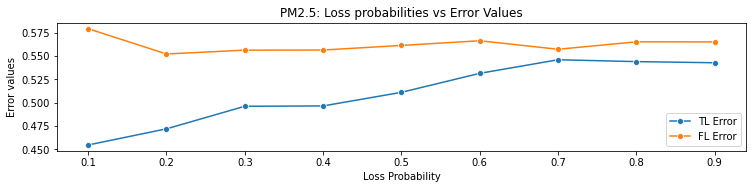

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(3,1,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.2, 0.5))
# ax.set(xlim=(0.1, 0.9))
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 3 Hidden Layers, the layer with 64 neurons\n\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)


plt.figure(figsize=(27, 8))
plt.subplot(3,2,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.977, 0.979))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM10: Loss probabilities vs Error Values") 
plt.show(ax)


plt.figure(figsize=(42, 8))
plt.subplot(3,3,1)
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.96, 0.9625))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

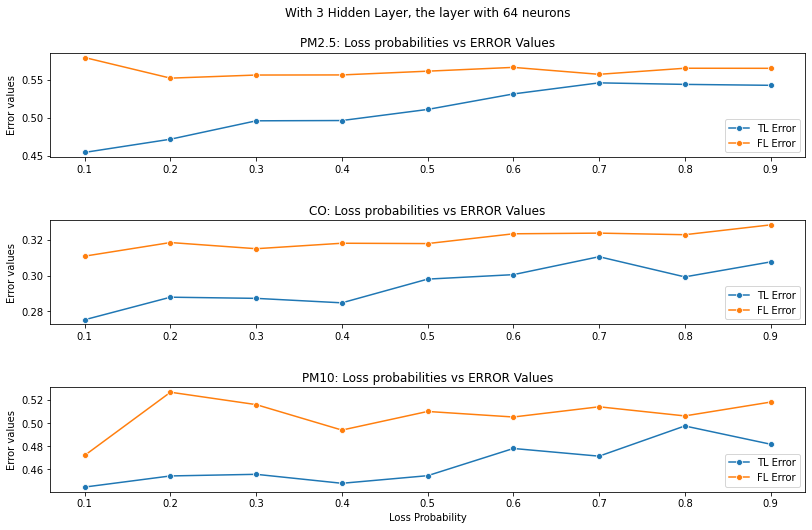

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(12,8))

idx = 0

y_arr = [(np.array(errors_tl_h3_64['PM2.5'])[:,1], np.array(errors_fl_h3_64['PM2.5'])[:,1]), (np.array(errors_tl_h3_64['CO'])[:,1], np.array(errors_fl_h3_64['CO'])[:,1]), 
         (np.array(errors_tl_h3_64['PM10'])[:,1], np.array(errors_fl_h3_64['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("With 3 Hidden Layer, the layer with 64 neurons\n\n{}: Loss probabilities vs ERROR Values".format(gas[row]))
        else:
          axes[row].set_title("{}: Loss probabilities vs ERROR Values".format(gas[row]))

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row])

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error', ax = axes[row])
        
        
        axes[row].set(ylabel='Error values')
        # if row == 1:
        #   axes[row].set(ylim=(0.0, 0.5))
        # else:
        #   axes[row].set(ylim=(0.4, 0.9))
        # plt.legend()
        if row == 2:
          axes[row].set(xlabel='Loss Probability', ylabel='Error values')

        
        idx += 1

title = "With 3 Hidden Layer, the layer with 64 neurons"    
fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

#### Customized plots: 0.5

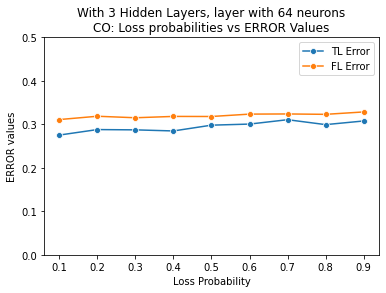

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 0.5))

plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 3 Hidden Layers, layer with 64 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)

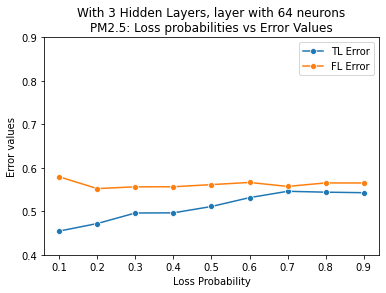

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.4, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 3 Hidden Layers, layer with 64 neurons\nPM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

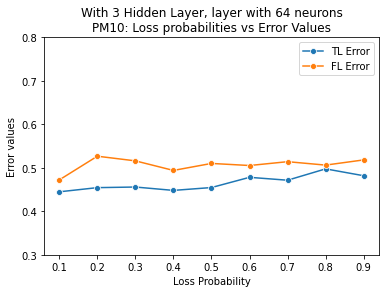

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.3, 0.8))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 3 Hidden Layer, layer with 64 neurons\nPM10: Loss probabilities vs Error Values") 
plt.show(ax)

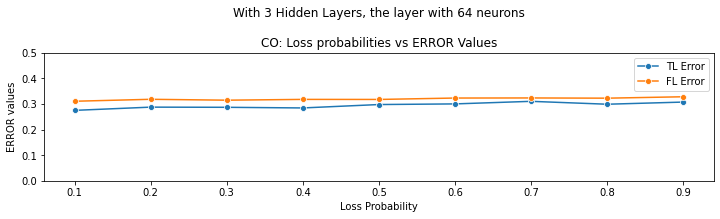

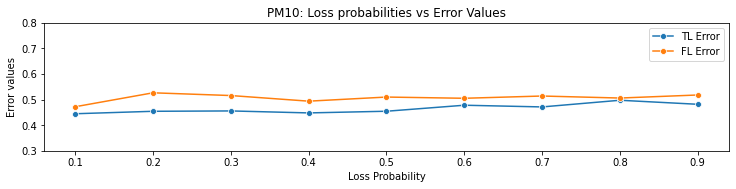

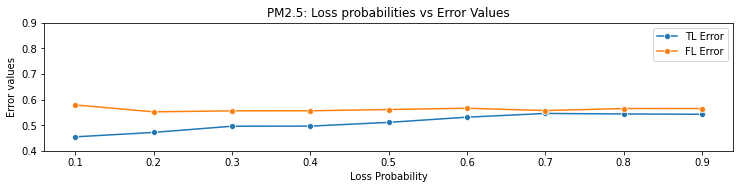

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(3,1,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 0.5))
# ax.set(xlim=(0.1, 0.9))
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 3 Hidden Layers, the layer with 64 neurons\n\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)


plt.figure(figsize=(27, 8))
plt.subplot(3,2,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.3, 0.8))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM10: Loss probabilities vs Error Values") 
plt.show(ax)


plt.figure(figsize=(42, 8))
plt.subplot(3,3,1)
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.4, 0.9))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

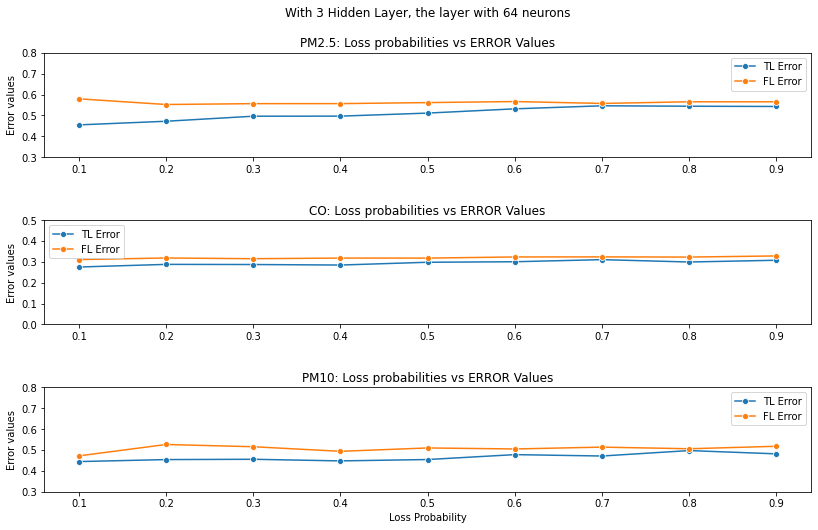

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(12,8))

idx = 0

y_arr = [(np.array(errors_tl_h3_64['PM2.5'])[:,1], np.array(errors_fl_h3_64['PM2.5'])[:,1]), (np.array(errors_tl_h3_64['CO'])[:,1], np.array(errors_fl_h3_64['CO'])[:,1]), 
         (np.array(errors_tl_h3_64['PM10'])[:,1], np.array(errors_fl_h3_64['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("With 3 Hidden Layer, the layer with 64 neurons\n\n{}: Loss probabilities vs ERROR Values".format(gas[row]))
        else:
          axes[row].set_title("{}: Loss probabilities vs ERROR Values".format(gas[row]))

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row])

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error', ax = axes[row])
        
        
        axes[row].set(ylabel='Error values')
        if row == 1:
          axes[row].set(ylim=(0.0, 0.5))
        else:
          axes[row].set(ylim=(0.3, 0.8))
        # plt.legend()
        if row == 2:
          axes[row].set(xlabel='Loss Probability', ylabel='Error values')

        
        idx += 1

title = "With 3 Hidden Layer, the layer with 64 neurons"    
fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

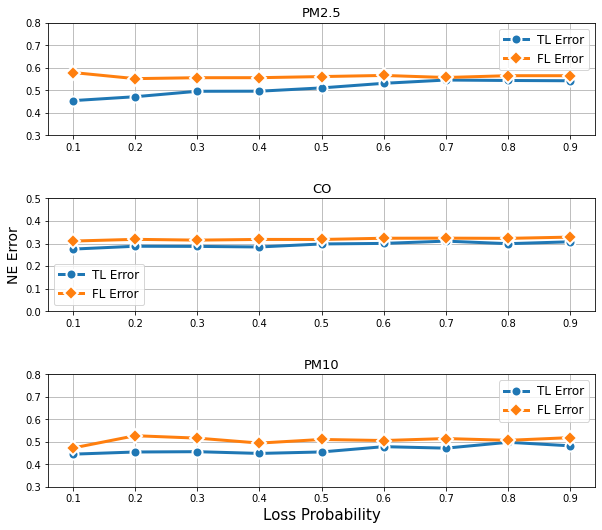

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(9,8))

idx = 0

y_arr = [(np.array(errors_tl_h3_64['PM2.5'])[:,1], np.array(errors_fl_h3_64['PM2.5'])[:,1]), (np.array(errors_tl_h3_64['CO'])[:,1], np.array(errors_fl_h3_64['CO'])[:,1]), 
         (np.array(errors_tl_h3_64['PM10'])[:,1], np.array(errors_fl_h3_64['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("{}".format(gas[row]), fontsize=13)
        else:
          axes[row].set_title("{}".format(gas[row]), fontsize=13)

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row], linewidth=3, ms='10', mew='2')

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="D", dashes=False, label = 'FL Error', ax = axes[row], linewidth=3, ms='10', mew='2')
        
        axes[row].legend(fontsize=12)
        axes[row].grid(True)
        
        if row == 1:
          axes[row].set(ylim=(0.0, 0.5))
          axes[row].set_ylabel('Normalized Error', fontsize=14)
        else:
          axes[row].set(ylim=(0.3, 0.8))

        if row == 2:
          pass
          # axes[row].set(xlabel='Loss Probability', fontsize=14)

        
        idx += 1
plt.xlabel("Loss Probability", fontsize=15)
# plt.ylabel("NE Error Values", loc='center', fontsize=15)
title = "With 1 Hidden Layer, the layer with 64 neurons"    
fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

#### Customized plots: 1.0

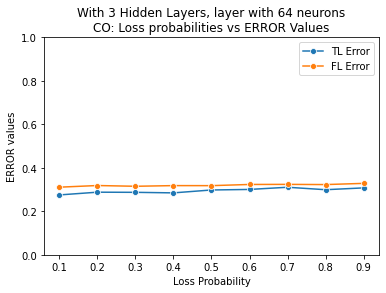

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))

plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 3 Hidden Layers, layer with 64 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)

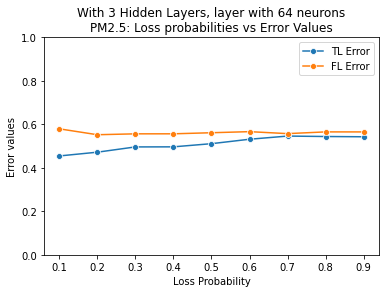

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 3 Hidden Layers, layer with 64 neurons\nPM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

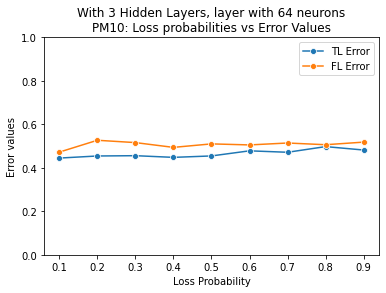

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 3 Hidden Layers, layer with 64 neurons\nPM10: Loss probabilities vs Error Values") 
plt.show(ax)

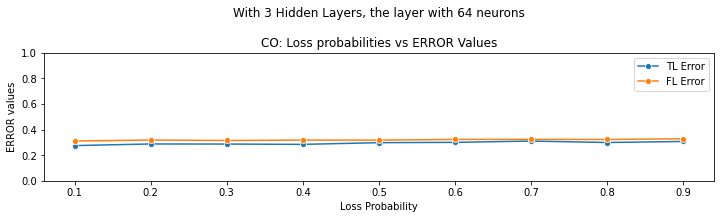

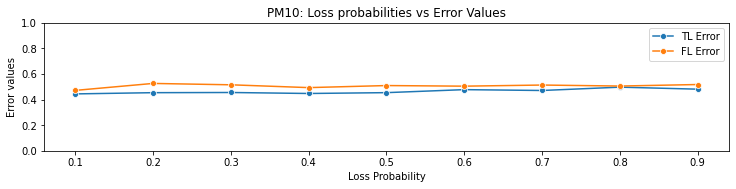

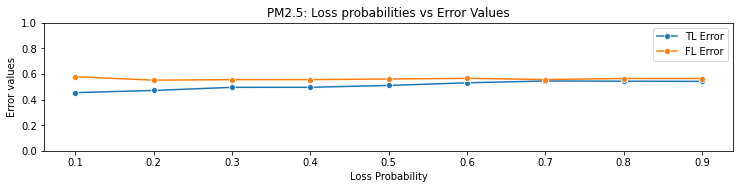

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(3,1,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlim=(0.1, 0.9))
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 3 Hidden Layers, the layer with 64 neurons\n\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)


plt.figure(figsize=(27, 8))
plt.subplot(3,2,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM10: Loss probabilities vs Error Values") 
plt.show(ax)


plt.figure(figsize=(42, 8))
plt.subplot(3,3,1)
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

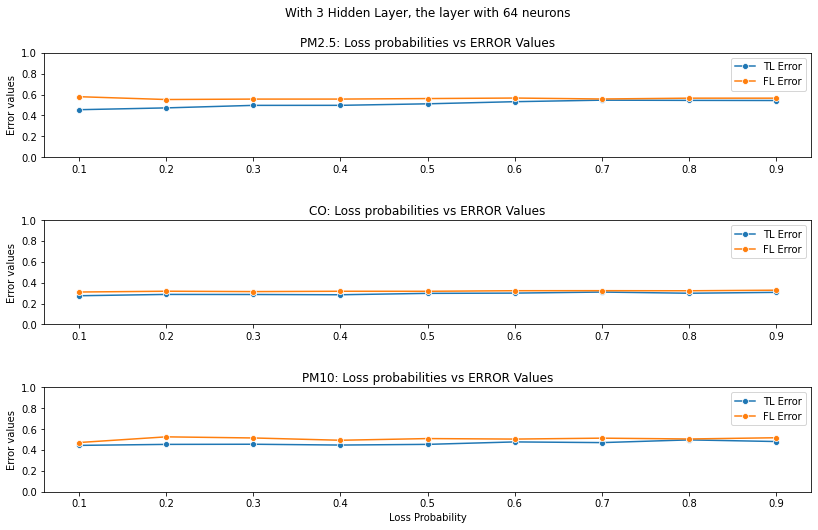

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(12,8))

idx = 0

y_arr = [(np.array(errors_tl_h3_64['PM2.5'])[:,1], np.array(errors_fl_h3_64['PM2.5'])[:,1]), (np.array(errors_tl_h3_64['CO'])[:,1], np.array(errors_fl_h3_64['CO'])[:,1]), 
         (np.array(errors_tl_h3_64['PM10'])[:,1], np.array(errors_fl_h3_64['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("With 3 Hidden Layer, the layer with 64 neurons\n\n{}: Loss probabilities vs ERROR Values".format(gas[row]))
        else:
          axes[row].set_title("{}: Loss probabilities vs ERROR Values".format(gas[row]))

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row])

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error', ax = axes[row])
        
        
        axes[row].set(ylabel='Error values')
        axes[row].set(ylim=(0.0, 1.0))
        
        if row == 2:
          axes[row].set(xlabel='Loss Probability', ylabel='Error values')

        
        idx += 1

title = "With 3 Hidden Layer, the layer with 64 neurons"    
fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

## 4 hidden layer
* with 32 neurons

### traditional Learning

In [ ]:
def traditional_ML_4L_32_train(loss_p, gas, train_data):
  # initialize w_0
  model = Sequential()

  # model.add(Dense(64, kernel_initializer='zeros', bias_initializer='zeros', activation=tf.nn.relu, input_dim=6)) # first dense/hidden layer
  model.add(Dense(32, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu, input_dim=8))
  model.add(Dropout(0.1))

  model.add(Dense(32, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu))
  model.add(Dropout(0.1))

  model.add(Dense(32, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu))
  model.add(Dropout(0.1))

  model.add(Dense(32, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu))
  model.add(Dropout(0.1))
  
  model.add(Dense(1, kernel_initializer= 'he_uniform', activation='linear')) # output layer


  # compile the model
  model.compile(loss='mse', 
              optimizer='adam', 
              metrics=['mse'])
  
  x_train, y_train = train_data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  train_data[gas]

 

  B = 1000 #int(len(x_train) * 0.01) # so for each client the batch size would be different depending upon the total sample size
  E = 25 #max(30, B//10) # number of local epochs; it will also depend on sample size (indirectly)


  model.fit(x_train, y_train, 
                  epochs = E, 
                  batch_size=B,
                  verbose=False)
  
  return model
      


In [ ]:
def traditional_ML_4L_32_test(model_name, gas, test_data):

  ## loading the json and creating model
  json_file = open(model_name + ".json", 'r')
  model_json = json_file.read()
  json_file.close()

  model = model_from_json(model_json)
  model.load_weights(model_name + ".h5")

  ## need to compile the model again after loading
  # compile the model
  model.compile(loss='mse', 
              optimizer='adam', 
              metrics=['mse'])
  

  x_test, y_test = test_data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  test_data[gas]

  x_test, y_test = x_test.to_numpy(), y_test.to_numpy()

  # adjusting the dimensions
  x_test = x_test.reshape(x_test.shape[0],  x_test.shape[1])
  y_test = y_test.reshape(y_test.shape[0],1)
  
  y_predicted = model.predict(x_test)
  

  from sklearn.metrics import mean_squared_error
  mse = mean_squared_error(y_predicted.ravel(), y_test.ravel())

  NE = np.sum(abs(np.array(y_test) - np.array(y_predicted))) / np.sum(np.array(y_test))
  return (mse, NE)


In [ ]:
# Final plotting
K = 25 # as we have 25 clients
train_data = pd.DataFrame()
test_data = pd.DataFrame()
loss_prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
gases = ['CO', 	'PM10',	'PM2.5']
errors_tl_h4_32 = {'CO':[], 	'PM10':[],	'PM2.5':[]}
models = []
model_name = "TL_model_4L_32_"


# for gas in gases:
#   for loss_p in loss_prob:
#     error = traditional_ML_L3_32(loss_p, gas)
#     errors_tl_h3_32[gas].append(error)

for gas in gases:
  for lp in loss_prob:
      for st_code in range(101,126):
          # splitting into train test split
          X, y = clients[st_code][['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  clients[st_code][gas]
          x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = lp, random_state=1)

          # Normalization using min-max scaler
          # Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set.
          # to avoid data leak
          scaler_cols = x_train.columns
          scaler_idx_train = x_train.index
          scaler_idx_test = x_test.index

          # from sklearn.preprocessing import MinMaxScaler
          scaler = MinMaxScaler()

          # transforming train data
          x_train_encoded_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns = scaler_cols, index=scaler_idx_train)
          # display(x_train_encoded_scaled.head())

          # transforming test data
          x_test_encoded_scaled = pd.DataFrame(scaler.transform(x_test), columns = scaler_cols, index = scaler_idx_test)
          # display(x_test_encoded_scaled.head())

          # training data prep
          if st_code == 101:
            train_data = pd.concat([x_train_encoded_scaled, y_train], axis = 1)
          else:
            xy = pd.concat([x_train_encoded_scaled, y_train], axis=1)
            train_data = pd.concat([train_data, xy], axis=0)
          # clients_cut[st_code] = pd.concat([x_train_encoded_scaled, y_train], axis = 1)
          

          # testing data prep
          # first appending x_test and y_test column wise
          # then appending each clients' dataframe one below other
          if st_code == 101:
            test_data = pd.concat([x_test_encoded_scaled, y_test], axis = 1)
          else:
            xy = pd.concat([x_test_encoded_scaled, y_test], axis=1)
            test_data = pd.concat([test_data, xy], axis=0)
          # x_test, y_test = x_test.to_numpy(), y_test.to_numpy()
      
      # Training the model using traditional learning
      # model = traditional_ML_4L_32_train(lp, gas, train_data)

      ## Saving model
      ## serializing model to JSON
      model_address = "/content/drive/MyDrive/Colab Notebooks/Models/" + model_name + gas + str(lp) + "_"


      # model_json = model.to_json()
      # with open(model_address + ".json", "w") as json_file:
      #   json_file.write(model_json)

      # # serialize weights to HDF5
      # model.save_weights(model_address + ".h5")


      ## Testing model
      error = traditional_ML_4L_32_test(model_address, gas, train_data)
      errors_tl_h4_32[gas].append(error)
      # testing model
      # errors_fl_h3_32[gas].append(error_clients_L3_32(model, gas))


### Federated Learning

In [ ]:
# ClientUpdate(k, w): // Run on client k
def Client_L4_32(client_idx, model, gas):
    # B ← (split P_k into batches of size B) # what is p_K --> each clients' sample size
    B = 1000 #int(len(clients[client_idx]) * 0.01) # so for each client the batch size would be different depending upon the total sample size
    E = 25 #max(30, B//10) # number of local epochs; it will also depend on sample size (indirectly)

    data = clients_cut[client_idx]
    # data = dataset.loc[dataset['Station code'] == client_idx]

    X, y = data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  data[gas]

    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state=1)

    try:
        model.fit(x_train, y_train, 
                    epochs = E, 
                    batch_size=B,
                    validation_data=(x_val, y_val),
                    verbose=False)
    except Exception as e:
        print(e)
        print("error")

    # return w to server
    # in our case no need for any explicit return; as the model is pass by value
    return data.shape[0] # this will return the number of total sample


In [ ]:
# Server executes: 
def Server_L4_32(gas):
    # initialize w_0
    model = Sequential()

    # model.add(Dense(64, kernel_initializer='zeros', bias_initializer='zeros', activation=tf.nn.relu, input_dim=6)) # first dense/hidden layer
    model.add(Dense(32, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu, input_dim=8))
    model.add(Dropout(0.1))

    model.add(Dense(32, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu))
    model.add(Dropout(0.1))

    model.add(Dense(32, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu))
    model.add(Dropout(0.1))

    model.add(Dense(32, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu))
    model.add(Dropout(0.1))
    
    model.add(Dense(1, kernel_initializer= 'he_uniform', activation='linear')) # output layer


    # compile the model
    model.compile(loss='mse', 
                optimizer='adam', 
                metrics=['mse'])
    

# for each round t = 1, 2, . . . do
    for t in range(1, 5):
        C = np.random.random(1)[0] # random number between 0 and 1.

        # m ← max(C  K, 1)
        m = max(int(C*K), 1) # m == random number of client selected
        weight_t_plus_1 = [None] * m # matrix to store the weights of all client in each t-round
        n_k = [None] * m # parameters for weighted sum 


        # S_t ← (random set of m clients)
        # S = {} # dictionary
        S_t = np.random.uniform(low=101, high=126, size=(m)).astype(int)

        # No need for below loop, as server don't need access to client data, server only need clients' number
        # for client in m_clients:
        #   S[client] = clients[client]

        initial_weights = model.get_weights() # setting initial weights; should be same for all clients
        # for t= 1 to T, initial_weights would be t-1th's final weights

        # for each client k ∈ S_t in parallel do
        client_idx = 0
        for client in S_t:
            # w^(k)_(t+1) ← ClientUpdate(k, model)
            n_k[client_idx] = Client_L4_32(client, model, gas) # pass by reference for model
            weight_t_plus_1[client_idx] = model.get_weights()
            client_idx += 1

            # setting weights back to initial weights
            model.set_weights(initial_weights)

        # finding the weighted sum
        final_weights_t = np.array(weight_t_plus_1[0]) * (n_k[0] / sum(n_k))

        for idx in range(1, m):
          # w_(t+1) ← summation(k=1 to K){(n_k/n) * w^(k)_(t+1)} #n_k - no. of training sample in each client K; n - total training samples;
          final_weights_t += np.array(weight_t_plus_1[idx]) * (n_k[idx]/ sum(n_k))

        # setting the aggregated weights
        model.set_weights(final_weights_t)


#         print(model.get_weights())
    # return error_clients(model, loss_p)) # THIS LINE WON'T BE THERE IN REAL SERVER
    return model

In [ ]:
def error_clients_L4_32(model_name, gas, test_data):

    ## loading the json and creating model
    json_file = open(model_name + ".json", 'r')
    model_json = json_file.read()
    json_file.close()

    model = model_from_json(model_json)
    model.load_weights(model_name + ".h5")

    ## need to compile the model again after loading
    # compile the model
    model.compile(loss='mse', 
                optimizer='adam', 
                metrics=['mse'])
  
    
    X, y = test_data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  test_data[gas]
    
    # adjusting the dimensions
    x_test, y_test = X.to_numpy(), y.to_numpy()
    x_test = x_test.reshape(x_test.shape[0],  x_test.shape[1])
    y_test = y_test.reshape(y_test.shape[0],1)

    y_predicted = model.predict(x_test)
    
    from sklearn.metrics import mean_squared_error
    # print("y_predicted", y_predicted)
    # print("y_predicted.ravel()", y_predicted.ravel())
    NE = np.sum(abs(np.array(y_test) - np.array(y_predicted))) / np.sum(np.array(y_test))

    mse = mean_squared_error(y_predicted.ravel(), y_test.ravel())
    
    return (mse,NE)

          

In [ ]:

# create an Empty DataFrame object
train_data = pd.DataFrame()
test_data = pd.DataFrame()
loss_prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
models = []
errors_fl_h4_32 = {'CO':[], 	'PM10':[],	'PM2.5':[]}
gases = ['CO', 	'PM10',	'PM2.5']
model_name = "FL_model_4L_32_"


# reading all the clients and building model
for gas in gases:
  for lp in loss_prob:
      for st_code in range(101,126):
          # splitting into train test split
          X, y = clients[st_code][['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  clients[st_code][gas]
          x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = lp, random_state=1)

          # Normalization using min-max scaler
          # Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set.
          # to avoid data leak
          scaler_cols = x_train.columns
          scaler_idx_train = x_train.index
          scaler_idx_test = x_test.index

          # from sklearn.preprocessing import MinMaxScaler
          scaler = MinMaxScaler()

          # transforming train data
          x_train_encoded_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns = scaler_cols, index=scaler_idx_train)
          # display(x_train_encoded_scaled.head())

          # transforming test data
          x_test_encoded_scaled = pd.DataFrame(scaler.transform(x_test), columns = scaler_cols, index = scaler_idx_test)
          # display(x_test_encoded_scaled.head())

          # training data prep
          clients_cut[st_code] = pd.concat([x_train_encoded_scaled, y_train], axis = 1)

          # testing data prep
          # first appending x_test and y_test column wise
          # then appending each clients' dataframe one below other
          if st_code == 101:
            test_data = pd.concat([x_test_encoded_scaled, y_test], axis = 1)
          else:
            xy = pd.concat([x_test_encoded_scaled, y_test], axis=1)
            test_data = pd.concat([test_data, xy], axis=0)
          # x_test, y_test = x_test.to_numpy(), y_test.to_numpy()

      # # Training the model using federated learning
      # model = Server_L4_32(gas)

      ## Saving model
      ## serializing model to JSON
      model_address = "/content/drive/MyDrive/Colab Notebooks/Models/" + model_name + gas + str(lp) + "_"


      # model_json = model.to_json()
      # with open(model_address + ".json", "w") as json_file:
      #   json_file.write(model_json)

      # # serialize weights to HDF5
      # model.save_weights(model_address + ".h5")


      ## Testing model
      error = error_clients_L4_32(model_address, gas, test_data)
      errors_fl_h4_32[gas].append(error)


### Plots

#### Original plots

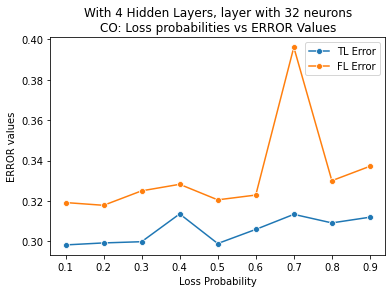

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.2, 0.5))

plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 4 Hidden Layers, layer with 32 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)

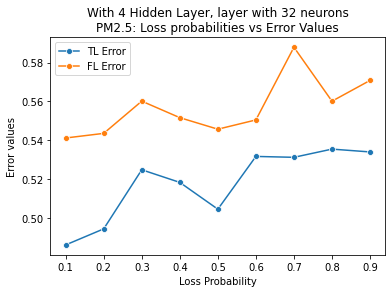

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.96, 0.9625))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 4 Hidden Layer, layer with 32 neurons\nPM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

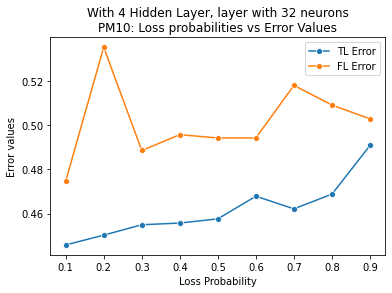

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.977, 0.979))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 4 Hidden Layer, layer with 32 neurons\nPM10: Loss probabilities vs Error Values") 
plt.show(ax)

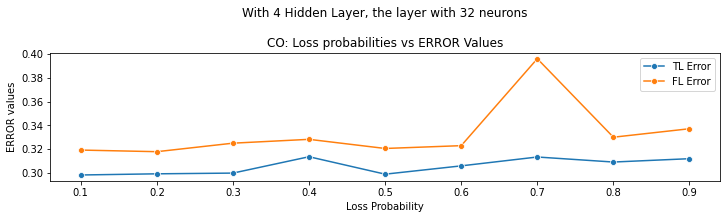

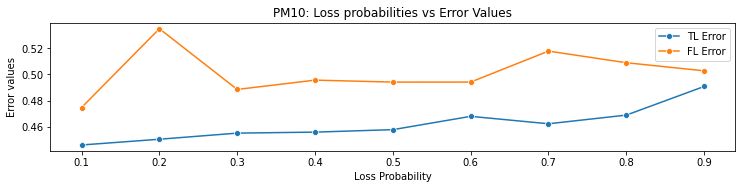

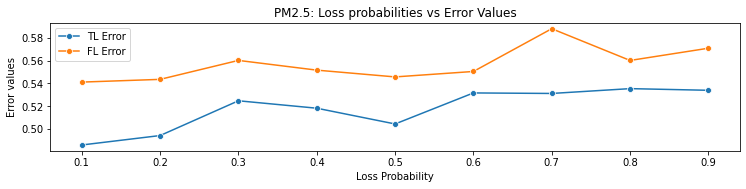

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(3,1,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.2, 0.5))
# ax.set(xlim=(0.1, 0.9))
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 4 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)


plt.figure(figsize=(27, 8))
plt.subplot(3,2,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.977, 0.979))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM10: Loss probabilities vs Error Values") 
plt.show(ax)


plt.figure(figsize=(42, 8))
plt.subplot(3,3,1)
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.96, 0.9625))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

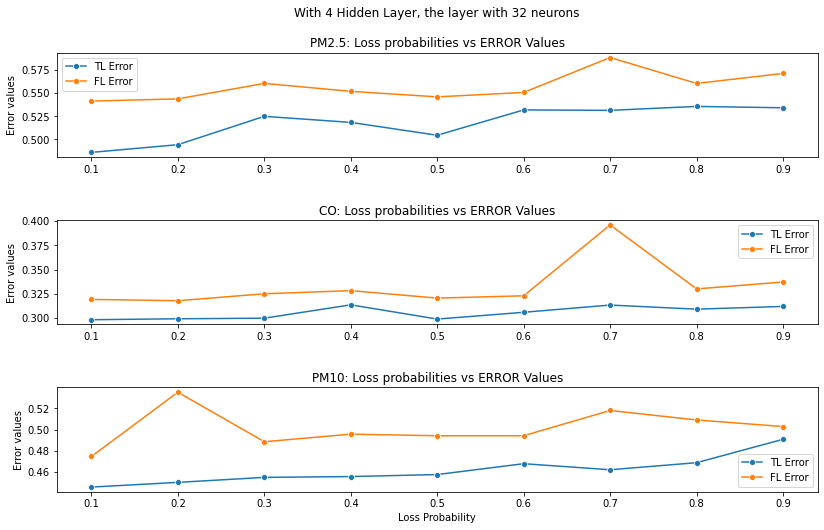

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(12,8))

idx = 0

y_arr = [(np.array(errors_tl_h4_32['PM2.5'])[:,1], np.array(errors_fl_h4_32['PM2.5'])[:,1]), (np.array(errors_tl_h4_32['CO'])[:,1], np.array(errors_fl_h4_32['CO'])[:,1]), 
         (np.array(errors_tl_h4_32['PM10'])[:,1], np.array(errors_fl_h4_32['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("With 4 Hidden Layer, the layer with 32 neurons\n\n{}: Loss probabilities vs ERROR Values".format(gas[row]))
        else:
          axes[row].set_title("{}: Loss probabilities vs ERROR Values".format(gas[row]))

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row])

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error', ax = axes[row])
        
        
        axes[row].set(ylabel='Error values')
        # if row == 1:
        #   axes[row].set(ylim=(0.0, 0.5))
        # else:
        #   axes[row].set(ylim=(0.3, 0.8))
        # plt.legend()
        if row == 2:
          axes[row].set(xlabel='Loss Probability', ylabel='Error values')

        
        idx += 1

title = "With 4 Hidden Layer, the layer with 32 neurons"    
fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

#### Customized plots: 0.5

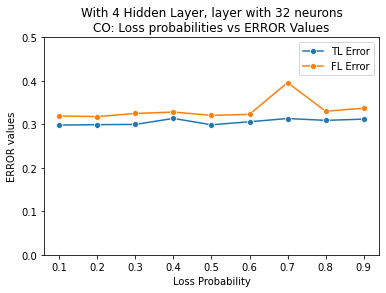

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 0.5))

plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 4 Hidden Layer, layer with 32 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)

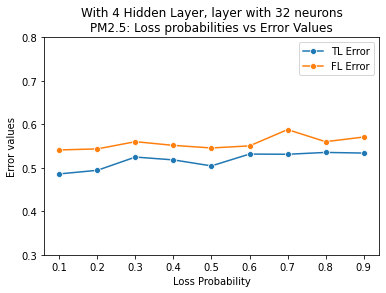

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.3, 0.8))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 4 Hidden Layer, layer with 32 neurons\nPM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

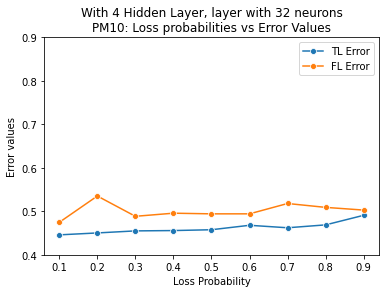

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.4, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 4 Hidden Layer, layer with 32 neurons\nPM10: Loss probabilities vs Error Values") 
plt.show(ax)

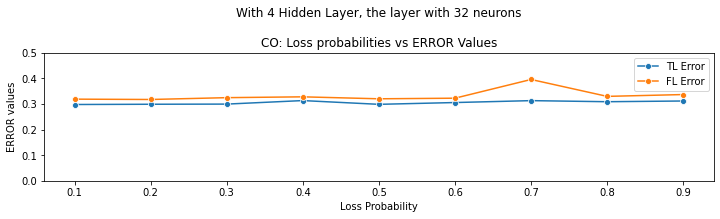

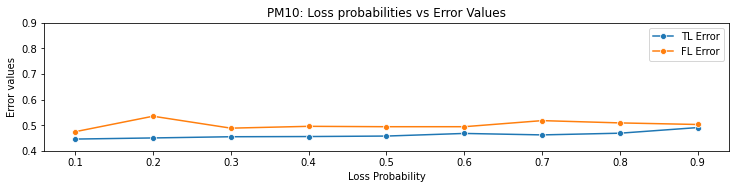

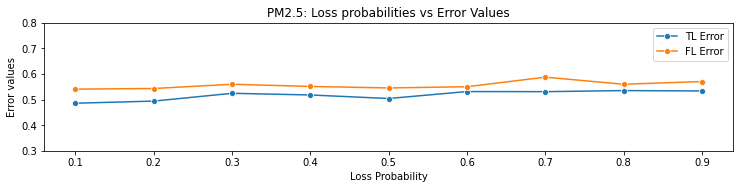

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(3,1,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 0.5))
# ax.set(xlim=(0.1, 0.9))
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 4 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)


plt.figure(figsize=(27, 8))
plt.subplot(3,2,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.4, 0.9))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM10: Loss probabilities vs Error Values") 
plt.show(ax)


plt.figure(figsize=(42, 8))
plt.subplot(3,3,1)
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.3, 0.8))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


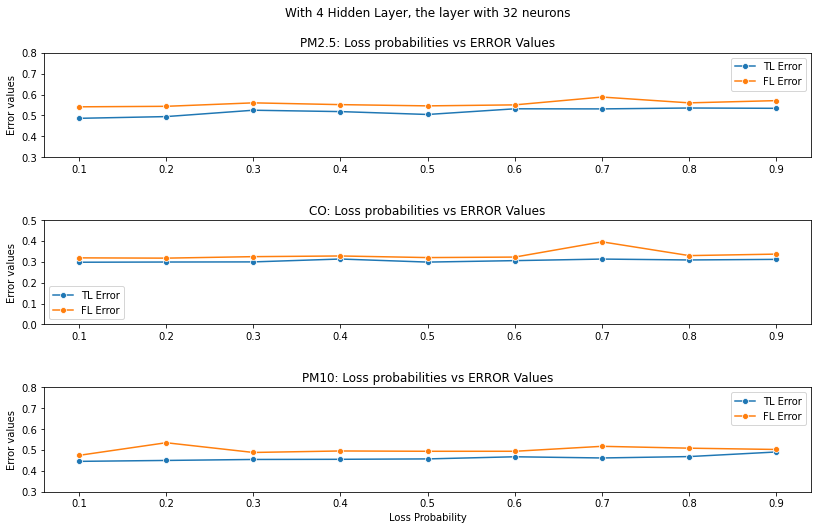

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(12,8))

idx = 0

y_arr = [(np.array(errors_tl_h4_32['PM2.5'])[:,1], np.array(errors_fl_h4_32['PM2.5'])[:,1]), (np.array(errors_tl_h4_32['CO'])[:,1], np.array(errors_fl_h4_32['CO'])[:,1]), 
         (np.array(errors_tl_h4_32['PM10'])[:,1], np.array(errors_fl_h4_32['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("With 4 Hidden Layer, the layer with 32 neurons\n\n{}: Loss probabilities vs ERROR Values".format(gas[row]))
        else:
          axes[row].set_title("{}: Loss probabilities vs ERROR Values".format(gas[row]))

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row])

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error', ax = axes[row])
        
        
        axes[row].set(ylabel='Error values')
        if row == 1:
          axes[row].set(ylim=(0.0, 0.5))
        else:
          axes[row].set(ylim=(0.3, 0.8))
        plt.legend()
        if row == 2:
          axes[row].set(xlabel='Loss Probability', ylabel='Error values')

        
        idx += 1

title = "With 4 Hidden Layer, the layer with 32 neurons"    
fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

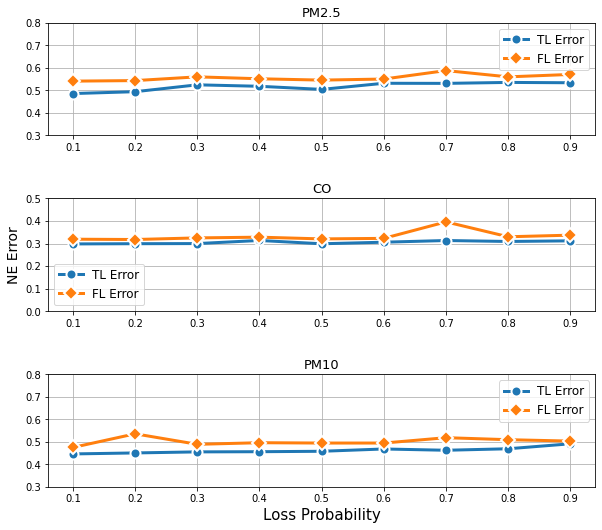

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(9,8))

idx = 0

y_arr = [(np.array(errors_tl_h4_32['PM2.5'])[:,1], np.array(errors_fl_h4_32['PM2.5'])[:,1]), (np.array(errors_tl_h4_32['CO'])[:,1], np.array(errors_fl_h4_32['CO'])[:,1]), 
         (np.array(errors_tl_h4_32['PM10'])[:,1], np.array(errors_fl_h4_32['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("{}".format(gas[row]), fontsize=13)
        else:
          axes[row].set_title("{}".format(gas[row]), fontsize=13)

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row], linewidth=3, ms='10', mew='2')

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="D", dashes=False, label = 'FL Error', ax = axes[row], linewidth=3, ms='10', mew='2')
        
        axes[row].legend(fontsize=12)
        axes[row].grid(True)
        
        if row == 1:
          axes[row].set(ylim=(0.0, 0.5))
          axes[row].set_ylabel('NE Error', fontsize=14)
        else:
          axes[row].set(ylim=(0.3, 0.8))

        if row == 2:
          pass
          # axes[row].set(xlabel='Loss Probability', fontsize=14)

        
        idx += 1
plt.xlabel("Loss Probability", fontsize=15)
# # plt.ylabel("NE Error Values", loc='center', fontsize=15)
# title = "With 1 Hidden Layer, the layer with 64 neurons"    
# fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

#### Customized plots: 1.0

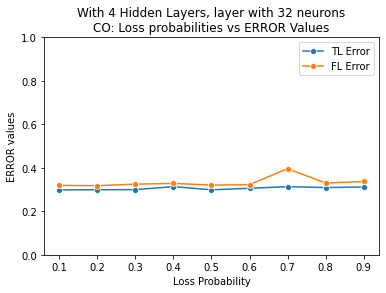

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))

plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 4 Hidden Layers, layer with 32 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)

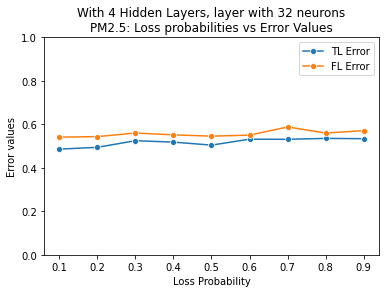

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 4 Hidden Layers, layer with 32 neurons\nPM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

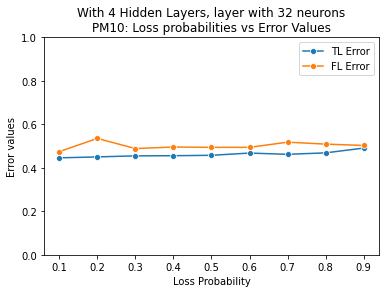

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 4 Hidden Layers, layer with 32 neurons\nPM10: Loss probabilities vs Error Values") 
plt.show(ax)

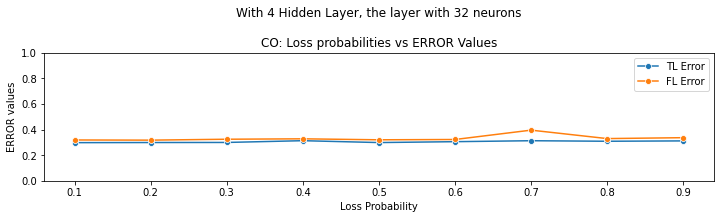

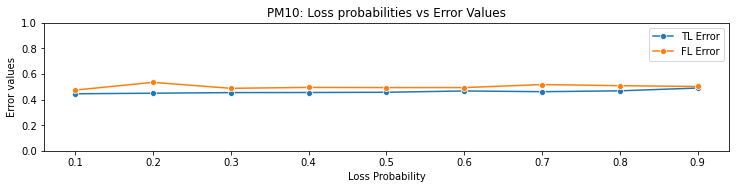

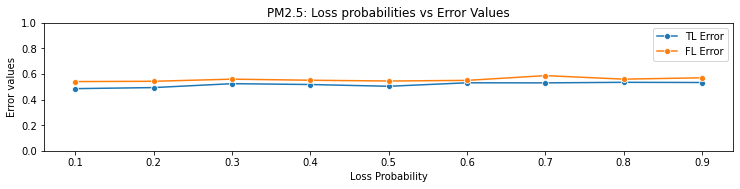

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(3,1,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlim=(0.1, 0.9))
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 4 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)


plt.figure(figsize=(27, 8))
plt.subplot(3,2,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_32['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM10: Loss probabilities vs Error Values") 
plt.show(ax)


plt.figure(figsize=(42, 8))
plt.subplot(3,3,1)
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_32['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

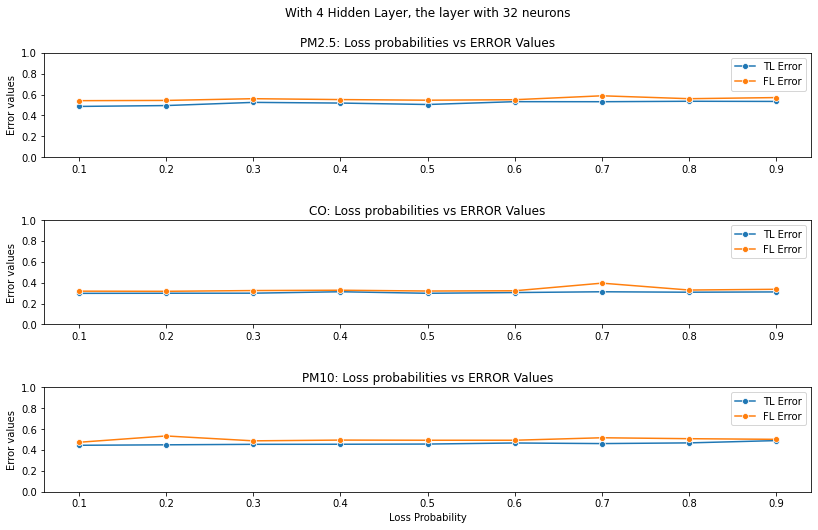

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(12,8))

idx = 0

y_arr = [(np.array(errors_tl_h4_32['PM2.5'])[:,1], np.array(errors_fl_h4_32['PM2.5'])[:,1]), (np.array(errors_tl_h4_32['CO'])[:,1], np.array(errors_fl_h4_32['CO'])[:,1]), 
         (np.array(errors_tl_h4_32['PM10'])[:,1], np.array(errors_fl_h4_32['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("With 4 Hidden Layer, the layer with 32 neurons\n\n{}: Loss probabilities vs ERROR Values".format(gas[row]))
        else:
          axes[row].set_title("{}: Loss probabilities vs ERROR Values".format(gas[row]))

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row])

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error', ax = axes[row])
        
        
        axes[row].set(ylabel='Error values')
        axes[row].set(ylim=(0.0, 1.0))
 
        if row == 2:
          axes[row].set(xlabel='Loss Probability', ylabel='Error values')

        
        idx += 1

title = "With 4 Hidden Layer, the layer with 32 neurons"    
fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

## 4 hidden layers
* with 64 neurons

### traditional Learning

In [ ]:
def traditional_ML_4L_64_train(loss_p, gas, train_data):
  # initialize w_0
  # initialize w_0
  model = Sequential()

  # model.add(Dense(64, kernel_initializer='zeros', bias_initializer='zeros', activation=tf.nn.relu, input_dim=6)) # first dense/hidden layer
  model.add(Dense(64, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu, input_dim=8))
  model.add(Dropout(0.1))

  model.add(Dense(64, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu))
  model.add(Dropout(0.1))

  model.add(Dense(64, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu))
  model.add(Dropout(0.1))

  model.add(Dense(64, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu))
  model.add(Dropout(0.1))
  
  model.add(Dense(1, kernel_initializer= 'he_uniform', activation='linear')) # output layer


  # compile the model
  model.compile(loss='mse', 
              optimizer='adam', 
              metrics=['mse'])
  
  x_train, y_train = train_data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  train_data[gas]

 

  B = 1000 #int(len(x_train) * 0.01) # so for each client the batch size would be different depending upon the total sample size
  E = 25 #max(30, B//10) # number of local epochs; it will also depend on sample size (indirectly)


  model.fit(x_train, y_train, 
                  epochs = E, 
                  batch_size=B,
                  verbose=False)
  
  return model
      


In [ ]:
def traditional_ML_4L_64_test(model_name, gas, test_data):

  ## loading the json and creating model
  json_file = open(model_name + ".json", 'r')
  model_json = json_file.read()
  json_file.close()

  model = model_from_json(model_json)
  model.load_weights(model_name + ".h5")

  ## need to compile the model again after loading
  # compile the model
  model.compile(loss='mse', 
              optimizer='adam', 
              metrics=['mse'])
  

  x_test, y_test = test_data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  test_data[gas]

  x_test, y_test = x_test.to_numpy(), y_test.to_numpy()

  # adjusting the dimensions
  x_test = x_test.reshape(x_test.shape[0],  x_test.shape[1])
  y_test = y_test.reshape(y_test.shape[0],1)
  
  y_predicted = model.predict(x_test)
  

  from sklearn.metrics import mean_squared_error
  mse = mean_squared_error(y_predicted.ravel(), y_test.ravel())

  NE = np.sum(abs(np.array(y_test) - np.array(y_predicted))) / np.sum(np.array(y_test))
  return (mse, NE)


In [ ]:
# Final plotting
K = 25 # as we have 25 clients
train_data = pd.DataFrame()
test_data = pd.DataFrame()
loss_prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
gases = ['CO', 	'PM10',	'PM2.5']
errors_tl_h4_64 = {'CO':[], 	'PM10':[],	'PM2.5':[]}
models = []
model_name = "TL_model_4L_64_"


# for gas in gases:
#   for loss_p in loss_prob:
#     error = traditional_ML_L3_32(loss_p, gas)
#     errors_tl_h3_32[gas].append(error)

for gas in gases:
  for lp in loss_prob:
      for st_code in range(101,126):
          # splitting into train test split
          X, y = clients[st_code][['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  clients[st_code][gas]
          x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = lp, random_state=1)

          # Normalization using min-max scaler
          # Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set.
          # to avoid data leak
          scaler_cols = x_train.columns
          scaler_idx_train = x_train.index
          scaler_idx_test = x_test.index

          # from sklearn.preprocessing import MinMaxScaler
          scaler = MinMaxScaler()

          # transforming train data
          x_train_encoded_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns = scaler_cols, index=scaler_idx_train)
          # display(x_train_encoded_scaled.head())

          # transforming test data
          x_test_encoded_scaled = pd.DataFrame(scaler.transform(x_test), columns = scaler_cols, index = scaler_idx_test)
          # display(x_test_encoded_scaled.head())

          # training data prep
          if st_code == 101:
            train_data = pd.concat([x_train_encoded_scaled, y_train], axis = 1)
          else:
            xy = pd.concat([x_train_encoded_scaled, y_train], axis=1)
            train_data = pd.concat([train_data, xy], axis=0)
          # clients_cut[st_code] = pd.concat([x_train_encoded_scaled, y_train], axis = 1)
          

          # testing data prep
          # first appending x_test and y_test column wise
          # then appending each clients' dataframe one below other
          if st_code == 101:
            test_data = pd.concat([x_test_encoded_scaled, y_test], axis = 1)
          else:
            xy = pd.concat([x_test_encoded_scaled, y_test], axis=1)
            test_data = pd.concat([test_data, xy], axis=0)
          # x_test, y_test = x_test.to_numpy(), y_test.to_numpy()
      
      # Training the model using traditional learning
      # model = traditional_ML_4L_64_train(lp, gas, train_data)

      ## Saving model
      ## serializing model to JSON
      model_address = "/content/drive/MyDrive/Colab Notebooks/Models/" + model_name + gas + str(lp) + "_"


      # model_json = model.to_json()
      # with open(model_address + ".json", "w") as json_file:
      #   json_file.write(model_json)

      # # serialize weights to HDF5
      # model.save_weights(model_address + ".h5")


      ## Testing model
      error = traditional_ML_4L_64_test(model_address, gas, train_data)
      errors_tl_h4_64[gas].append(error)
      # testing model
      # errors_fl_h3_32[gas].append(error_clients_L3_32(model, gas))


### Federated Learning

In [ ]:
# ClientUpdate(k, w): // Run on client k
def Client_L4_64(client_idx, model, gas):
    # B ← (split P_k into batches of size B) # what is p_K --> each clients' sample size
    B = 1000 #int(len(clients[client_idx]) * 0.01) # so for each client the batch size would be different depending upon the total sample size
    E = 25 #max(30, B//10) # number of local epochs; it will also depend on sample size (indirectly)

    data = clients_cut[client_idx]
    # data = dataset.loc[dataset['Station code'] == client_idx]

    X, y = data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  data[gas]

    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state=1)

    try:
        model.fit(x_train, y_train, 
                    epochs = E, 
                    batch_size=B,
                    validation_data=(x_val, y_val),
                    verbose=False)
    except Exception as e:
        print(e)
        print("error")

    # return w to server
    # in our case no need for any explicit return; as the model is pass by value
    return data.shape[0] # this will return the number of total sample


In [ ]:
# Server executes: 
def Server_L4_64(gas):
    # initialize w_0
    # initialize w_0
    model = Sequential()


    # model.add(Dense(64, kernel_initializer='zeros', bias_initializer='zeros', activation=tf.nn.relu, input_dim=6)) # first dense/hidden layer
    model.add(Dense(64, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu, input_dim=8))
    model.add(Dropout(0.1))

    model.add(Dense(64, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu))
    model.add(Dropout(0.1))

    model.add(Dense(64, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu))
    model.add(Dropout(0.1))

    model.add(Dense(64, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu))
    model.add(Dropout(0.1))
    
    model.add(Dense(1, kernel_initializer= 'he_uniform', activation='linear')) # output layer


    # compile the model
    model.compile(loss='mse', 
                optimizer='adam', 
                metrics=['mse'])
    

# for each round t = 1, 2, . . . do
    for t in range(1, 5):
        C = np.random.random(1)[0] # random number between 0 and 1.

        # m ← max(C  K, 1)
        m = max(int(C*K), 1) # m == random number of client selected
        weight_t_plus_1 = [None] * m # matrix to store the weights of all client in each t-round
        n_k = [None] * m # parameters for weighted sum 


        # S_t ← (random set of m clients)
        # S = {} # dictionary
        S_t = np.random.uniform(low=101, high=126, size=(m)).astype(int)

        # No need for below loop, as server don't need access to client data, server only need clients' number
        # for client in m_clients:
        #   S[client] = clients[client]

        initial_weights = model.get_weights() # setting initial weights; should be same for all clients
        # for t= 1 to T, initial_weights would be t-1th's final weights

        # for each client k ∈ S_t in parallel do
        client_idx = 0
        for client in S_t:
            # w^(k)_(t+1) ← ClientUpdate(k, model)
            n_k[client_idx] = Client_L4_64(client, model, gas) # pass by reference for model
            weight_t_plus_1[client_idx] = model.get_weights()
            client_idx += 1

            # setting weights back to initial weights
            model.set_weights(initial_weights)

        # finding the weighted sum
        final_weights_t = np.array(weight_t_plus_1[0]) * (n_k[0] / sum(n_k))

        for idx in range(1, m):
          # w_(t+1) ← summation(k=1 to K){(n_k/n) * w^(k)_(t+1)} #n_k - no. of training sample in each client K; n - total training samples;
          final_weights_t += np.array(weight_t_plus_1[idx]) * (n_k[idx]/ sum(n_k))

        # setting the aggregated weights
        model.set_weights(final_weights_t)


#         print(model.get_weights())
    # return error_clients(model, loss_p)) # THIS LINE WON'T BE THERE IN REAL SERVER
    return model

In [ ]:
def error_clients_L4_64(model_name, gas, test_data):

    ## loading the json and creating model
    json_file = open(model_name + ".json", 'r')
    model_json = json_file.read()
    json_file.close()

    model = model_from_json(model_json)
    model.load_weights(model_name + ".h5")

    ## need to compile the model again after loading
    # compile the model
    model.compile(loss='mse', 
                optimizer='adam', 
                metrics=['mse'])
  
    
    X, y = test_data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  test_data[gas]
    
    # adjusting the dimensions
    x_test, y_test = X.to_numpy(), y.to_numpy()
    x_test = x_test.reshape(x_test.shape[0],   x_test.shape[1])
    y_test = y_test.reshape(y_test.shape[0],1)

    y_predicted = model.predict(x_test)
    
    from sklearn.metrics import mean_squared_error
    # print("y_predicted", y_predicted)
    # print("y_predicted.ravel()", y_predicted.ravel())
    NE = np.sum(abs(np.array(y_test) - np.array(y_predicted))) / np.sum(np.array(y_test))

    mse = mean_squared_error(y_predicted.ravel(), y_test.ravel())
    
    return (mse,NE)

          

In [ ]:

# create an Empty DataFrame object
train_data = pd.DataFrame()
test_data = pd.DataFrame()
loss_prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
models = []
errors_fl_h4_64 = {'CO':[], 	'PM10':[],	'PM2.5':[]}
gases = ['CO', 	'PM10',	'PM2.5']
model_name = "FL_model_4L_64_"


# reading all the clients and building model
for gas in gases:
  for lp in loss_prob:
      for st_code in range(101,126):
          # splitting into train test split
          X, y = clients[st_code][['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  clients[st_code][gas]
          x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = lp, random_state=1)

          # Normalization using min-max scaler
          # Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set.
          # to avoid data leak
          scaler_cols = x_train.columns
          scaler_idx_train = x_train.index
          scaler_idx_test = x_test.index

          # from sklearn.preprocessing import MinMaxScaler
          scaler = MinMaxScaler()

          # transforming train data
          x_train_encoded_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns = scaler_cols, index=scaler_idx_train)
          # display(x_train_encoded_scaled.head())

          # transforming test data
          x_test_encoded_scaled = pd.DataFrame(scaler.transform(x_test), columns = scaler_cols, index = scaler_idx_test)
          # display(x_test_encoded_scaled.head())

          # training data prep
          clients_cut[st_code] = pd.concat([x_train_encoded_scaled, y_train], axis = 1)

          # testing data prep
          # first appending x_test and y_test column wise
          # then appending each clients' dataframe one below other
          if st_code == 101:
            test_data = pd.concat([x_test_encoded_scaled, y_test], axis = 1)
          else:
            xy = pd.concat([x_test_encoded_scaled, y_test], axis=1)
            test_data = pd.concat([test_data, xy], axis=0)
          # x_test, y_test = x_test.to_numpy(), y_test.to_numpy()

      # Training the model using federated learning
      # model = Server_L4_64(gas)

      ## Saving model
      ## serializing model to JSON
      model_address = "/content/drive/MyDrive/Colab Notebooks/Models/" + model_name + gas + str(lp) + "_"


      # model_json = model.to_json()
      # with open(model_address + ".json", "w") as json_file:
      #   json_file.write(model_json)

      # # serialize weights to HDF5
      # model.save_weights(model_address + ".h5")


      ## Testing model
      error = error_clients_L4_64(model_address, gas, test_data)
      errors_fl_h4_64[gas].append(error)


### Plots

#### Original plots

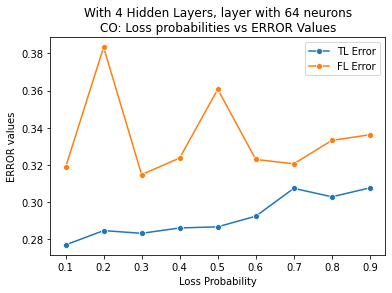

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.2, 0.5))

plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 4 Hidden Layers, layer with 64 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)

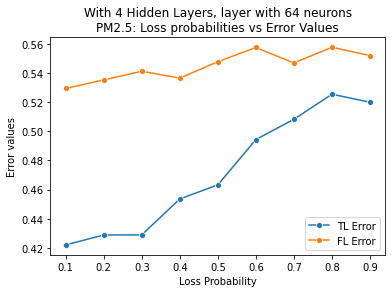

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.96, 0.9625))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 4 Hidden Layers, layer with 64 neurons\nPM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

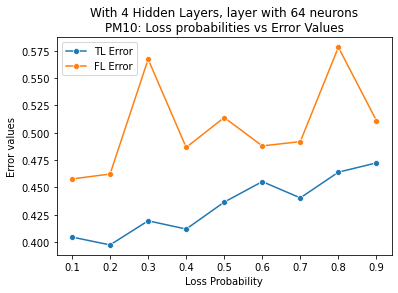

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.977, 0.979))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 4 Hidden Layers, layer with 64 neurons\nPM10: Loss probabilities vs Error Values") 
plt.show(ax)

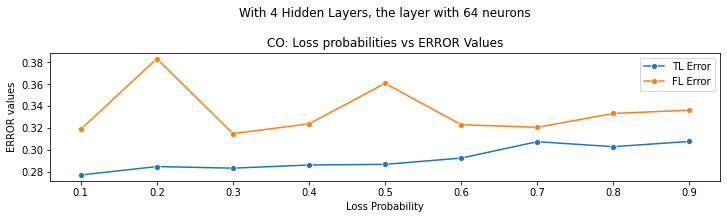

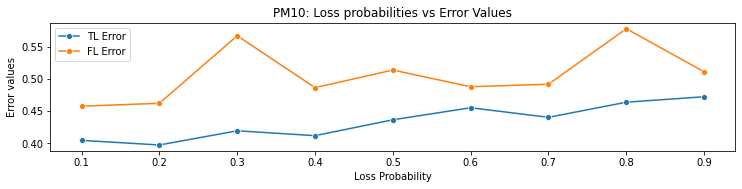

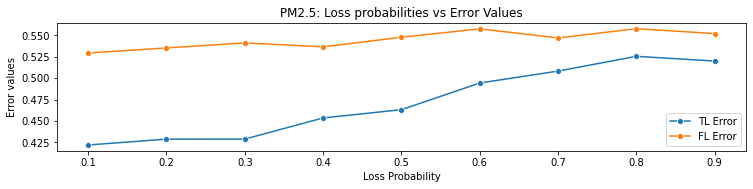

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(3,1,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.2, 0.5))
# ax.set(xlim=(0.1, 0.9))
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 4 Hidden Layers, the layer with 64 neurons\n\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)


plt.figure(figsize=(27, 8))
plt.subplot(3,2,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.977, 0.979))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM10: Loss probabilities vs Error Values") 
plt.show(ax)


plt.figure(figsize=(42, 8))
plt.subplot(3,3,1)
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

# ax.set(ylim=(0.96, 0.9625))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

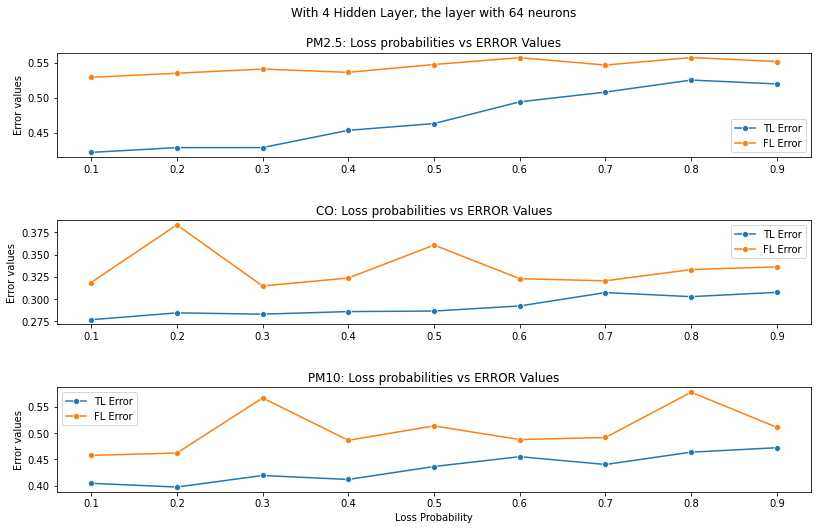

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(12,8))

idx = 0

y_arr = [(np.array(errors_tl_h4_64['PM2.5'])[:,1], np.array(errors_fl_h4_64['PM2.5'])[:,1]), (np.array(errors_tl_h4_64['CO'])[:,1], np.array(errors_fl_h4_64['CO'])[:,1]), 
         (np.array(errors_tl_h4_64['PM10'])[:,1], np.array(errors_fl_h4_64['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("With 4 Hidden Layer, the layer with 64 neurons\n\n{}: Loss probabilities vs ERROR Values".format(gas[row]))
        else:
          axes[row].set_title("{}: Loss probabilities vs ERROR Values".format(gas[row]))

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row])

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error', ax = axes[row])
        
        
        axes[row].set(ylabel='Error values')
        # if row == 1:
        #   axes[row].set(ylim=(0.0, 0.5))
        # else:
        #   axes[row].set(ylim=(0.3, 0.8))
        # plt.legend()
        if row == 2:
          axes[row].set(xlabel='Loss Probability', ylabel='Error values')

        
        idx += 1

title = "With 4 Hidden Layer, the layer with 64 neurons"    
fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

#### Customized plots: 0.5

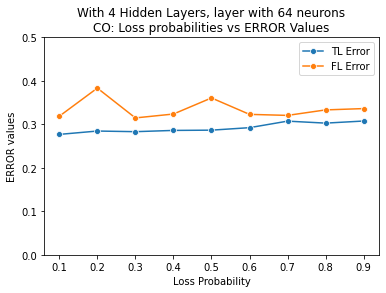

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 0.5))

plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 4 Hidden Layers, layer with 64 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)

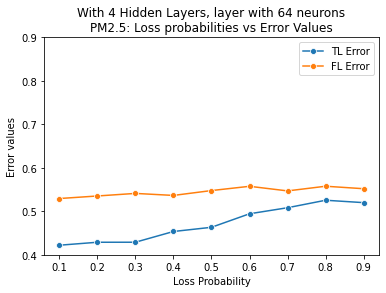

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.4, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 4 Hidden Layers, layer with 64 neurons\nPM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

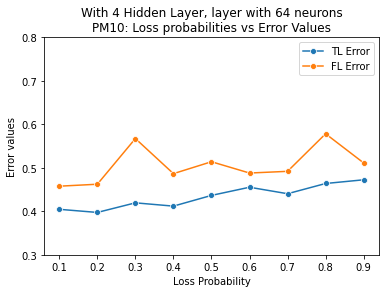

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.3, 0.8))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 4 Hidden Layer, layer with 64 neurons\nPM10: Loss probabilities vs Error Values") 
plt.show(ax)

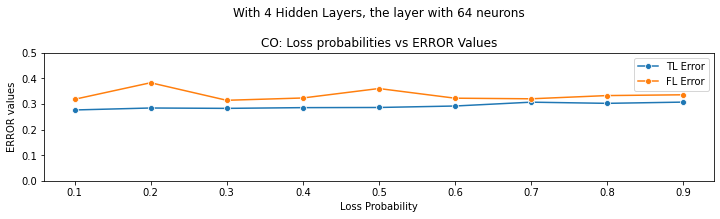

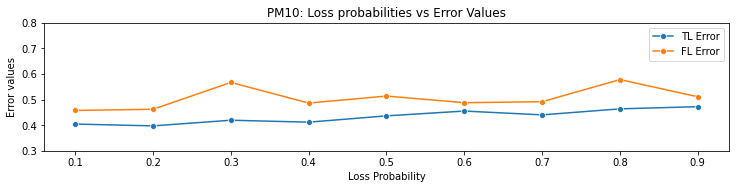

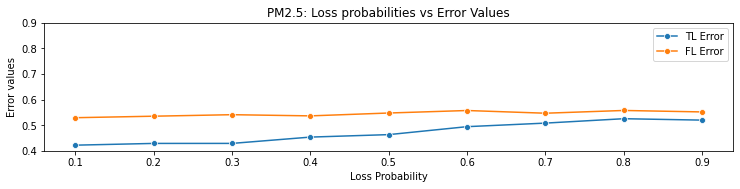

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(3,1,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 0.5))
# ax.set(xlim=(0.1, 0.9))
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 4 Hidden Layers, the layer with 64 neurons\n\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)


plt.figure(figsize=(27, 8))
plt.subplot(3,2,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.3, 0.8))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM10: Loss probabilities vs Error Values") 
plt.show(ax)


plt.figure(figsize=(42, 8))
plt.subplot(3,3,1)
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.4, 0.9))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


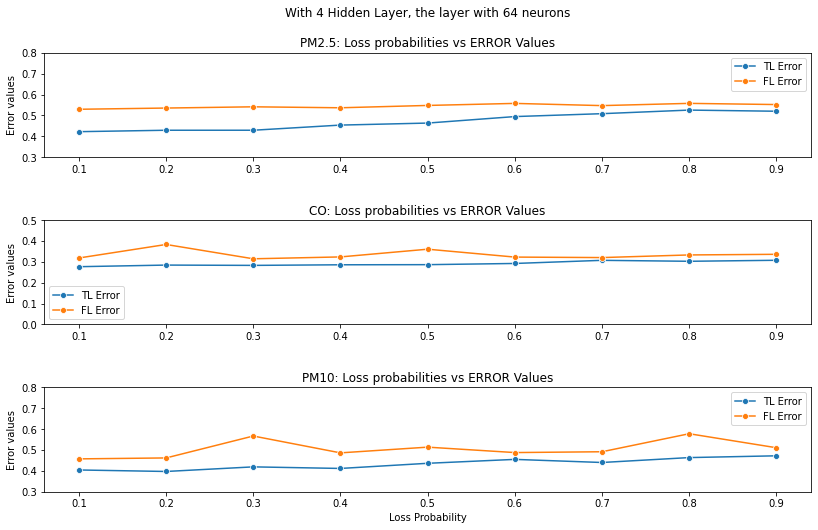

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(12,8))

idx = 0

y_arr = [(np.array(errors_tl_h4_64['PM2.5'])[:,1], np.array(errors_fl_h4_64['PM2.5'])[:,1]), (np.array(errors_tl_h4_64['CO'])[:,1], np.array(errors_fl_h4_64['CO'])[:,1]), 
         (np.array(errors_tl_h4_64['PM10'])[:,1], np.array(errors_fl_h4_64['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("With 4 Hidden Layer, the layer with 64 neurons\n\n{}: Loss probabilities vs ERROR Values".format(gas[row]))
        else:
          axes[row].set_title("{}: Loss probabilities vs ERROR Values".format(gas[row]))

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row])

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error', ax = axes[row])
        
        
        axes[row].set(ylabel='Error values')
        if row == 1:
          axes[row].set(ylim=(0.0, 0.5))
        else:
          axes[row].set(ylim=(0.3, 0.8))
        plt.legend()
        if row == 2:
          axes[row].set(xlabel='Loss Probability', ylabel='Error values')

        
        idx += 1

title = "With 4 Hidden Layer, the layer with 64 neurons"    
fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

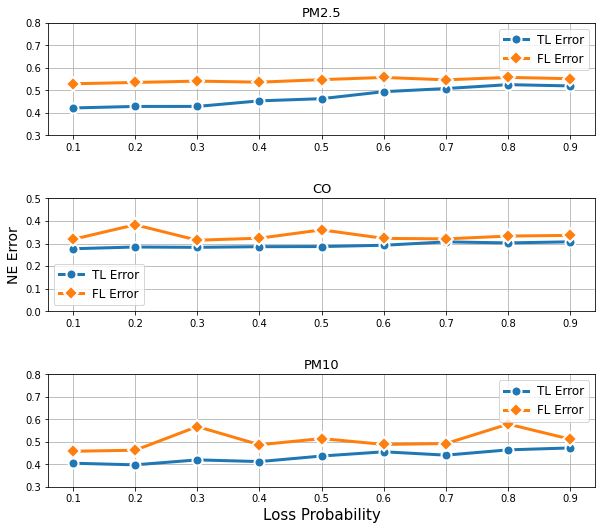

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(9,8))

idx = 0
y_arr = [(np.array(errors_tl_h4_64['PM2.5'])[:,1], np.array(errors_fl_h4_64['PM2.5'])[:,1]), (np.array(errors_tl_h4_64['CO'])[:,1], np.array(errors_fl_h4_64['CO'])[:,1]), 
         (np.array(errors_tl_h4_64['PM10'])[:,1], np.array(errors_fl_h4_64['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("{}".format(gas[row]), fontsize=13)
        else:
          axes[row].set_title("{}".format(gas[row]), fontsize=13)

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row], linewidth=3, ms='10', mew='2')

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="D", dashes=False, label = 'FL Error', ax = axes[row], linewidth=3, ms='10', mew='2')
        
        axes[row].legend(fontsize=12)
        axes[row].grid(True)
        
        if row == 1:
          axes[row].set(ylim=(0.0, 0.5))
          axes[row].set_ylabel('NE Error', fontsize=14)
        else:
          axes[row].set(ylim=(0.3, 0.8))

        if row == 2:
          pass
          # axes[row].set(xlabel='Loss Probability', fontsize=14)

        
        idx += 1
plt.xlabel("Loss Probability", fontsize=15)
# # plt.ylabel("NE Error Values", loc='center', fontsize=15)
# title = "With 1 Hidden Layer, the layer with 64 neurons"    
# fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

#### Customized plots: 1.0

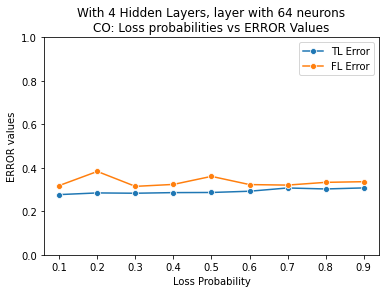

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))

plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 4 Hidden Layers, layer with 64 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)

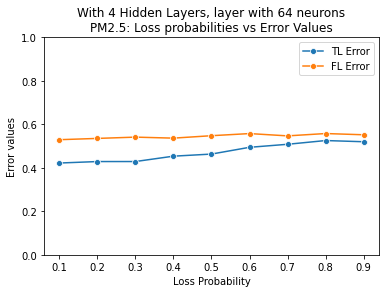

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 4 Hidden Layers, layer with 64 neurons\nPM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

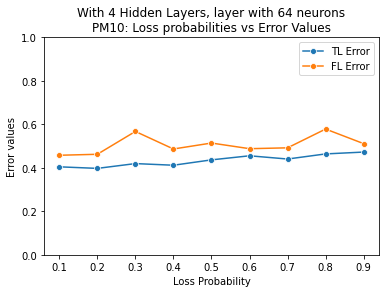

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("With 4 Hidden Layers, layer with 64 neurons\nPM10: Loss probabilities vs Error Values") 
plt.show(ax)

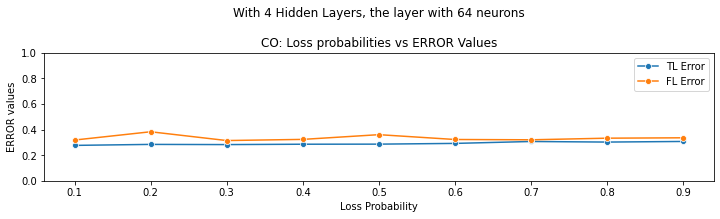

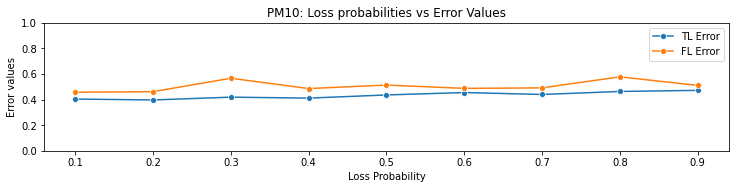

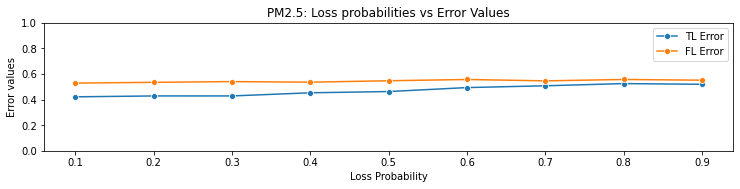

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(3,1,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlim=(0.1, 0.9))
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("ERROR values")
plt.title("With 4 Hidden Layers, the layer with 64 neurons\n\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)


plt.figure(figsize=(27, 8))
plt.subplot(3,2,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_64['PM10'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM10: Loss probabilities vs Error Values") 
plt.show(ax)


plt.figure(figsize=(42, 8))
plt.subplot(3,3,1)
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL Error')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_64['PM2.5'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error')

ax.set(ylim=(0.0, 1.0))
# ax.set(xlim=(0.1, 0.9))
# ax.set(xlabel='Loss Probability', ylabel='MSE values')
plt.legend()
plt.xlabel("Loss Probability")
plt.ylabel("Error values")
plt.title("PM2.5: Loss probabilities vs Error Values") 
plt.show(ax)

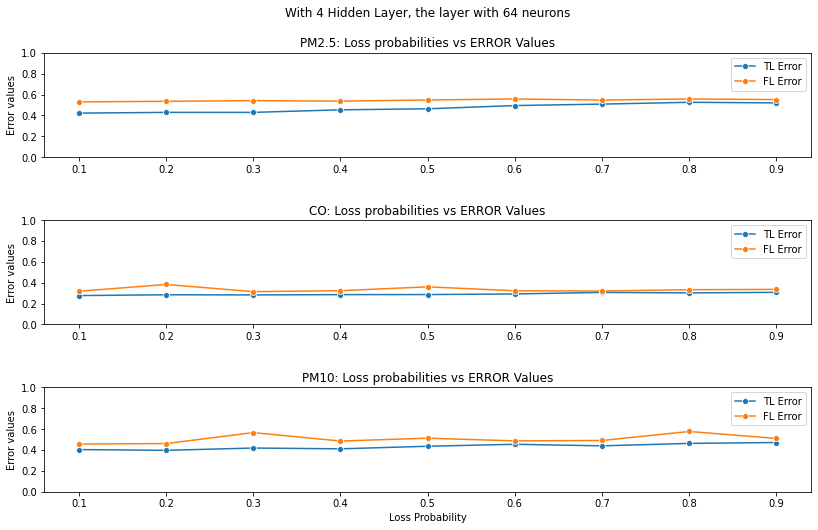

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(12,8))

idx = 0

y_arr = [(np.array(errors_tl_h4_64['PM2.5'])[:,1], np.array(errors_fl_h4_64['PM2.5'])[:,1]), (np.array(errors_tl_h4_64['CO'])[:,1], np.array(errors_fl_h4_64['CO'])[:,1]), 
         (np.array(errors_tl_h4_64['PM10'])[:,1], np.array(errors_fl_h4_64['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("With 4 Hidden Layer, the layer with 64 neurons\n\n{}: Loss probabilities vs ERROR Values".format(gas[row]))
        else:
          axes[row].set_title("{}: Loss probabilities vs ERROR Values".format(gas[row]))

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row])

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="o", dashes=False, label = 'FL Error', ax = axes[row])
        
        
        axes[row].set(ylabel='Error values')
        axes[row].set(ylim=(0.0, 1.0))

        if row == 2:
          axes[row].set(xlabel='Loss Probability', ylabel='Error values')

        
        idx += 1

title = "With 4 Hidden Layer, the layer with 64 neurons"    
fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

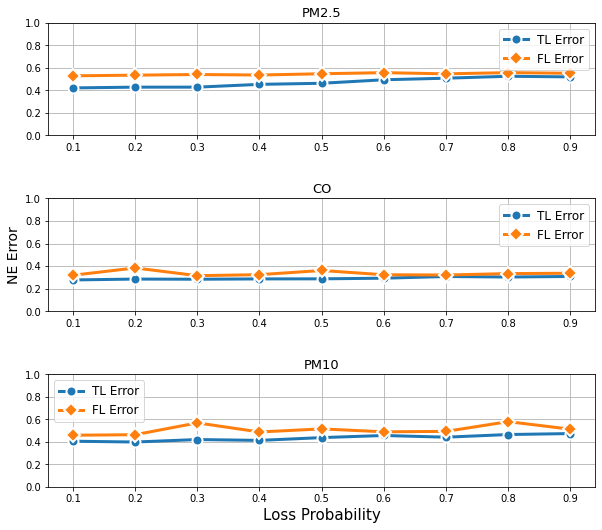

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(9,8))

idx = 0
y_arr = [(np.array(errors_tl_h4_64['PM2.5'])[:,1], np.array(errors_fl_h4_64['PM2.5'])[:,1]), (np.array(errors_tl_h4_64['CO'])[:,1], np.array(errors_fl_h4_64['CO'])[:,1]), 
         (np.array(errors_tl_h4_64['PM10'])[:,1], np.array(errors_fl_h4_64['PM10'])[:,1])]
gas = ['PM2.5', 'CO', 'PM10']
# plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

for row in range(3):
    for col in range(1):
        if row == 0:
          axes[row].set_title("{}".format(gas[row]), fontsize=13)
        else:
          axes[row].set_title("{}".format(gas[row]), fontsize=13)

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
                  marker="o", dashes=False, label = 'TL Error', ax = axes[row], linewidth=3, ms='10', mew='2')

        axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
                  marker="D", dashes=False, label = 'FL Error', ax = axes[row], linewidth=3, ms='10', mew='2')
        
        axes[row].legend(fontsize=12)
        axes[row].grid(True)
        
        if row == 1:
          axes[row].set(ylim=(0.0, 1.0))
          axes[row].set_ylabel('NE Error', fontsize=14)
        else:
          axes[row].set(ylim=(0.0, 1.0))

        if row == 2:
          pass
          # axes[row].set(xlabel='Loss Probability', fontsize=14)

        
        idx += 1
plt.xlabel("Loss Probability", fontsize=15)
# # plt.ylabel("NE Error Values", loc='center', fontsize=15)
# title = "With 1 Hidden Layer, the layer with 64 neurons"    
# fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
plt.tight_layout(pad=3);

## Improvement in Learning through architecture

### with number of hidden layers

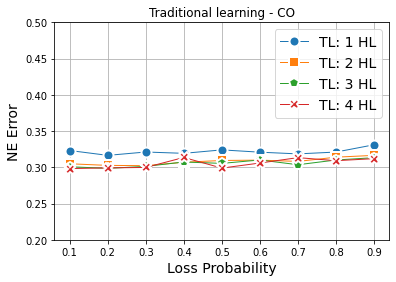

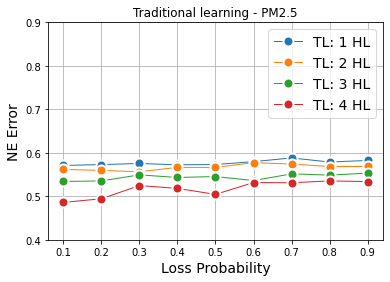

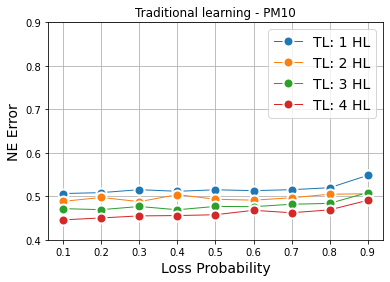

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
# plt.figure(figsize=(6,6))
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_32['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL: 1 HL', linewidth=1, ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_32['CO'])[:,1], markers=True, 
                  marker="s", dashes=False, label = 'TL: 2 HL', linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_32['CO'])[:,1], markers=True, 
                  marker="P", dashes=False, label = 'TL: 3 HL', linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_32['CO'])[:,1], markers=True, 
                  marker="X", dashes=False, label = 'TL: 4 HL', linewidth=1, ms='10', mew='2')

ax.set(ylim=(0.2, 0.5))
ax.grid(True)
plt.legend(fontsize=14)
plt.xlabel("Loss Probability", fontsize=14)
plt.ylabel("NE Error",fontsize=14)
# plt.title("Traditional learning errors using varying layers with 32 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.title("Traditional learning - CO")
plt.show(ax)

# traditional learning perfromed best with 4 hidden layer


import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_32['PM2.5'])[:,1], markers=True,
                  marker="o", dashes=False, label = 'TL: 1 HL',linewidth=1, ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_32['PM2.5'])[:,1], markers=True,
                  marker="o", dashes=False, label = 'TL: 2 HL',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_32['PM2.5'])[:,1], markers=True,
                  marker="o", dashes=False, label = 'TL: 3 HL',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_32['PM2.5'])[:,1], markers=True,
                  marker="o", dashes=False, label = 'TL: 4 HL',linewidth=1, ms='10', mew='2')

ax.set(ylim=(0.4, 0.9))
ax.grid(True)
plt.legend(fontsize=14)
plt.xlabel("Loss Probability", fontsize=14)
plt.ylabel("NE Error",fontsize=14)
# plt.title("Traditional learning errors using varying layers with 32 neurons\nPM2.5: Loss probabilities vs ERROR Values")
plt.title("Traditional learning - PM2.5")
plt.show(ax)


import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_32['PM10'])[:,1], markers=True,
                  marker="o", dashes=False, label = 'TL: 1 HL',linewidth=1, ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_32['PM10'])[:,1], markers=True,
                  marker="o", dashes=False, label = 'TL: 2 HL',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_32['PM10'])[:,1], markers=True,
                  marker="o", dashes=False, label = 'TL: 3 HL',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_32['PM10'])[:,1], markers=True,
                  marker="o", dashes=False, label = 'TL: 4 HL',linewidth=1, ms='10', mew='2')

ax.set(ylim=(0.4, 0.9))
ax.grid(True)
plt.legend(fontsize=14)
plt.xlabel("Loss Probability", fontsize=14)
plt.ylabel("NE Error",fontsize=14)
# plt.title("Traditional learning errors using varying layers with 32 neurons\nPM10: Loss probabilities vs ERROR Values")
plt.title("Traditional learning - PM10")
plt.show(ax)

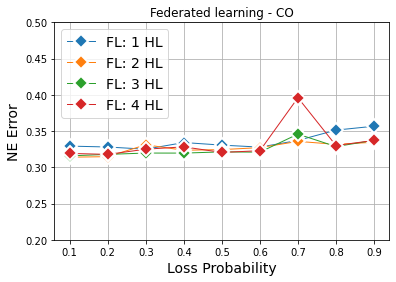

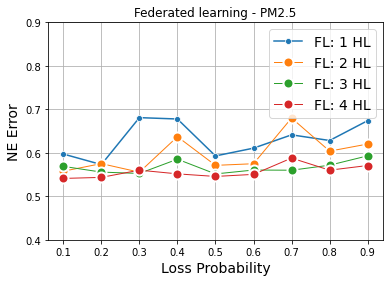

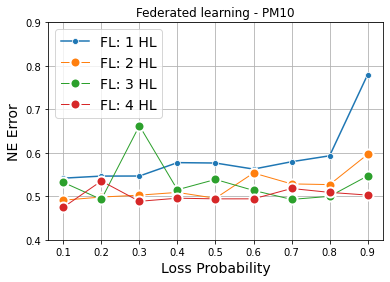

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_32['CO'])[:,1], markers=True, 
                  marker="D", dashes=False, label = 'FL: 1 HL',linewidth=1, ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_32['CO'])[:,1], markers=True, 
                  marker="D", dashes=False, label = 'FL: 2 HL',linewidth=1, ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_32['CO'])[:,1], markers=True, 
                  marker="D", dashes=False, label = 'FL: 3 HL',linewidth=1, ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_32['CO'])[:,1], markers=True, 
                  marker="D", dashes=False, label = 'FL: 4 HL',linewidth=1, ms='10', mew='2')
ax.set(ylim=(0.2, 0.5))
ax.grid(True)
plt.legend(fontsize=14)
plt.xlabel("Loss Probability", fontsize=14)
plt.ylabel("NE Error",fontsize=14)
# plt.title("Federated learning errors using varying layers with 32 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.title("Federated learning - CO")
plt.show(ax)

## FL performed best with 3 hidden layer 64 neurons

import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_32['PM2.5'])[:,1], markers=True,
                  marker="o", dashes=False, label = 'FL: 1 HL')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_32['PM2.5'])[:,1], markers=True,
                  marker="o", dashes=False, label = 'FL: 2 HL',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_32['PM2.5'])[:,1], markers=True,
                  marker="o", dashes=False, label = 'FL: 3 HL',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_32['PM2.5'])[:,1], markers=True,
                  marker="o", dashes=False, label = 'FL: 4 HL',linewidth=1, ms='10', mew='2')

ax.set(ylim=(0.4, 0.9))
ax.grid(True)
plt.legend(fontsize=14)
plt.xlabel("Loss Probability", fontsize=14)
plt.ylabel("NE Error",fontsize=14)
# plt.title("Federated learning errors using varying layers with 32 neurons\nPM2.5: Loss probabilities vs ERROR Values")
plt.title("Federated learning - PM2.5")
plt.show(ax)


import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_32['PM10'])[:,1], markers=True,
                  marker="o", dashes=False, label = 'FL: 1 HL')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_32['PM10'])[:,1], markers=True,
                  marker="o", dashes=False, label = 'FL: 2 HL',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_32['PM10'])[:,1], markers=True,
                  marker="o", dashes=False, label = 'FL: 3 HL',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_32['PM10'])[:,1], markers=True,
                  marker="o", dashes=False, label = 'FL: 4 HL',linewidth=1, ms='10', mew='2')

ax.set(ylim=(0.4, 0.9))
ax.grid(True)
plt.legend(fontsize=14)
plt.xlabel("Loss Probability", fontsize=14)
plt.ylabel("NE Error",fontsize=14)
# plt.title("Federated learning errors using varying layers with 32 neurons\nPM10: Loss probabilities vs ERROR Values")
plt.title("Federated learning - PM10")
plt.show(ax)


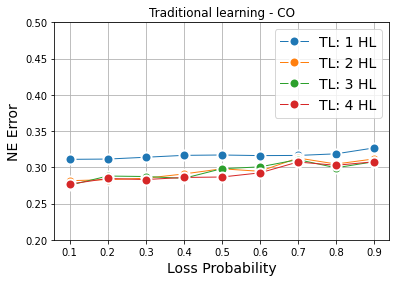

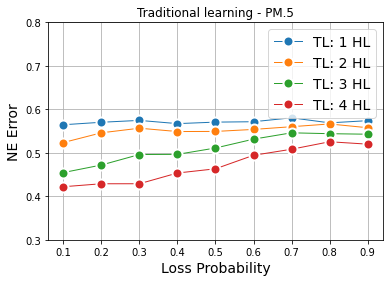

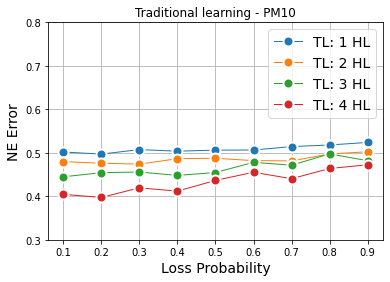

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL: 1 HL',linewidth=1, ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL: 2 HL',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL: 3 HL',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_64['CO'])[:,1], markers=True, 
                  marker="o", dashes=False, label = 'TL: 4 HL',linewidth=1, ms='10', mew='2')

ax.set(ylim=(0.2, 0.5))
ax.grid(True)
plt.legend(fontsize=14)
plt.xlabel("Loss Probability", fontsize=14)
plt.ylabel("NE Error",fontsize=14)
# plt.title("Traditional learning errors using varying layers with 64 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.title("Traditional learning - CO")
plt.show(ax)

# traditional learning perfromed best with 4 hidden layer

import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_64['PM2.5'])[:,1], markers=True,
                  marker="o", dashes=False, label = 'TL: 1 HL',linewidth=1, ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_64['PM2.5'])[:,1], markers=True,
                  marker="o", dashes=False, label = 'TL: 2 HL',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_64['PM2.5'])[:,1], markers=True,
                  marker="o", dashes=False, label = 'TL: 3 HL',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_64['PM2.5'])[:,1], markers=True,
                  marker="o", dashes=False, label = 'TL: 4 HL',linewidth=1, ms='10', mew='2')

ax.set(ylim=(0.3, 0.7))
ax.grid(True)
plt.legend(fontsize=12)
plt.xlabel("Loss Probability", fontsize=14)
plt.ylabel("NE Error",fontsize=14)
# plt.title("Traditional learning errors using varying layers with 64 neurons\nPM2.5: Loss probabilities vs ERROR Values")
plt.title("PM2.5",fontsize=14)
plt.show(ax)


import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_64['PM10'])[:,1], markers=True,
                  marker="o", dashes=False, label = 'TL: 1 HL',linewidth=1, ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_64['PM10'])[:,1], markers=True,
                  marker="o", dashes=False, label = 'TL: 2 HL',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_64['PM10'])[:,1], markers=True,
                  marker="o", dashes=False, label = 'TL: 3 HL',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_64['PM10'])[:,1], markers=True,
                  marker="o", dashes=False, label = 'TL: 4 HL',linewidth=1, ms='10', mew='2')

ax.set(ylim=(0.3, 0.8))
ax.grid(True)
plt.legend(fontsize=14)
plt.xlabel("Loss Probability", fontsize=14)
plt.ylabel("NE Error",fontsize=14)
# plt.title("Traditional learning errors using varying layers with 64 neurons\nPM10: Loss probabilities vs ERROR Values")
plt.title("Traditional learning - PM10")
plt.show(ax)

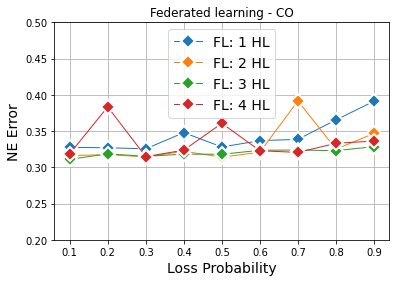

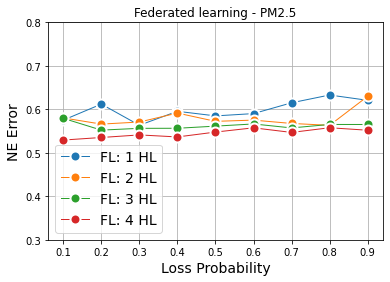

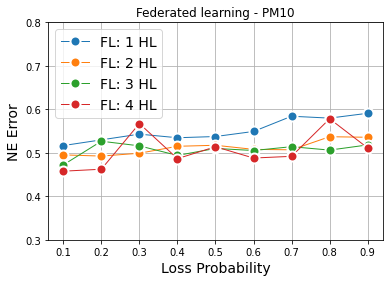

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_64['CO'])[:,1], markers=True, 
                  marker="D", dashes=False, label = 'FL: 1 HL',linewidth=1, ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_64['CO'])[:,1], markers=True, 
                  marker="D", dashes=False, label = 'FL: 2 HL',linewidth=1, ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_64['CO'])[:,1], markers=True, 
                  marker="D", dashes=False, label = 'FL: 3 HL',linewidth=1, ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_64['CO'])[:,1], markers=True, 
                  marker="D", dashes=False, label = 'FL: 4 HL',linewidth=1, ms='10', mew='2')
ax.set(ylim=(0.2, 0.5))
ax.grid(True)
plt.legend(fontsize=14)
plt.xlabel("Loss Probability", fontsize=14)
plt.ylabel("NE Error",fontsize=14)
# plt.title("Federated learning errors using varying layers with 64 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.title("Federated learning - CO")
plt.show(ax)

## FL performed best with 3 hidden layer 64 neurons

import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_64['PM2.5'])[:,1], markers=True,
                  marker="o", dashes=False, label = 'FL: 1 HL',linewidth=1, ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_64['PM2.5'])[:,1], markers=True,
                  marker="s", dashes=False, label = 'FL: 2 HL',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_64['PM2.5'])[:,1], markers=True,
                  marker="P", dashes=False, label = 'FL: 3 HL',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_64['PM2.5'])[:,1], markers=True,
                  marker="X", dashes=False, label = 'FL: 4 HL',linewidth=1, ms='10', mew='2')

ax.set(ylim=(0.4, 0.8))
ax.grid(True)
plt.legend(fontsize=12)
plt.xlabel("Loss Probability", fontsize=14)
plt.ylabel("NE Error",fontsize=14)
# plt.title("Federated learning errors using varying layers with 64 neurons\n'PM2.5': Loss probabilities vs ERROR Values")
plt.title("PM2.5", fontsize=14)
plt.show(ax)


import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_64['PM10'])[:,1], markers=True,
                  marker="o", dashes=False, label = 'FL: 1 HL',linewidth=1, ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_64['PM10'])[:,1], markers=True,
                  marker="o", dashes=False, label = 'FL: 2 HL',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_64['PM10'])[:,1], markers=True,
                  marker="o", dashes=False, label = 'FL: 3 HL',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_64['PM10'])[:,1], markers=True,
                  marker="o", dashes=False, label = 'FL: 4 HL',linewidth=1, ms='10', mew='2')

ax.set(ylim=(0.3, 0.8))
ax.grid(True)
plt.legend(fontsize=11)
plt.xlabel("Loss Probability", fontsize=14)
plt.ylabel("NE Error",fontsize=14)
# plt.title("Federated learning errors using varying layers with 64 neurons \n'PM10': Loss probabilities vs ERROR Values")
plt.title("Federated learning - PM10")
plt.show(ax)

### chosen for paper

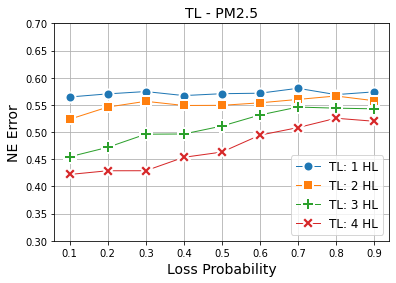

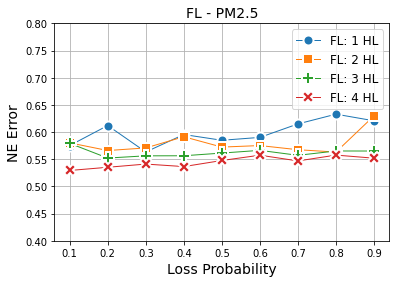

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_64['PM2.5'])[:,1], markers=True,
                  marker="o", dashes=False, label = 'TL: 1 HL',linewidth=1, ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_64['PM2.5'])[:,1], markers=True,
                  marker="s", dashes=False, label = 'TL: 2 HL',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_64['PM2.5'])[:,1], markers=True,
                  marker="P", dashes=False, label = 'TL: 3 HL',linewidth=1, ms='12', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_64['PM2.5'])[:,1], markers=True,
                  marker="X", dashes=False, label = 'TL: 4 HL',linewidth=1, ms='12', mew='2')

ax.set(ylim=(0.3, 0.7))
ax.grid(True)
plt.legend(fontsize=12)
plt.xlabel("Loss Probability", fontsize=14)
plt.ylabel("NE Error",fontsize=14)
# plt.title("Traditional learning errors using varying layers with 64 neurons\nPM2.5: Loss probabilities vs ERROR Values")
plt.title("TL - PM2.5",fontsize=14)
plt.show(ax)




import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_64['PM2.5'])[:,1], markers=True,
                  marker="o", dashes=False, label = 'FL: 1 HL',linewidth=1, ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_64['PM2.5'])[:,1], markers=True,
                  marker="s", dashes=False, label = 'FL: 2 HL',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_64['PM2.5'])[:,1], markers=True,
                  marker="P", dashes=False, label = 'FL: 3 HL',linewidth=1, ms='12', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_64['PM2.5'])[:,1], markers=True,
                  marker="X", dashes=False, label = 'FL: 4 HL',linewidth=1, ms='12', mew='2')

ax.set(ylim=(0.4, 0.8))
ax.grid(True)
plt.legend(fontsize=12)
plt.xlabel("Loss Probability", fontsize=14)
plt.ylabel("NE Error",fontsize=14)
# plt.title("Federated learning errors using varying layers with 64 neurons\n'PM2.5': Loss probabilities vs ERROR Values")
plt.title("FL - PM2.5", fontsize=14)
plt.show(ax)

In [ ]:
# fig, axes = plt.subplots(3,1, figsize=(12,8))

# idx = 0

# y_arr = [(np.array(errors_tl_h4_64['PM2.5'])[:,1], np.array(errors_fl_h4_64['PM2.5'])[:,1]), (np.array(errors_tl_h4_64['CO'])[:,1], np.array(errors_fl_h4_64['CO'])[:,1]), 
#          (np.array(errors_tl_h4_64['PM10'])[:,1], np.array(errors_fl_h4_64['PM10'])[:,1])]
# gas = ['PM2.5', 'CO', 'PM10']
# # plt.title("With 1 Hidden Layer, the layer with 32 neurons\n\nCO: Loss probabilities vs ERROR Values")

# for row in range(3):
#     for col in range(1):
#         if row == 0:
#           axes[row].set_title("With 4 Hidden Layer, the layer with 64 neurons\n\n{}: Loss probabilities vs ERROR Values".format(gas[row]))
#         else:
#           axes[row].set_title("{}: Loss probabilities vs ERROR Values".format(gas[row]))

#         axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][0], markers=True, 
#                   marker="o", dashes=False, label = 'TL Error', ax = axes[row])

#         axes[row] = sns.lineplot(x = loss_prob, y = y_arr[row][1], markers=True, 
#                   marker="o", dashes=False, label = 'FL Error', ax = axes[row])
        
        
#         axes[row].set(ylabel='Error values')
#         # if row == 1:
#         #   axes[row].set(ylim=(0.0, 0.5))
#         # else:
#         #   axes[row].set(ylim=(0.3, 0.8))
#         # plt.legend()
#         if row == 2:
#           axes[row].set(xlabel='Loss Probability', ylabel='Error values')

        
#         idx += 1

# title = "With 4 Hidden Layer, the layer with 64 neurons"    
# fig.savefig('/content/drive/MyDrive/Colab Notebooks/FL_vs_TL_Plots/{}.png'.format(title))
# plt.tight_layout(pad=3);

### with number of neurons in hidden layers

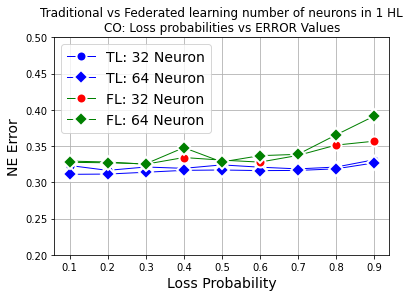

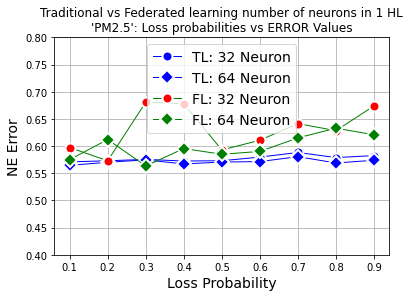

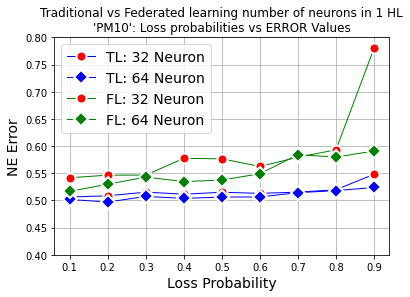

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# plt.figure(figsize=(12,8))
# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_32['CO'])[:,1], markers=True, 
                  marker="o", color='b', dashes=False, label = 'TL: 32 Neuron',linewidth=1, ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_64['CO'])[:,1], markers=True, 
                  marker="D", color='b', dashes=False, label = 'TL: 64 Neuron',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_32['CO'])[:,1], markers=True, 
                  marker="o", color='g', mfc='red', dashes=False, label = 'FL: 32 Neuron', linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_64['CO'])[:,1], markers=True, 
                  marker="D", color='g', dashes=False, label = 'FL: 64 Neuron',linewidth=1, ms='10', mew='2')

ax.set(ylim=(0.2, 0.5))
ax.grid(True)
plt.legend(fontsize=14)
plt.xlabel("Loss Probability", fontsize=14)
plt.ylabel("NE Error",fontsize=14)
plt.title("Traditional vs Federated learning number of neurons in 1 HL\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)

# traditional learning perfromed best with 4 hidden layer
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_32['PM2.5'])[:,1], markers=True,
                  marker="o", color='b', dashes=False, label = 'TL: 32 Neuron',linewidth=1, ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_64['PM2.5'])[:,1], markers=True,
                  marker="D", color='b', dashes=False, label = 'TL: 64 Neuron',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_32['PM2.5'])[:,1], markers=True,
                  marker="o", color='g', mfc='red', dashes=False, label = 'FL: 32 Neuron',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_64['PM2.5'])[:,1], markers=True,
                  marker="D", color='g', dashes=False, label = 'FL: 64 Neuron',linewidth=1, ms='10', mew='2')

ax.set(ylim=(0.4, 0.8))
ax.grid(True)
plt.legend(fontsize=14)
plt.xlabel("Loss Probability", fontsize=14)
plt.ylabel("NE Error",fontsize=14)
plt.title("Traditional vs Federated learning number of neurons in 1 HL\n'PM2.5': Loss probabilities vs ERROR Values")
plt.show(ax)


import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_32['PM10'])[:,1], markers=True,
                  marker="o", color='b', mfc='red',  dashes=False, label = 'TL: 32 Neuron',linewidth=1, ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_64['PM10'])[:,1], markers=True,
                  marker="D", color='b', dashes=False, label = 'TL: 64 Neuron',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_32['PM10'])[:,1], markers=True,
                  marker="o", color='g', mfc='red',  dashes=False, label = 'FL: 32 Neuron',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_64['PM10'])[:,1], markers=True,
                  marker="D", color='g', dashes=False, label = 'FL: 64 Neuron',linewidth=1, ms='10', mew='2')

ax.set(ylim=(0.4, 0.8))
ax.grid(True)
plt.legend(fontsize=14)
plt.xlabel("Loss Probability", fontsize=14)
plt.ylabel("NE Error",fontsize=14)
plt.title("Traditional vs Federated learning number of neurons in 1 HL\n'PM10': Loss probabilities vs ERROR Values")
plt.show(ax)

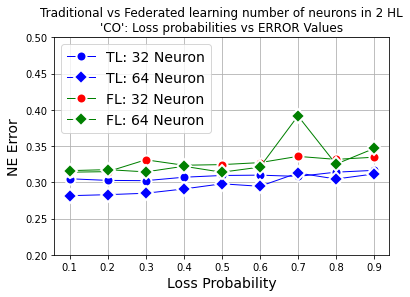

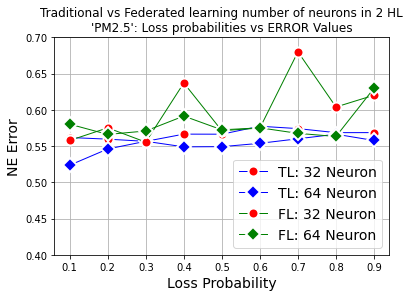

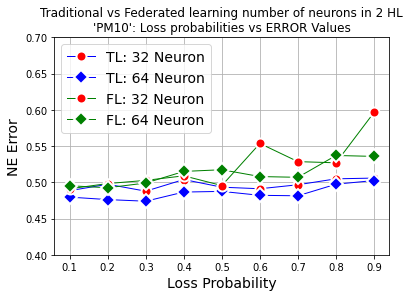

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_32['CO'])[:,1], markers=True,
                  marker="o", color='b', dashes=False, label = 'TL: 32 Neuron',linewidth=1, ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_64['CO'])[:,1], markers=True,
                  marker="D", color='b', dashes=False, label = 'TL: 64 Neuron',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_32['CO'])[:,1], markers=True,
                  marker="o", color='g', mfc='red',  dashes=False, label = 'FL: 32 Neuron',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_64['CO'])[:,1], markers=True,
                  marker="D", color='g', dashes=False, label = 'FL: 64 Neuron',linewidth=1, ms='10', mew='2')

ax.set(ylim=(0.2, 0.5))
ax.grid(True)
plt.legend(fontsize=14)
plt.xlabel("Loss Probability", fontsize=14)
plt.ylabel("NE Error",fontsize=14)
plt.title("Traditional vs Federated learning number of neurons in 2 HL\n'CO': Loss probabilities vs ERROR Values")
plt.show(ax)




import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_32['PM2.5'])[:,1], markers=True,
                  marker="o", color='b', mfc='red',  dashes=False, label = 'TL: 32 Neuron',linewidth=1, ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_64['PM2.5'])[:,1], markers=True,
                  marker="D", color='b', dashes=False, label = 'TL: 64 Neuron',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_32['PM2.5'])[:,1], markers=True,
                  marker="o", color='g', mfc='red', dashes=False, label = 'FL: 32 Neuron',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_64['PM2.5'])[:,1], markers=True,
                  marker="D", color='g', dashes=False, label = 'FL: 64 Neuron',linewidth=1, ms='10', mew='2')

ax.set(ylim=(0.4, 0.7))
ax.grid(True)
plt.legend(fontsize=14)
plt.xlabel("Loss Probability", fontsize=14)
plt.ylabel("NE Error",fontsize=14)
plt.title("Traditional vs Federated learning number of neurons in 2 HL\n'PM2.5': Loss probabilities vs ERROR Values")
plt.show(ax)



import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_32['PM10'])[:,1], markers=True,
                  marker="o", color='b', mfc='red', dashes=False, label = 'TL: 32 Neuron',linewidth=1, ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h2_64['PM10'])[:,1], markers=True,
                  marker="D", color='b', dashes=False, label = 'TL: 64 Neuron',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_32['PM10'])[:,1], markers=True,
                  marker="o", color='g', mfc='red',  dashes=False, label = 'FL: 32 Neuron',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h2_64['PM10'])[:,1], markers=True,
                  marker="D", color='g', dashes=False, label = 'FL: 64 Neuron',linewidth=1, ms='10', mew='2')

ax.set(ylim=(0.4, 0.7))
ax.grid(True)
plt.legend(fontsize=14)
plt.xlabel("Loss Probability", fontsize=14)
plt.ylabel("NE Error",fontsize=14)
plt.title("Traditional vs Federated learning number of neurons in 2 HL\n'PM10': Loss probabilities vs ERROR Values")
plt.show(ax)

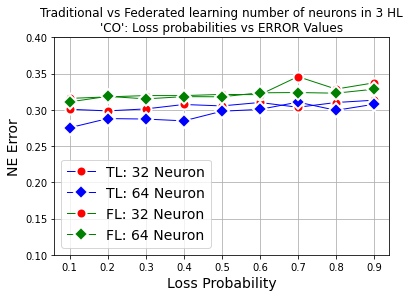

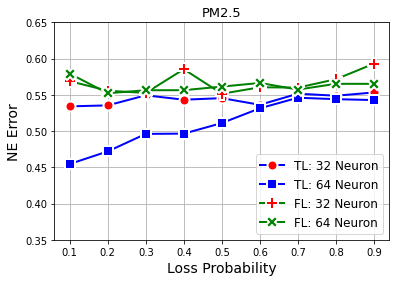

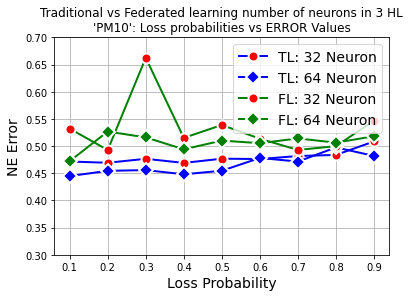

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_32['CO'])[:,1], markers=True,
                  marker="o", color='b', mfc='red',  dashes=False, label = 'TL: 32 Neuron',linewidth=1, ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_64['CO'])[:,1], markers=True,
                  marker="D", color='b', dashes=False, label = 'TL: 64 Neuron',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_32['CO'])[:,1], markers=True,
                  marker="o", color='g', mfc='red',  dashes=False, label = 'FL: 32 Neuron',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_64['CO'])[:,1], markers=True,
                  marker="D", color='g', dashes=False, label = 'FL: 64 Neuron',linewidth=1, ms='10', mew='2')

ax.set(ylim=(0.1, 0.4))
ax.grid(True)
plt.legend(fontsize=14)
plt.xlabel("Loss Probability", fontsize=14)
plt.ylabel("NE Error",fontsize=14)
plt.title("Traditional vs Federated learning number of neurons in 3 HL\n'CO': Loss probabilities vs ERROR Values")
plt.show(ax)


import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_32['PM2.5'])[:,1], markers=True,
                  marker="o", color='b', mfc='red', dashes=False, label = 'TL: 32 Neuron',linewidth=2, ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_64['PM2.5'])[:,1], markers=True,
                  marker="s", color='b', dashes=False, label = 'TL: 64 Neuron',linewidth=2, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_32['PM2.5'])[:,1], markers=True,
                  marker="P", color='g', mfc='red',  dashes=False, label = 'FL: 32 Neuron',linewidth=2, ms='12', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_64['PM2.5'])[:,1], markers=True,
                  marker="X", color='g', dashes=False, label = 'FL: 64 Neuron',linewidth=2, ms='12', mew='2')

ax.set(ylim=(0.35, 0.65))
ax.grid(True)
plt.legend(fontsize=12)
plt.xlabel("Loss Probability", fontsize=14)
plt.ylabel("NE Error",fontsize=14)
plt.title("PM2.5", fontsize=13)
plt.show(ax)


import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_32['PM10'])[:,1], markers=True,
                  marker="o", color='b', mfc='red',  dashes=False, label = 'TL: 32 Neuron',linewidth=2, ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h3_64['PM10'])[:,1], markers=True,
                  marker="D", color='b', dashes=False, label = 'TL: 64 Neuron',linewidth=2, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_32['PM10'])[:,1], markers=True,
                  marker="o", color='g', mfc='red', dashes=False, label = 'FL: 32 Neuron',linewidth=2, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h3_64['PM10'])[:,1], markers=True,
                  marker="D", color='g', dashes=False, label = 'FL: 64 Neuron',linewidth=2, ms='10', mew='2')

ax.set(ylim=(0.3, 0.7))
ax.grid(True)
plt.legend(fontsize=14)
plt.xlabel("Loss Probability", fontsize=14)
plt.ylabel("NE Error",fontsize=14)
plt.title("Traditional vs Federated learning number of neurons in 3 HL\n'PM10': Loss probabilities vs ERROR Values")
plt.show(ax)

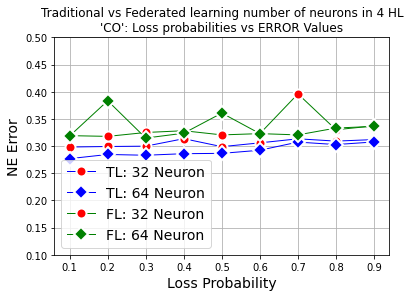

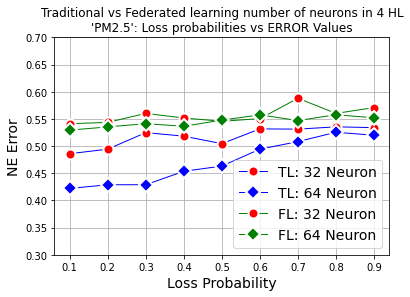

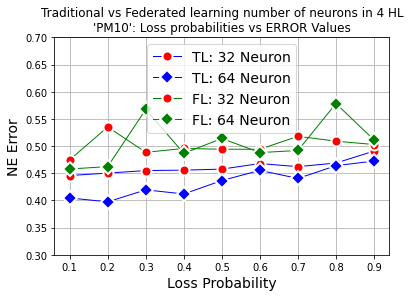

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_32['CO'])[:,1], markers=True,
                  marker="o", color='b', mfc='red', dashes=False, label = 'TL: 32 Neuron',linewidth=1, ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_64['CO'])[:,1], markers=True,
                  marker="D", color='b', dashes=False, label = 'TL: 64 Neuron',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_32['CO'])[:,1], markers=True,
                  marker="o", color='g', mfc='red',  dashes=False, label = 'FL: 32 Neuron',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_64['CO'])[:,1], markers=True,
                  marker="D", color='g', dashes=False, label = 'FL: 64 Neuron',linewidth=1, ms='10', mew='2')

ax.set(ylim=(0.1, 0.5))
ax.grid(True)
plt.legend(fontsize=14)
plt.xlabel("Loss Probability", fontsize=14)
plt.ylabel("NE Error",fontsize=14)
plt.title("Traditional vs Federated learning number of neurons in 4 HL\n'CO': Loss probabilities vs ERROR Values")
plt.show(ax)


import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_32['PM2.5'])[:,1], markers=True,
                  marker="o", color='b', mfc='red',  dashes=False, label = 'TL: 32 Neuron',linewidth=1, ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_64['PM2.5'])[:,1], markers=True,
                  marker="D", color='b', dashes=False, label = 'TL: 64 Neuron',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_32['PM2.5'])[:,1], markers=True,
                  marker="o", color='g', mfc='red',  dashes=False, label = 'FL: 32 Neuron',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_64['PM2.5'])[:,1], markers=True,
                  marker="D", color='g', dashes=False, label = 'FL: 64 Neuron',linewidth=1, ms='10', mew='2')

ax.set(ylim=(0.3, 0.7))
ax.grid(True)
plt.legend(fontsize=14)
plt.xlabel("Loss Probability", fontsize=14)
plt.ylabel("NE Error",fontsize=14)
plt.title("Traditional vs Federated learning number of neurons in 4 HL\n'PM2.5': Loss probabilities vs ERROR Values")
plt.show(ax)


import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_32['PM10'])[:,1], markers=True,
                  marker="o", color='b', mfc='red',  dashes=False, label = 'TL: 32 Neuron',linewidth=1, ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h4_64['PM10'])[:,1], markers=True,
                  marker="D", color='b', dashes=False, label = 'TL: 64 Neuron',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_32['PM10'])[:,1], markers=True,
                  marker="o", color='g', mfc='red', dashes=False, label = 'FL: 32 Neuron',linewidth=1, ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h4_64['PM10'])[:,1], markers=True,
                  marker="D", color='g', dashes=False, label = 'FL: 64 Neuron',linewidth=1, ms='10', mew='2')

ax.set(ylim=(0.3, 0.7))
ax.grid(True)
plt.legend(fontsize=14)
plt.xlabel("Loss Probability", fontsize=14)
plt.ylabel("NE Error",fontsize=14)
plt.title("Traditional vs Federated learning number of neurons in 4 HL\n'PM10': Loss probabilities vs ERROR Values")
# plt.title("PM10:")
plt.show(ax)

### Playing with t value in FL

#### Federated Learning

In [ ]:
# ClientUpdate(k, w): // Run on client k
def Client_L1_32_t(client_idx, model, gas):
    # B ← (split P_k into batches of size B) # what is p_K --> each clients' sample size
    B = 1000 #int(len(clients[client_idx]) * 0.01) # so for each client the batch size would be different depending upon the total sample size
    E = 25 #max(30, B//10) # number of local epochs; it will also depend on sample size (indirectly)

    data = clients_cut[client_idx]
    # data = dataset.loc[dataset['Station code'] == client_idx]

    X, y = data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  data[gas]

    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state=1)

    try:
        model.fit(x_train, y_train, 
                    epochs = E, 
                    batch_size=B,
                    validation_data=(x_val, y_val),
                    verbose=False)
    except Exception as e:
        print(e)
        print("error")

    # return w to server
    # in our case no need for any explicit return; as the model is pass by value
    return data.shape[0] # this will return the number of total sample


In [ ]:
# Server executes: 
def Server_L1_32_t(gas, T):
    # initialize w_0
    model = Sequential()
    
    # model.add(Dense(64, kernel_initializer='zeros', bias_initializer='zeros', activation=tf.nn.relu, input_dim=6)) # first dense/hidden layer
    model.add(Dense(32, kernel_initializer='he_uniform', bias_initializer="zeros", activation=tf.nn.relu, input_dim=8))
    model.add(Dropout(0.1))

    model.add(Dense(1, kernel_initializer= 'he_uniform', activation='linear')) # output layer


    # compile the model
    model.compile(loss='mse', 
                optimizer='adam', 
                metrics=['mse'])
    

# for each round t = 1, 2, . . . do
    for t in range(1, T):
        C = np.random.random(1)[0] # random number between 0 and 1.

        # m ← max(C  K, 1)
        m = max(int(C*K), 1) # m == random number of client selected
        weight_t_plus_1 = [None] * m # matrix to store the weights of all client in each t-round
        n_k = [None] * m # parameters for weighted sum 


        # S_t ← (random set of m clients)
        # S = {} # dictionary
        S_t = np.random.uniform(low=101, high=126, size=(m)).astype(int)

        # No need for below loop, as server don't need access to client data, server only need clients' number
        # for client in m_clients:
        #   S[client] = clients[client]

        initial_weights = model.get_weights() # setting initial weights; should be same for all clients
        # for t= 1 to T, initial_weights would be t-1th's final weights

        # for each client k ∈ S_t in parallel do
        client_idx = 0
        for client in S_t:
            # w^(k)_(t+1) ← ClientUpdate(k, model)
            n_k[client_idx] = Client_L1_32_t(client, model, gas) # pass by reference for model
            weight_t_plus_1[client_idx] = model.get_weights()
            client_idx += 1

            # setting weights back to initial weights
            model.set_weights(initial_weights)

        # finding the weighted sum
        final_weights_t = np.array(weight_t_plus_1[0]) * (n_k[0] / sum(n_k))

        for idx in range(1, m):
          # w_(t+1) ← summation(k=1 to K){(n_k/n) * w^(k)_(t+1)} #n_k - no. of training sample in each client K; n - total training samples;
          final_weights_t += np.array(weight_t_plus_1[idx]) * (n_k[idx]/ sum(n_k))

        # setting the aggregated weights
        model.set_weights(final_weights_t)


#         print(model.get_weights())
    # return error_clients(model, loss_p)) # THIS LINE WON'T BE THERE IN REAL SERVER
    return model

In [ ]:
def error_clients_L1_32_t(model_name, gas, test_data):

    ## loading the json and creating model
    json_file = open(model_name + ".json", 'r')
    model_json = json_file.read()
    json_file.close()

    model = model_from_json(model_json)
    model.load_weights(model_name + ".h5")

    ## need to compile the model again after loading
    # compile the model
    model.compile(loss='mse', 
                optimizer='adam', 
                metrics=['mse'])
  
    
    X, y = test_data[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  test_data[gas]
    
    # adjusting the dimensions
    x_test, y_test = X.to_numpy(), y.to_numpy()
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1])
    y_test = y_test.reshape(y_test.shape[0],1)

    y_predicted = model.predict(x_test)
    
    from sklearn.metrics import mean_squared_error
    # print("y_predicted", y_predicted)
    # print("y_predicted.ravel()", y_predicted.ravel())
    NE = np.sum(abs(np.array(y_test) - np.array(y_predicted))) / np.sum(np.array(y_test))

    # mse = mean_squared_error(y_predicted.ravel(), y_test.ravel())
    
    return NE

          

In [ ]:

# create an Empty DataFrame object
train_data = pd.DataFrame()
test_data = pd.DataFrame()
loss_prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
T_round = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
models = []
errors_fl_h1_32_t = {'CO':[]} #, 	'PM10':[],	'PM2.5':[]}
gases = ['CO'] #, 	'PM10',	'PM2.5']
model_name = "FL_model_1L_32_"


# reading all the clients and building model
for gas in gases:
  for lp in loss_prob:
      for st_code in range(101,126):
          # splitting into train test split
          X, y = clients[st_code][['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  clients[st_code][gas]
          x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = lp, random_state=1)

          # Normalization using min-max scaler
          # Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set.
          # to avoid data leak
          scaler_cols = x_train.columns
          scaler_idx_train = x_train.index
          scaler_idx_test = x_test.index

          # from sklearn.preprocessing import MinMaxScaler
          scaler = MinMaxScaler()

          # transforming train data
          x_train_encoded_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns = scaler_cols, index=scaler_idx_train)
          # display(x_train_encoded_scaled.head())

          # transforming test data
          x_test_encoded_scaled = pd.DataFrame(scaler.transform(x_test), columns = scaler_cols, index = scaler_idx_test)
          # display(x_test_encoded_scaled.head())

          # training data prep
          clients_cut[st_code] = pd.concat([x_train_encoded_scaled, y_train], axis = 1)

          # testing data prep
          # first appending x_test and y_test column wise
          # then appending each clients' dataframe one below other
          if st_code == 101:
            test_data = pd.concat([x_test_encoded_scaled, y_test], axis = 1)
          else:
            xy = pd.concat([x_test_encoded_scaled, y_test], axis=1)
            test_data = pd.concat([test_data, xy], axis=0)
          # x_test, y_test = x_test.to_numpy(), y_test.to_numpy()

      error = [] # empty array for each loss prob
      
      for T in T_round:
        # Training the model using federated learning
        # model = Server_L1_32(gas,T)

        ## Saving model
        ## serializing model to JSON
        model_address = "/content/drive/MyDrive/Colab Notebooks/Models/" + model_name + gas + str(lp) + "_" + str(T) + "_"


        # model_json = model.to_json()
        # with open(model_address + ".json", "w") as json_file:
        #   json_file.write(model_json)

        # serialize weights to HDF5
        # model.save_weights(model_address + ".h5")


        ## Testing model
        error.append(error_clients_L1_32_t(model_address, gas, test_data))

      # append the errors for each loss prob
      errors_fl_h1_32_t[gas].append(error)


#### Plots

##### Original plots

In [ ]:
import numpy as np

arr = np.array([
[2,3,4,5,6,7,8,9,10,11,12,13,14,15],
[2,3,4,5,6,7,8,9,10,11,12,13,14,15],
[2,3,4,5,6,7,8,9,10,11,12,13,14,15],
[2,3,4,5,6,7,8,9,10,11,12,13,14,15]])
print(arr)
print(arr.T[0])

[[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15]]
[2 2 2 2]


In [ ]:
print(errors_fl_h1_32_t['CO']) # 0 to 8 corresponding to 0.1 to 0.9
# [2,3,4,5,6,7,8,9,10,11,12,13,14,15],
# [2,3,4,5,6,7,8,9,10,11,12,13,14,15],
# [2,3,4,5,6,7,8,9,10,11,12,13,14,15],
# .
# .
# [2,3,4,5,6,7,8,9,10,11,12,13,14,15] .. 10



# target
error_fl_CO = np.array(errors_fl_h1_32_t['CO']).T
# error_fl_PM25 = np.array(errors_fl_h1_32['PM2.5']).T
# error_fl_PM10 = np.array(errors_fl_h1_32['PM10']).T
print(error_fl_CO)

# [[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
# [[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
# .
# .
# [[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] .. 14

[[0.3378599825805008, 0.34381799694850634, 0.37080977020183503, 0.32724854647612, 0.3245215323901957, 0.3235293255574283, 0.3230496718291287, 0.32049613405318605, 0.3188687467560569, 0.31702604146615826, 0.33882675956592484, 0.3205868918397361, 0.31859978992018306, 0.3179523385302634], [0.3470000577318641, 0.35957054233925695, 0.32796654703298994, 0.3281512072870911, 0.3414570575150356, 0.32477181048396314, 0.3391803821371679, 0.32148215111505446, 0.32870293660844796, 0.3158092915419987, 0.31788894817384905, 0.40533227659611043, 0.32920056476592463, 0.3257370450082776], [0.34386702681474923, 0.3339787689791694, 0.3338729238163694, 0.32434886073218705, 0.3377749076451995, 0.3222621755696691, 0.3397323087135478, 0.3723098954032116, 0.31834437953197375, 0.32318307217281594, 0.3172846961939024, 0.3170917918347214, 0.319714251476676, 0.31590795418355483], [0.34596807661289586, 0.3683792565381121, 0.326702511866939, 0.33480573140544795, 0.3280084308308584, 0.33049210092090325, 0.320531966647

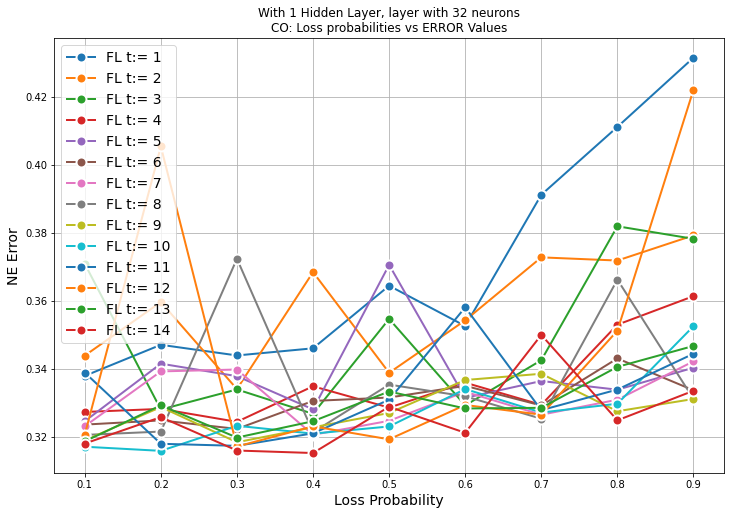

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
plt.figure(figsize=(12, 8))
ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_CO)[0], markers=True,
                  marker="o", dashes=False, label = 'FL t:= 1', linewidth=2,ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_CO)[1], markers=True,
                  marker="o", dashes=False, label = 'FL t:= 2', linewidth=2,ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_CO)[2], markers=True,
                  marker="o", dashes=False, label = 'FL t:= 3', linewidth=2,ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_CO)[3], markers=True,
                  marker="o", dashes=False, label = 'FL t:= 4', linewidth=2,ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_CO)[4], markers=True,
                  marker="o", dashes=False, label = 'FL t:= 5', linewidth=2,ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_CO)[5], markers=True,
                  marker="o", dashes=False, label = 'FL t:= 6', linewidth=2,ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_CO)[6], markers=True,
                  marker="o", dashes=False, label = 'FL t:= 7', linewidth=2,ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_CO)[7], markers=True,
                  marker="o", dashes=False, label = 'FL t:= 8', linewidth=2,ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_CO)[8], markers=True,
                  marker="o", dashes=False, label = 'FL t:= 9', linewidth=2,ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_CO)[9], markers=True,
                  marker="o", dashes=False, label = 'FL t:= 10', linewidth=2,ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_CO)[10], markers=True,
                  marker="o", dashes=False, label = 'FL t:= 11', linewidth=2,ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_CO)[11], markers=True,
                  marker="o", dashes=False, label = 'FL t:= 12', linewidth=2,ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_CO)[12], markers=True,
                  marker="o", dashes=False, label = 'FL t:= 13', linewidth=2,ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_CO)[13], markers=True,
                  marker="o", dashes=False, label = 'FL t:= 14', linewidth=2,ms='10', mew='2')
# ax.set(ylim=(0.2, 0.5))
ax.grid(True)
plt.legend(fontsize=14)
plt.xlabel("Loss Probability", fontsize=14)
plt.ylabel("NE Error",fontsize=14)
plt.title("With 1 Hidden Layer, layer with 32 neurons\nCO: Loss probabilities vs ERROR Values") 
plt.show(ax)

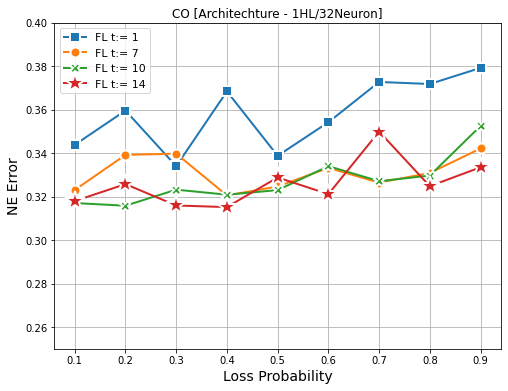

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)
plt.figure(figsize=(8, 6))

ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_CO)[1], markers=True,
                  marker="s", dashes=False, label = 'FL t:= 1', linewidth=2,ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_CO)[6], markers=True,
                  marker="o", dashes=False, label = 'FL t:= 7', linewidth=2,ms='10', mew='2')





# ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_CO)[8], markers=True,
#                   marker="P", dashes=False, label = 'FL t:= 9', linewidth=2,ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_CO)[9], markers=True,
                  marker="X", dashes=False, label = 'FL t:= 10', linewidth=2,ms='10', mew='2')


# ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_CO)[10], markers=True,
#                   marker="v", dashes=False, label = 'FL t:= 11', linewidth=2,ms='10', mew='2')



# ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_CO)[12], markers=True,
#                   marker="|", dashes=False, label = 'FL t:= 13', linewidth=2,ms='10', mew='2')


ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_CO)[13], markers=True,
                  marker="*", dashes=False, label = 'FL t:= 14', linewidth=2,ms='20', mew='2')




# ax.set(ylim=(0.2, 0.5))
ax.set(ylim=(0.25, 0.4))
ax.grid(True)
plt.legend(fontsize=11)
plt.xlabel("Loss Probability", fontsize=14)
plt.ylabel("NE Error",fontsize=14)
plt.title("CO [Architechture - 1HL/32Neuron]") 
plt.show(ax)

#### Testing TL vs FL with best FL t value

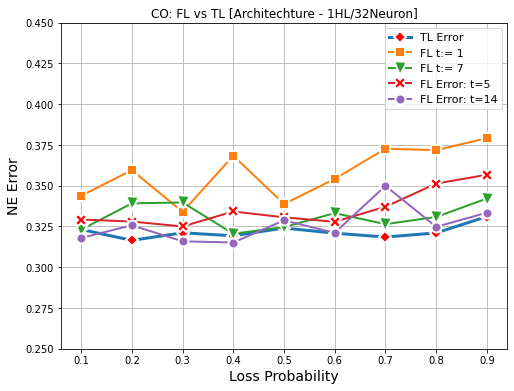

In [ ]:
plt.figure(figsize=(8, 6))

# plt.subplot(3,1,1)
ax = sns.lineplot(x = loss_prob, y = np.array(errors_tl_h1_32['CO'])[:,1], markers=True, 
                  marker="D", dashes=False, label = 'TL Error', linewidth=3, mfc='red', ms='8', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_CO)[1], markers=True,
                  marker="s", dashes=False, label = 'FL t:= 1', linewidth=2,ms='10', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_CO)[6], markers=True,
                  marker="v", dashes=False, label = 'FL t:= 7', linewidth=2,ms='13', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(errors_fl_h1_32['CO'])[:,1], markers=True, 
                  marker="X", dashes=False, label = 'FL Error: t=5', linewidth=2, mfc='red', ms='12', mew='2')

ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_CO)[13], markers=True,
                  marker="o", dashes=False, label = 'FL Error: t=14', linewidth=2, ms='10', mew='2')

ax.set(ylim=(0.25, 0.45))
# ax.set(xlim=(0.1, 0.9))
ax.grid(True)
plt.legend(fontsize=11)
plt.xlabel("Loss Probability", fontsize=14)
plt.ylabel("NE Error",fontsize=14)
plt.title("CO: FL vs TL [Architechture - 1HL/32Neuron]") 
plt.show(ax)



In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt


# ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_PM25)[0], markers=True,
#                   marker="o", dashes=False, label = 'FL t:= 1')


# ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_PM25)[1], markers=True,
#                   marker="o", dashes=False, label = 'FL t:= 2')


# ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_PM25)[2], markers=True,
#                   marker="o", dashes=False, label = 'FL t:= 3')


# ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_PM25)[3], markers=True,
#                   marker="o", dashes=False, label = 'FL t:= 4')


# ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_PM25)[4], markers=True,
#                   marker="o", dashes=False, label = 'FL t:= 5')


# ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_PM25)[5], markers=True,
#                   marker="o", dashes=False, label = 'FL t:= 6')


# ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_PM25)[6], markers=True,
#                   marker="o", dashes=False, label = 'FL t:= 7')


# ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_PM25)[7], markers=True,
#                   marker="o", dashes=False, label = 'FL t:= 8')


# ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_PM25)[8], markers=True,
#                   marker="o", dashes=False, label = 'FL t:= 9')


# ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_PM25)[9], markers=True,
#                   marker="o", dashes=False, label = 'FL t:= 10')


# ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_PM25)[10], markers=True,
#                   marker="o", dashes=False, label = 'FL t:= 11')


# ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_PM25)[11], markers=True,
#                   marker="o", dashes=False, label = 'FL t:= 12')


# ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_PM25)[12], markers=True,
#                   marker="o", dashes=False, label = 'FL t:= 13')


# ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_PM25)[13], markers=True,
#                   marker="o", dashes=False, label = 'FL t:= 14')




# # ax.set(ylim=(0.2, 0.5))

# plt.legend()
# plt.xlabel("Loss Probability")
# plt.ylabel("ERROR values")
# plt.title("With 1 Hidden Layer, layer with 32 neurons\nPM2.5: Loss probabilities vs ERROR Values")
# plt.show(ax)

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt


# ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_PM10)[0], markers=True,
#                   marker="o", dashes=False, label = 'FL t:= 1')


# ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_PM10)[1], markers=True,
#                   marker="o", dashes=False, label = 'FL t:= 2')


# ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_PM10)[2], markers=True,
#                   marker="o", dashes=False, label = 'FL t:= 3')


# ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_PM10)[3], markers=True,
#                   marker="o", dashes=False, label = 'FL t:= 4')


# ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_PM10)[4], markers=True,
#                   marker="o", dashes=False, label = 'FL t:= 5')


# ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_PM10)[5], markers=True,
#                   marker="o", dashes=False, label = 'FL t:= 6')


# ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_PM10)[6], markers=True,
#                   marker="o", dashes=False, label = 'FL t:= 7')


# ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_PM10)[7], markers=True,
#                   marker="o", dashes=False, label = 'FL t:= 8')


# ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_PM10)[8], markers=True,
#                   marker="o", dashes=False, label = 'FL t:= 9')


# ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_PM10)[9], markers=True,
#                   marker="o", dashes=False, label = 'FL t:= 10')


# ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_PM10)[10], markers=True,
#                   marker="o", dashes=False, label = 'FL t:= 11')


# ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_PM10)[11], markers=True,
#                   marker="o", dashes=False, label = 'FL t:= 12')


# ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_PM10)[12], markers=True,
#                   marker="o", dashes=False, label = 'FL t:= 13')


# ax = sns.lineplot(x = loss_prob, y = np.array(error_fl_PM10)[13], markers=True,
#                   marker="o", dashes=False, label = 'FL t:= 14')




# # ax.set(ylim=(0.2, 0.5))

# plt.legend()
# plt.xlabel("Loss Probability")
# plt.ylabel("ERROR values")
# plt.title("With 1 Hidden Layer, layer with 32 neurons\n PM10: Loss probabilities vs ERROR Values")
# plt.show(ax)

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # sns.lineplot(x = loss_prob, y = errors_tl, markers=True, dashes=False)

# ax = sns.lineplot(x = T_round, y = np.array(errors_fl_h1_32_t['CO'])[0], markers=True,
#                   marker="o", dashes=False, label = 'Loss P:= 0.1')

# ax = sns.lineplot(x = T_round, y = np.array(errors_fl_h1_32_t['CO'])[1], markers=True,
#                   marker="o", dashes=False, label = 'Loss P:= 0.2')


# ax = sns.lineplot(x = T_round, y = np.array(errors_fl_h1_32_t['CO'])[2], markers=True,
#                   marker="o", dashes=False, label = 'Loss P:= 0.3')


# ax = sns.lineplot(x = T_round, y = np.array(errors_fl_h1_32_t['CO'])[3], markers=True,
#                   marker="o", dashes=False, label = 'Loss P:= 0.4')


# ax = sns.lineplot(x = T_round, y = np.array(errors_fl_h1_32_t['CO'])[4], markers=True,
#                   marker="o", dashes=False, label = 'Loss P:= 0.5')


# ax = sns.lineplot(x = T_round, y = np.array(errors_fl_h1_32_t['CO'])[5], markers=True,
#                   marker="o", dashes=False, label = 'Loss P:= 0.6')


# ax = sns.lineplot(x = T_round, y = np.array(errors_fl_h1_32_t['CO'])[6], markers=True,
#                   marker="o", dashes=False, label = 'Loss P:= 0.7')


# ax = sns.lineplot(x = T_round, y = np.array(errors_fl_h1_32_t['CO'])[7], markers=True,
#                   marker="o", dashes=False, label = 'Loss P:= 0.8')


# ax = sns.lineplot(x = T_round, y = np.array(errors_fl_h1_32_t['CO'])[8], markers=True,
#                   marker="o", dashes=False, label = 'Loss P:= 0.9')


# # ax.set(ylim=(0.2, 0.5))

# plt.legend()
# plt.xlabel("t values")
# plt.ylabel("ERROR values")
# plt.title("With 1 Hidden Layer, layer with 32 neurons\nCO: Loss probabilities vs ERROR Values") 
# plt.show(ax)